# The Post Pandemic Inflation Surge in the US

**Final Project for Econ-GA4002 and Econ-GA 4003**

Pedro Chrysostomo  
pchrysostomo@nyu.edu  
*December-2022*

## Description
This work aims to use methods presented in both courses to understand the recent inflation surge in the United States and to predict the dynamics for the next following months. The project was divided into three parts. In the first one, several surveys and macroeconomic data were imported, cleaned, and visualized. As the process was long and required many lines of code, the first part was kept only in the auxiliary files. The second part of the work describes, with text and graphics, relevant macroeconomic events that have occurred since the beginning of the pandemic and that are directly related to the recent inflation surge, to then forecast possible future paths, based on the indicators presented throughout the narrative. Finally, the third and last part uses a quantitative approach, where the forecast is carried out from traditional univariate models, Random Walk and ARIMA, but also by a LASSO, which allows including the collected data in a predictive model. Both approaches point in the direction that US inflation will decelerate over the coming months.

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

# timeseries modules
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from pmdarima.arima import auto_arima

# lasso related modules
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

# importing aux functions (I wrote them again below)
import functions as fn

plt.style.use('seaborn-bright')
plt.rcParams['figure.dpi'] = 200 # high quality figure.
%matplotlib inline

## 1. Introduction

One of the most notable events in recent years has been the return of inflation in developed economies. This project aims to use tools presented throughout the semester in both courses to understand the relevant factors that resulted in the acceleration of inflation and then forecast it for the following months. 

Because I have many different datasets, I have organized the project in a directory with 3 sub-directories:  

**Project**  
- \\update: jupyter notebooks to update the data.
- \\data: sub directories to store the parquet files.
- \\notebooks: jupyter notebook with plots.

Below, I have listed the name of the surveys/data, how they were imported, a reference link, and where to find the codes to import the data. 

To see the charts, take a look at the `notebooks` folder. I made some charts for Inflation (here I went step-by-step on how I built the functions that are saved in the `functions.py` file), Activity, Employment, Fiscal/Trade, Monetary policy, Financial Markets and Business surveys.

**1. Economic Activity**

- GDP | API | [BEA](https://www.bea.gov/news/2022/gross-domestic-product-third-quarter-2022-advance-estimate)| `update\\bea_nipa.ipynb`
- Real Personal Consumption Expenditure | API | [BEA](https://www.bea.gov/news/2022/personal-income-and-outlays-september-2022) | `update\\bea_nipa.ipynb`
- Real Personal Income | API | [BEA](https://www.bea.gov/news/2022/personal-income-and-outlays-september-2022)| `update\\bea_nipa.ipynb`
- Real Personal Savings | API | [BEA](https://www.bea.gov/news/2022/personal-income-and-outlays-september-2022)| `update\\bea_nipa.ipynb`
- Advanced Retail Sales | API | [Census](https://www.census.gov/retail/index.html#marts)| `update\\census.ipynb`
- Industrial Production | .csv files | [FED](https://www.federalreserve.gov/datadownload/Choose.aspx?rel=G17)| `update\\fed.ipynb`
- Capital Goods Expenditure | API | [Census](https://www.census.gov/manufacturing/m3/index.html)| `update\\census.ipynb`

**2. Inflation**

- CPI | .txt | [BLS](https://www.bls.gov/cpi/)|`update\\bls_cpi.ipynb` and `update\\bls_cpi_weights.ipynb`
- PPI | .txt | [BLS](https://www.bls.gov/ppi/)|`update\\bls_ppi.ipynb`
- PCE Inflation | API | [BEA](https://www.bea.gov/news/2022/personal-income-and-outlays-september-2022)| `update\\census.ipynb`
- Gasoline Prices | API | [FRED](https://fred.stlouisfed.org/series/GASREGW)| `update\\fred.ipynb`
- Manheim Price Index | PDF/.csv_file | [Manheim](https://publish.manheim.com/en/services/consulting/used-vehicle-value-index.html) and csv from [Moody's](https://www.economy.com/united-states/manheim-used-vehicle-value-index) | `\\data\\inflation\\manheim.csv`

**3. Labor Market**

- Current Employment Statistics | .txt | [BLS](https://www.bls.gov/ces/) | `update\\bls_ces.ipynb`
- Current Population Survey | .txt | [BLS](https://www.bls.gov/cps/) | `update\\bls_cps.ipynb`
- JOLTS | .txt | [BLS](https://www.bls.gov/jlt/) | `update\\bls_jolts.ipynb`
- Jobless Claims | PDF/API | [DOL](https://www.dol.gov/agencies/eta/feature-numbers) and [Fred](https://fred.stlouisfed.org/series/ICSA#:~:text=An%20initial%20claim%20is%20a,for%20the%20Unemployment%20Insurance%20program.) | `update\\fred.ipynb`
- Atlanta Fed Wage Tracker | .csv file | [Atlanta Fed](https://www.atlantafed.org/chcs/wage-growth-tracker) | `update\\atlanta_fed.ipynb`

**4. Housing**

- New Home Sales | API | [Census](https://www.census.gov/construction/nrs/index.html) | `update\\census.ipynb`
- Existing Home Sales | PDF/BBG | [NAR](https://www.nar.realtor/research-and-statistics/housing-statistics/existing-home-sales) and [FRED](https://fred.stlouisfed.org/series/EXHOSLUSM495S) (only last 12M observations) | `update\\bloomberg.ipynb`
- Housing Starts | API | [Census](https://www.federalreserve.gov/datadownload/Choose.aspx?rel=H6) | `update\\census.ipynb`
- Building Permits | API | [Census](https://www.census.gov/construction/bps/) | `update\\census.ipynb`
- Mortagage Rate | API | [FRED](https://fred.stlouisfed.org/series/MORTGAGE30US) | `update\\fred.ipynb`
- Case-Shiller Home Price Index | API | [FRED](https://fred.stlouisfed.org/categories/32261) | `update\\fred.ipynb`

**5. Business Surveys**

- ISM Manufacturing | PDF/BBG | [ISM](https://www.ismworld.org/supply-management-news-and-reports/reports/ism-report-on-business/) | `update\\bloomberg.ipynb`
- ISM non-Manufacturing | PDF/BBG | [ISM](https://www.ismworld.org/supply-management-news-and-reports/reports/ism-report-on-business/) | `update\\bloomberg.ipynb`
- Philly Fed M-PMI | .csv file | [Phily Fed](https://www.philadelphiafed.org/surveys-and-data/mbos-historical-data) | `update\\bloomberg.ipynb`
- Philly Fed S-PMI | .csv file | [Phily Fed](https://www.philadelphiafed.org/surveys-and-data/regional-economic-analysis/nonmanufacturing-business-outlook-survey) | `update\\philly_fed.ipynb`
- Empire M-PMI | .csv file | [NY Fed](https://www.newyorkfed.org/survey/empire/empiresurvey_overview) | `update\\ny_fed.ipynb`
- Richmond Fed M-PMI | .xls file | [Richmond Fed](https://www.richmondfed.org/research/regional_economy/surveys_of_business_conditions/manufacturing/about) | `update\\richmond_fed.ipynb`
- NFIB | BBG/API | [NFIB](http://www.nfib-sbet.org/) | `update\\bloomberg.ipynb` and `update\\nfib.ipynb`

**6. Consumer Confidence**

- Michigan Consumer Confidence | .csv files | [Michigan](https://data.sca.isr.umich.edu/tables.php) | `update\\michigan.ipynb`
- Conference Board Consumer Confidence | BBG | [Conf. Board](https://www.conference-board.org/topics/consumer-confidence) | `update\\bloomberg.ipynb`
- Survey of Consumer Expectations | .csv file | [NY Fed](https://www.newyorkfed.org/microeconomics/sce#/) | `update\\ny_fed.ipynb`

**7. Monetary Policy and Financial Market**

- Fed Funds Rate | API | [FRED](https://fred.stlouisfed.org/series/FEDFUNDS) | `update\\fred.ipynb`
- Money Supply | API | [FRED](https://fred.stlouisfed.org/series/M2SL) | `update\\fred.ipynb`
- Market Interest Rates (1, 2, 5, 10 and 30 years) | API | [FRED](https://fred.stlouisfed.org/categories/115) | `update\\fred.ipynb`
- Breakeven Inflation (1, 2, 5, 10 and 30 years) | API | [FRED](https://fred.stlouisfed.org/categories/33446) | `update\\fred.ipynb`
- Fed's 5y5y forward breakeven | API | [FRED](https://fred.stlouisfed.org/series/T5YIFR) | `update\\fred.ipynb`
- S&P 500 | API | [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/) | `update\\yahoo_finance.ipynb`
- Fed Balance Sheet | API | [FRED](https://fred.stlouisfed.org/series/WALCL) | `update\\fred.ipynb`
- Total Households Networth | API | [FRED](https://fred.stlouisfed.org/series/BOGZ1FL192090005Q) | `update\\fred.ipynb`

**8. Fiscal Accounts and Trade**

- Government Revenues and Expenditures | API | [FRED](https://fred.stlouisfed.org/graph/?id=MTSO133FMS,MTSR133FMS,) | `update\\fred.ipynb`
- Imports and Exports | API | [Census](https://www.census.gov/foreign-trade/Press-Release/current_press_release/index.html) | `update\\census.ipynb`
- Trade Defficit | API | [Census](https://www.census.gov/foreign-trade/Press-Release/current_press_release/index.html) | `update\\census.ipynb`
- Dollar Index | API | [FRED](https://fred.stlouisfed.org/series/DTWEXBGS) | `update\\fred.ipynb`

In [3]:
# importing data form the data folder

# BEA data
gdp = pd.read_parquet("data\\activity\\data_bea_gdp.parquet")
pce = pd.read_parquet("data\\activity\\data_bea_pce.parquet")
income = pd.read_parquet("data\\activity\\data_bea_income.parquet")

# Fiscal
fiscal = pd.read_parquet("data\\fiscal_trade\\data_fred_government_accounts.parquet")

# Monetary Policy data:
ffunds = pd.read_parquet("data\\monetary_market\\data_fred_fed_funds.parquet")
fassets = pd.read_parquet("data\\monetary_market\\data_fred_fed_assets.parquet")
hh_netwoth = pd.read_parquet("data\\monetary_market\\data_fred_households_networth.parquet")

# Market data:
snp = pd.read_parquet("data\\monetary_market\\data_yf_snp500.parquet")
treasury = pd.read_parquet("data\\monetary_market\\data_fred_treasury_yields.parquet")
breakeven = pd.read_parquet("data\\monetary_market\\data_fred_breakeven_rates.parquet")

# BLS Employment data:
ces = pd.read_parquet("data\\employment\\data_bls_ces.parquet")
cps = pd.read_parquet("data\\employment\\data_bls_cps.parquet")
jolts = pd.read_parquet("data\\employment\\data_bls_jolts.parquet")

# BLS Employment dict:
ces_dict = pd.read_parquet("data\\employment\\dict_bls_ces.parquet")
cps_dict = pd.read_parquet("data\\employment\\dict_bls_cps.parquet")
jolts_dict = pd.read_parquet("data\\employment\\dict_bls_jolts.parquet")

# jobless Claims
claims = pd.read_parquet("data\\employment\\data_fred_jobless_claims.parquet")

# Atlanta Fed Wage Tracker
wage = pd.read_parquet("data\\employment\\data_atlanta_fed_wage_tracker.parquet")

# Initial Claims Extended Benefits
eb = pd.read_csv("data\\employment\\ic_extended_benefits.csv", parse_dates=["date"])

# Definitions:
# Pandemic Unemployment Assistance (PUA)
    # Provides 53 weeks of additional benefits

# Pandemic Emergency Unemployment Compensation (PEUC)
    # program that temporarily expanded unemployment insurance (UI) eligibility 
    # to people who wouldn't otherwise qualify. This included self-employed workers, freelancers, 
    # independent contractors, and part-time workers impacted by the coronavirus pandemic.

# Extended Benefits (ICEB)
    # Provides 20 weeks of additional benefit
    
# CPI data
cpi = pd.read_parquet("data\\inflation\\data_bls_cpi.parquet")
metadata = pd.read_parquet("data\\inflation\\dict_bls_cpi.parquet")
weights = pd.read_parquet("data\\inflation\\data_bls_cpi_weights.parquet") # cpi itens weight

# gasoline prices:
gas = pd.read_parquet("data\\inflation\\data_fred_gasprice.parquet")

# case shiller home price
cs = pd.read_parquet("data\\housing\\data_fred_caseshiller.parquet")

# ism data:
ism = pd.read_parquet("data\\business_surveys\\data_ism.parquet")

# NFIB (small companies survey)
nfib = pd.read_parquet("data\\business_surveys\\data_nfib.parquet")

# Regional feds PMIs:
philly = pd.read_parquet("data\\business_surveys\\data_philly_fed_mpmi.parquet")
empire = pd.read_parquet("data\\business_surveys\\data_ny_fed_mpmi.parquet")
richmond = pd.read_parquet("data\\business_surveys\\data_richmond_fed_mpmi.parquet")

# dictionary
philly_dict = pd.read_parquet("data\\business_surveys\\dict_philly_fed_mpmi.parquet")
empire_dict = pd.read_parquet("data\\business_surveys\\dict_ny_fed_mpmi.parquet")
richmond_dict = pd.read_parquet("data\\business_surveys\\dict_richmond_fed_mpmi.parquet")

## 2. Functions

Below, I have defined a color palette, and functions to transform and plot the data:

In [4]:
# colors
colors = [
    '#1B4F72','#D35400','#16A05D','#DC2F1D','#3498DB','#9C9C9C','#F39C12','#28B463','#EC7063','#F1C40F',  # custom
    '#641E16','#7B241C','#922B21','#A93226','#C0392B','#CD6155','#D98880','#E6B0AA','#F2D7D5','#F9EBEA',  # dark red
    '#78281F','#943126','#B03A2E','#CB4335','#E74C3C','#EC7063','#F1948A','#F5B7B1','#FADBD8','#FDEDEC',  # red
    '#154360','#1A5276','#1F618D','#2471A3','#2980B9','#5499C7','#7FB3D5','#A9CCE3','#D4E6F1','#EAF2F8',  # dark blue
    '#1B4F72','#21618C','#2874A6','#2E86C1','#3498DB','#5DADE2','#85C1E9','#AED6F1','#D6EAF8','#EBF5FB',  # blue
    '#145A32','#196F3D','#1E8449','#229954','#27AE60','#52BE80','#7DCEA0','#A9DFBF','#D4EFDF','#E9F7EF',  # dark green
    '#0B5345','#0E6655','#117A65','#138D75','#16A085','#45B39D','#73C6B6','#A2D9CE','#D0ECE7','#E8F6F3',  # green
    '#6E2C00','#873600','#A04000','#BA4A00','#D35400','#DC7633','#E59866','#EDBB99','#F6DDCC','#FBEEE6',  # dark orange
    '#784212','#935116','#AF601A','#CA6F1E','#E67E22','#EB984E','#F0B27A','#F5CBA7','#FAE5D3','#FDF2E9',  # orange
    '#7D6608','#9A7D0A','#B7950B','#D4AC0D','#F1C40F','#F4D03F','#F7DC6F','#F9E79F','#FCF3CF','#FEF9E7',  # yellow
    '#626567','#797D7F','#909497','#A6ACAF','#BDC3C7','#CACFD2','#D7DBDD','#E5E7E9','#F2F3F4','#F8F9F9']  # gray

In [5]:
# creating function to calculate percent changes.
def compute_change(x, n, dt = "date", series="series_id", value = "value"):
    """
    Calculates yoy changes for different groups in the Data Frame.
    ---
    paramns:
        x: pandas dataframe with date, series_id and values columns.
        n: int representing the percent change period. (n=12 for YoY, n=1 for MoM)
        dt: dates column name
        series: series_id column name
        value: values column name
    
    returns: pandas data frame with yoy changes by group in the original value column.
    """
    return (x
            .sort_values(dt)
            .set_index([dt, series])
            .groupby(pd.Grouper(level = series))[value]
            .pct_change(periods = n)
            .dropna()
            .reset_index()
            .eval(f"{value} = {value}*100"))

In [6]:
# function to calculate monthly annual change rates.
def saar(x, n, dt = "date", series="series_id", value = "value"):
    """
    Calculates monthly annual rate changes
    ---
    paramns:
        x: pandas dataframe with date, series id and values columns
        n: [int] Number of months
        dt: [str] dates column name
        series: [str] series_id column name
        value: [str] values column name
    
    returns: pandas series with yoy changes by group.
    """
    x = (x
         .sort_values(dt)
         .set_index(dt)
         .groupby(series)[value]
         .rolling(n)
         .mean()
         .dropna()
         .reset_index())
    
    x = (x
         .sort_values(dt)
         .set_index([dt, series])
         .groupby(pd.Grouper(level = series))[value]
         .pct_change(periods = n)
         .dropna()
         .reset_index()
         .eval(f"{value} = {value}+1")
         .eval(f"{value} = ({value}**{12/n} -1) * 100"))
      
    return x

In [7]:
# function to plot time series data.

def ts_plot(df, df_map, start_date, title, ylab,
            fig_size = (12,6), legend_loc = "upper left",
            plot_recession = True, hline = True, hline_loc = 0,
            xmargin = 0.01, ymargin = 0.04,
            y_major_loc = 2, y_minor_loc = 2,
            x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n = 0):
    """
    Time Series Plot that consumes a DataFrame in the long format, with
    columns series_id, date and value.
    ----
    Params:
        df: The long format pandas dataframe.
        df_map: data frame with series id, color code,
                alpha [0,1] and annotation (True or False).
        start_date: [str] date the chart should start.
        title: [str] chart title.
        ylab: [str] y axis title.
        n: [int] additional space (in days) at the right side of the chart.
        plot_recession: [Boolean] plot recessions? defalt is true
        hline: [Boolean] plot horizontal line? defalt is true.
        hline_loc: [int] y location of horizontal line? defalt is 0.
        x_margin: [int] horizontal axis margin
        y_margin: [int] vertical axis margin
        y_major_loc: [int] controls number of major tick marks in Y axis
        y_minor_loc: [int] equal two (2) to place one minor ticker between major tickers.
        x_major_loc: [int] controls number of major tick marks in X axis
        x_minor_loc: [int] equal two (2) to place one minor ticker between major tickers.
        x_format = [str] date display format. defalt = "%Y"
             
        
    ----
    Returns:
        figure and axes objects.
    """
    
    # starting plot
    fig, ax = plt.subplots(figsize = fig_size)
    
    # filter date
    df = df[df["date"] >= start_date]
        
    # last observation
    last = df.groupby("series_id")["date"].max().reset_index()
    last = pd.merge(last,df,how="left", on=["series_id","date"])
    
    # line plot using seaborn and annotation
    for i in range(len(df_map)):
    
        sns.lineplot(
            data=df[df["series_id"]==df_map.loc[i][0]], #filter series
            x="date", y="value",
            color=df_map.loc[i][1], # map color
            alpha = df_map.loc[i][2], # map alpha
            ax=ax, legend=False)
    
        if df_map.loc[i][3] == True:
            ax.annotate(text = round(last.loc[last["series_id"] == df_map.loc[i][0], "value"].values[0],1),
                        xy = (last.loc[last["series_id"] == df_map.loc[i][0], "date"],
                              last.loc[last["series_id"] == df_map.loc[i][0], "value"]),
                        xycoords = "data", xytext = (1,0), textcoords="offset points",
                        color = df_map.loc[i][1], alpha = df_map.loc[i][2],
                        size='small', stretch="ultra-expanded",weight="semibold")
    
    # adding legend
    ax.legend(list(df_map["series_id"].values), 
        loc= legend_loc, frameon=True, framealpha=0.9, fontsize='small')
    
    # plotting recessions
    if plot_recession == True:
        
        recessions = pd.DataFrame({
                'start': ['1948-11-01', '1953-07-01', '1957-08-01', '1960-04-01',
                          '1969-12-01', '1973-11-01', '1980-01-01', 
                '1981-07-01', '1990-07-01', '2001-03-01', '2007-12-01', '2020-02-01'],
                'end': ['1949-10-01', '1954-05-01', '1958-04-01', '1961-02-01',
                        '1970-11-01', '1975-03-01', '1980-07-01', 
                '1982-11-01', '1991-03-01', '2001-11-01', '2009-06-01', '2020-06-01']
            })
        
        recessions["start"] = pd.to_datetime(recessions["start"])
        recessions["end"] = pd.to_datetime(recessions["end"])
        
        recessions = recessions[recessions["start"]>=start_date]
        
        # plotting
        for i in range(recessions.shape[0]):
            ax.axvspan(recessions.iloc[i]["start"], recessions.iloc[i]["end"],
                       ec=None, color=colors[100], alpha=0.3)
    
    if hline == True:
        
        # adding gray line at zero:
        ax.axhline(y=hline_loc, color='gray', lw=0.8)
    
    # 1% margin at date axis, and 4% in y axis:
    ax.margins(x=xmargin, y=ymargin)
    
    # y axis
    ax.set_ylabel(ylab, size='medium')
    ax.yaxis.set_major_locator(MultipleLocator(y_major_loc))
    ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_loc))
    
    # date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_major_loc))
    ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_loc))
    
    year_month_formatter = mdates.DateFormatter(x_format)
    ax.xaxis.set_major_formatter(year_month_formatter)
    
    # dropping top and right spines.
    ax.spines['top'].set_edgecolor(colors[107])
    ax.spines['right'].set_edgecolor(colors[107])
    
    # grid lines
    ax.grid(axis='y', alpha=0.3)
    ax.grid(axis='x', alpha=0.3)
    
    # adjusting x axis limits
    ax.set_xlim([pd.to_datetime(start_date),pd.to_datetime(df["date"].max()) + pd.Timedelta(days=n)])
    
    # adding title
    ax.set_title(title, y=1.05, loc="center",
                fontweight="bold")
    
    # subtitle (Improvising here)
    # With a lot of data sources,
    # plotting the last observation date is a good way to check if everything is being updated.
    ax.xaxis.set_label_position('top')
    sub = last["date"].dt.strftime("%B, %Y").max()
    ax.set_xlabel(f"last update: {sub}",labelpad = 8, loc="center")
    
    return fig, ax

In [8]:
# function to plot time series data with two y-axis.
def dual_ts_plot(df, series1, series2, start_date, title, ly_label, ry_label,
                 fig_size = (12,6), legend_loc = "upper left",
                 plot_recession = True, hline = True,hline_loc = 0,
                 xmargin = 0.01, ymargin = 0.04,
                 y_major_loc = 2, y_minor_loc = 2,
                 x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n = 0):
    """
    Time Series Plot that consumes a DataFrame in the long format, with
    columns series_id, date and value.
    ----
    Params:
        df: The long format pandas dataframe.
        series1: [str] series id of data on the left axis
        series2: [str] series id of data on the right axis
        start_date: [str] date the chart should start.
        title: [str] chart title.
        ly_label: [str] left y axis title.
        ry_label: [str] right y axis title.
        n: [int] additional space (in days) at the right side of the chart.
        plot_recession: [Boolean] plot recessions? defalt is true
        hline: [Boolean] plot horizontal line? defalt is true.
        hline_loc: [int] y location of horizontal line? defalt is 0.
        x_margin: [int] horizontal axis margin
        y_margin: [int] vertical axis margin
        y_major_loc: [int] controls number of major tick marks in Y axis
        y_minor_loc: [int] equal two (2) to place one minor ticker between major tickers.
        x_major_loc: [int] controls number of major tick marks in X axis
        x_minor_loc: [int] equal two (2) to place one minor ticker between major tickers.
        x_format = [str] date display format. defalt = "%Y"
             
        
    ----
    Returns:
        figure and axes objects.
    """
    
    # starting plot
    fig, ax = plt.subplots(figsize = fig_size)
    
    # filter date
    df = df[df["date"] >= start_date]
        
    # inside the function:
    data1 = df[df["series_id"]==series1].copy()
    data2 = df[df["series_id"]==series2].copy()
    
    mean1 = np.mean(data1["value"])
    sd1 = np.std(data1["value"])
    
    mean2 = np.mean(data2["value"])
    sd2 = np.std(data2["value"])
    
    data2["value"] = ((data2["value"] - mean2)/sd2)*sd1 + mean1
    
    # line plot using seaborn
    sns.lineplot(data=data1,
                 x="date", y="value",
                 color=colors[0], ax=ax, legend=False)
    
    sns.lineplot(data=data2,
                 x="date", y="value", color=colors[1], ax=ax, legend=False)
    
    ax2 = ax.twinx()
    
    y1, y2 = ax.get_ylim()
    ax2.set_ylim(sd2*((y1-mean1)/sd1)+mean2, sd2*((y2-mean1)/sd1)+mean2)
        
    # adding legend
    ax.legend([ly_label, ry_label],
              loc= legend_loc, frameon=True, framealpha=0.9, fontsize='small')
    
    # plotting recessions
    if plot_recession == True:
        
        recessions = pd.DataFrame({
                'start': ['1948-11-01', '1953-07-01', '1957-08-01', '1960-04-01', '1969-12-01', '1973-11-01', '1980-01-01', 
                '1981-07-01', '1990-07-01', '2001-03-01', '2007-12-01', '2020-02-01'],
                'end': ['1949-10-01', '1954-05-01', '1958-04-01', '1961-02-01', '1970-11-01', '1975-03-01', '1980-07-01', 
                '1982-11-01', '1991-03-01', '2001-11-01', '2009-06-01', '2020-06-01']
            })
        
        recessions["start"] = pd.to_datetime(recessions["start"])
        recessions["end"] = pd.to_datetime(recessions["end"])
        
        recessions = recessions[recessions["start"]>=start_date]
        
        # plotting
        for i in range(recessions.shape[0]):
            ax.axvspan(recessions.iloc[i]["start"], recessions.iloc[i]["end"],
                       ec=None, color=colors[100], alpha=0.3)
    
    if hline == True:
        
        # adding gray line at zero:
        ax.axhline(y=hline_loc, color='gray', lw=0.8)
    
    # 1% margin at date axis, and 4% in y axis:
    ax.margins(x=xmargin, y=ymargin)
    
    # y axis
    ax.set_ylabel(ly_label, size='medium')
    ax.yaxis.set_major_locator(MultipleLocator(y_major_loc))
    ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_loc))
    ax2.set_ylabel(ry_label, size='medium')
    
    # date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_major_loc))
    ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_loc))
    
    year_month_formatter = mdates.DateFormatter(x_format)
    ax.xaxis.set_major_formatter(year_month_formatter)
    
    # dropping top and right spines.
    ax.spines['top'].set_edgecolor(colors[107])
    ax2.spines['top'].set_edgecolor(colors[107])
    
    # grid lines
    ax.grid(axis='y', alpha=0.3)
    ax.grid(axis='x', alpha=0.3)
    
    # adjusting x axis limits
    ax.set_xlim([pd.to_datetime(start_date), pd.to_datetime(df["date"].max()) + pd.Timedelta(days=n)])
    
    # adding title
    ax.set_title(title, y=1.05, loc="center",
                fontweight="bold")
    
    # subtitle (Improvising here)
    # With a lot of data sources,
    # plotting the last observation date is a good way to check if everything is being updated.
    ax.xaxis.set_label_position('top')
    sub = df["date"].max().strftime("%B, %Y")
    ax.set_xlabel(f"last update: {sub}", labelpad = 8, loc="center")
    
    return fig, ax

## 3. Visualizing the US Economy

### The pandemic and the stimulus tsunami

The social distance measures, adopted to contain the spread of the covid19 pandemic, had major impacts on the global economy in the first half of 2020. It was no different in the US. Figure 1 shows US real GDP in billions of dollars. It is possible to see the deep recession caused by the pandemic in the first, and especially in the second quarter of 2020. The size of the GDP contraction was unprecedented, being much more intense than previously observed in other crises, indicated by the gray areas on the chart. Despite the severe recession, there has never been such a quick recovery. The movement became known as the “V” shape recovery, looking at the chart, it is easy to understand the reason for that name.

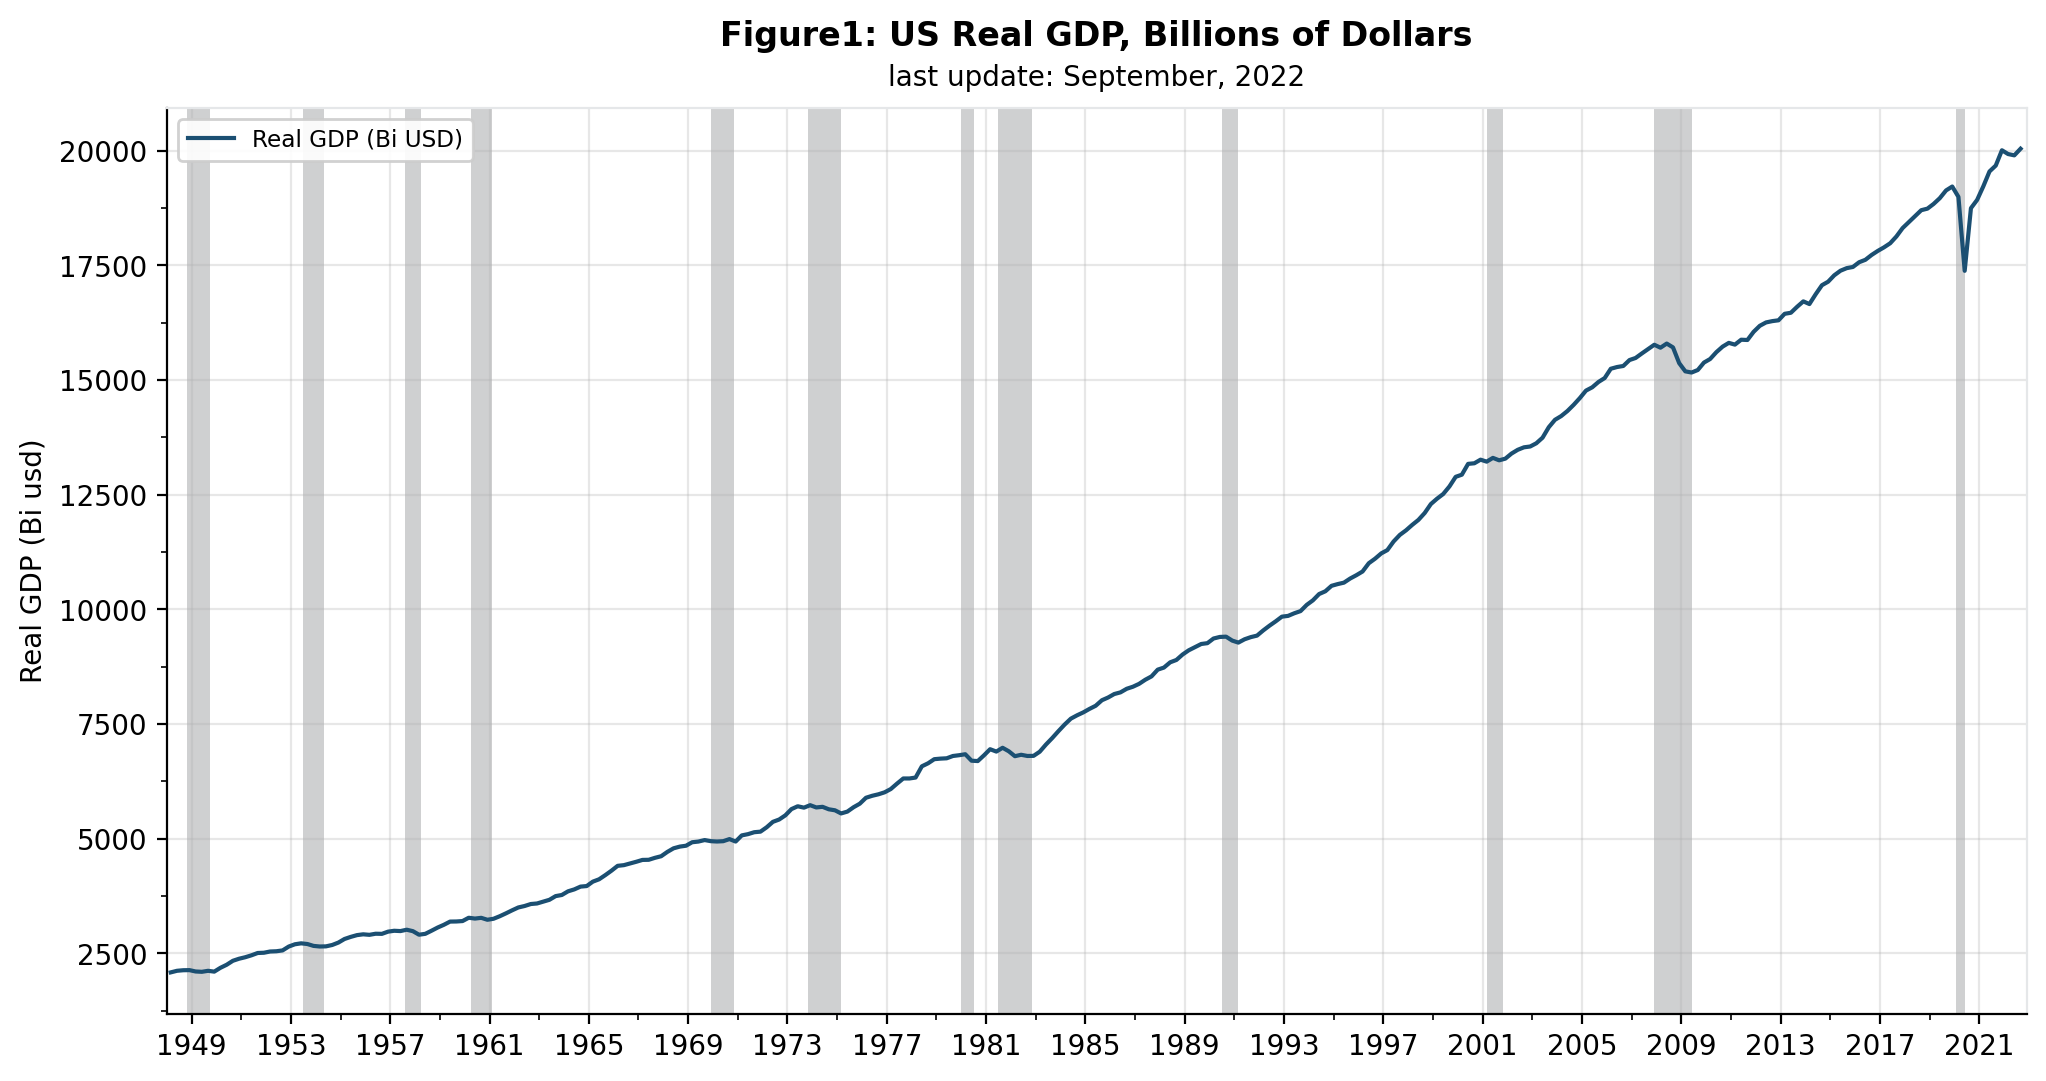

In [10]:
# Real GDP
data = (gdp[
    (gdp["LineDescription"]=="Gross domestic product") &
    (gdp["METRIC_NAME"]=="Chained Dollars")].copy())

data["series_id"] = data["series_id"].replace("T10106_A191RX","Real GDP (Bi USD)")
data["value"] = data["value"]/1000

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Real GDP (Bi USD)'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1948-01-01",
                  title ='Figure1: US Real GDP, Billions of Dollars',
                  ylab='Real GDP (Bi usd)',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True,  hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 2500, y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

The quick recovery was made possible for two main reasons: The peculiar nature of the recession, and the fiscal and monetary stimulus employed by the Government and the FED to support the social distance measures. The interaction between these two factors helps to explain the recent acceleration of inflation in the United States.

Starting with the peculiar nature of the covid 19 recession. Unlike other recent recessions, especially the 2008 financial crisis, the drop in GDP was caused by an exogenous shock caused by the spread of the virus. Graph 2 shows the contribution to the annualized quarterly percent change of the US GDP. We can see that both the recession and the recovery had household consumption as a key point.

In [11]:
# Contribution for the Real GDP Quarterly Change
gdp_contribution = gdp[(gdp["METRIC_NAME"]=="Quantity Contributions")].copy()

gdp_contribution = gdp_contribution[
    gdp_contribution["LineDescription"].isin(["Personal consumption expenditures",
                                              "Fixed investment",
                                              "Change in private inventories",
                                              "Net exports of goods and services",
                                              "Government consumption expenditures and gross investment"])]

gdp_contribution["series_id"] = (
    gdp_contribution["series_id"]
    .replace(["T10102_DPCERY","T10102_A007RY","T10102_A019RY","T10102_A014RY","T10102_A822RY"],
             ["Consumption","Investment","Net Exports","Inventories","Government"] ))

# reshaping data:
gdp_contribution = (
    pd.pivot_table(
        gdp_contribution[["date","series_id","value"]],
        values="value", columns="series_id", index="date")
    .reset_index()
    .rename_axis(None,axis=1)
)

gdp_contribution["GDP"] = (gdp_contribution["Consumption"]+
                           gdp_contribution["Government"]+
                           gdp_contribution["Inventories"]+
                           gdp_contribution["Investment"]+
                           gdp_contribution["Net Exports"])

gdp_contribution = gdp_contribution[gdp_contribution["date"]>="2002"]

# _positive
contr_positive = gdp_contribution.drop(columns = "GDP").copy()
contr_positive.loc[contr_positive["Consumption"] < 0 ,"Consumption"] = 0
contr_positive.loc[contr_positive["Government"] < 0 ,"Government"] = 0
contr_positive.loc[contr_positive["Inventories"] < 0 ,"Inventories"] = 0
contr_positive.loc[contr_positive["Investment"] < 0 ,"Investment"] = 0
contr_positive.loc[contr_positive["Net Exports"] < 0 ,"Net Exports"] = 0

# _negative
contr_negative = gdp_contribution.drop(columns = "GDP").copy()
contr_negative.loc[contr_negative["Consumption"] >= 0 ,"Consumption"] = 0
contr_negative.loc[contr_negative["Government"] >= 0 ,"Government"] = 0
contr_negative.loc[contr_negative["Inventories"] >= 0 ,"Inventories"] = 0
contr_negative.loc[contr_negative["Investment"] >= 0 ,"Investment"] = 0
contr_negative.loc[contr_negative["Net Exports"] >= 0 ,"Net Exports"] = 0

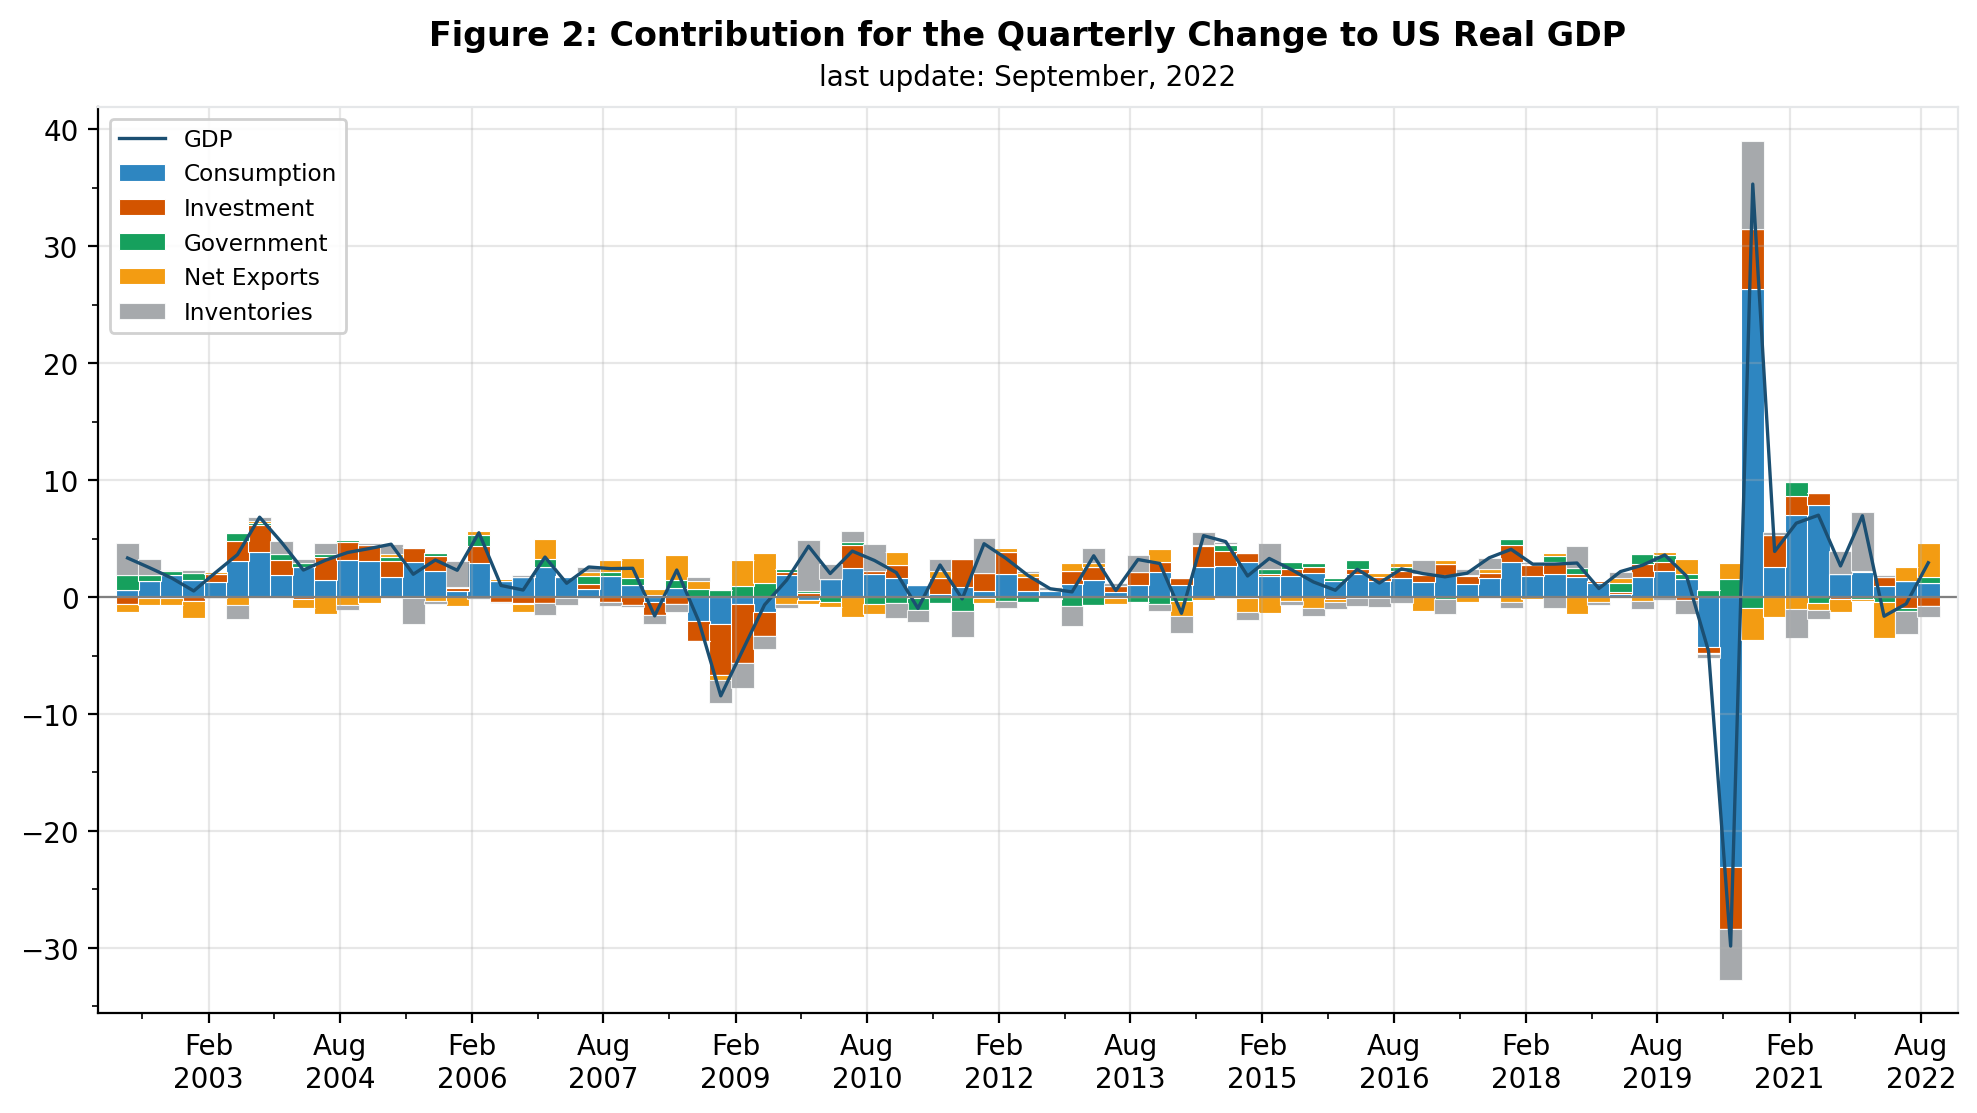

In [12]:
# chart:
fig, ax = plt.subplots(figsize=(12,6))

# positive values
ax.bar(contr_positive["date"], contr_positive["Consumption"],
       width = 95, label="Consumption", color= colors[43], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_positive["date"], contr_positive["Investment"], width = 95,
       bottom = contr_positive["Consumption"], label="Investment", color= colors[1], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_positive["date"], contr_positive["Government"], width = 95,
       bottom = contr_positive["Consumption"]+contr_positive["Investment"],
       label="Government", color= colors[2], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_positive["date"], contr_positive["Net Exports"], width = 95,
       bottom = contr_positive["Consumption"]+contr_positive["Investment"]+contr_positive["Government"],
       label="Net Exports", color= colors[6], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_positive["date"], contr_positive["Inventories"], width = 95,
       bottom = contr_positive["Consumption"]+contr_positive["Investment"]+
       contr_positive["Government"] + contr_positive["Net Exports"],
       label="Inventories", color= colors[102], alpha=0.8,
       edgecolor = 'white', linewidth = 0.4)



# negative values
ax.bar(contr_negative["date"], contr_negative["Consumption"],
       width = 95, label="Consumption", color= colors[43], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_negative["date"], contr_negative["Investment"], width = 95,
       bottom = contr_negative["Consumption"], label="Investment", color= colors[1], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_negative["date"], contr_negative["Government"], width = 95,
       bottom = contr_negative["Consumption"]+contr_negative["Investment"],
       label="Government", color= colors[2], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_negative["date"], contr_negative["Net Exports"], width = 95,
       bottom = contr_negative["Consumption"]+contr_negative["Investment"]+contr_negative["Government"],
       label="Net Exports", color= colors[6], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_negative["date"], contr_negative["Inventories"], width = 95,
       bottom = contr_negative["Consumption"]+contr_negative["Investment"]+
       contr_negative["Government"] + contr_negative["Net Exports"],
       label="Inventories", color= colors[102], alpha=0.8,
       edgecolor = 'white', linewidth = 0.4)

# line
sns.lineplot(data=gdp_contribution,
            x="date", y="GDP",
            color=colors[0], ax=ax, legend=False,linewidth = 1.2)

ax.legend(['GDP','Consumption', 'Investment','Government', 'Net Exports', 'Inventories'], 
    loc='upper left', frameon=True, framealpha=0.9, fontsize='small')

ax.axhline(y=0, color='gray', lw=0.8, label = "_line")

ax.margins(x=0.01, y=0.04)

# date axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=9))

year_month_formatter = mdates.DateFormatter("%b\n%Y")
ax.xaxis.set_major_formatter(year_month_formatter)

# y axis
ax.yaxis.set_major_locator(MultipleLocator(10.0))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylabel(None)

#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.spines['top'].set_edgecolor(colors[107])
ax.spines['right'].set_edgecolor(colors[107])

ax.grid(axis='y', alpha=0.3)
ax.grid(axis='x', alpha=0.3)

ax.set_title('Figure 2: Contribution for the Quarterly Change to US Real GDP', y=1.05, loc="center",
            fontweight="bold")

# subtitle...
last = contr_positive.loc[contr_positive['date']==max(contr_positive['date']),:]

ax.xaxis.set_label_position('top')
text = last["date"].dt.strftime("%B, %Y").values[0]

ax.set_xlabel(f"last update: {text}",
              labelpad = 8, loc="center")

plt.show()

Graph 3 shows the real consumption of American households in billions of dollars. As this component represents a large proportion of GDP, it is not surprising that they are similar.

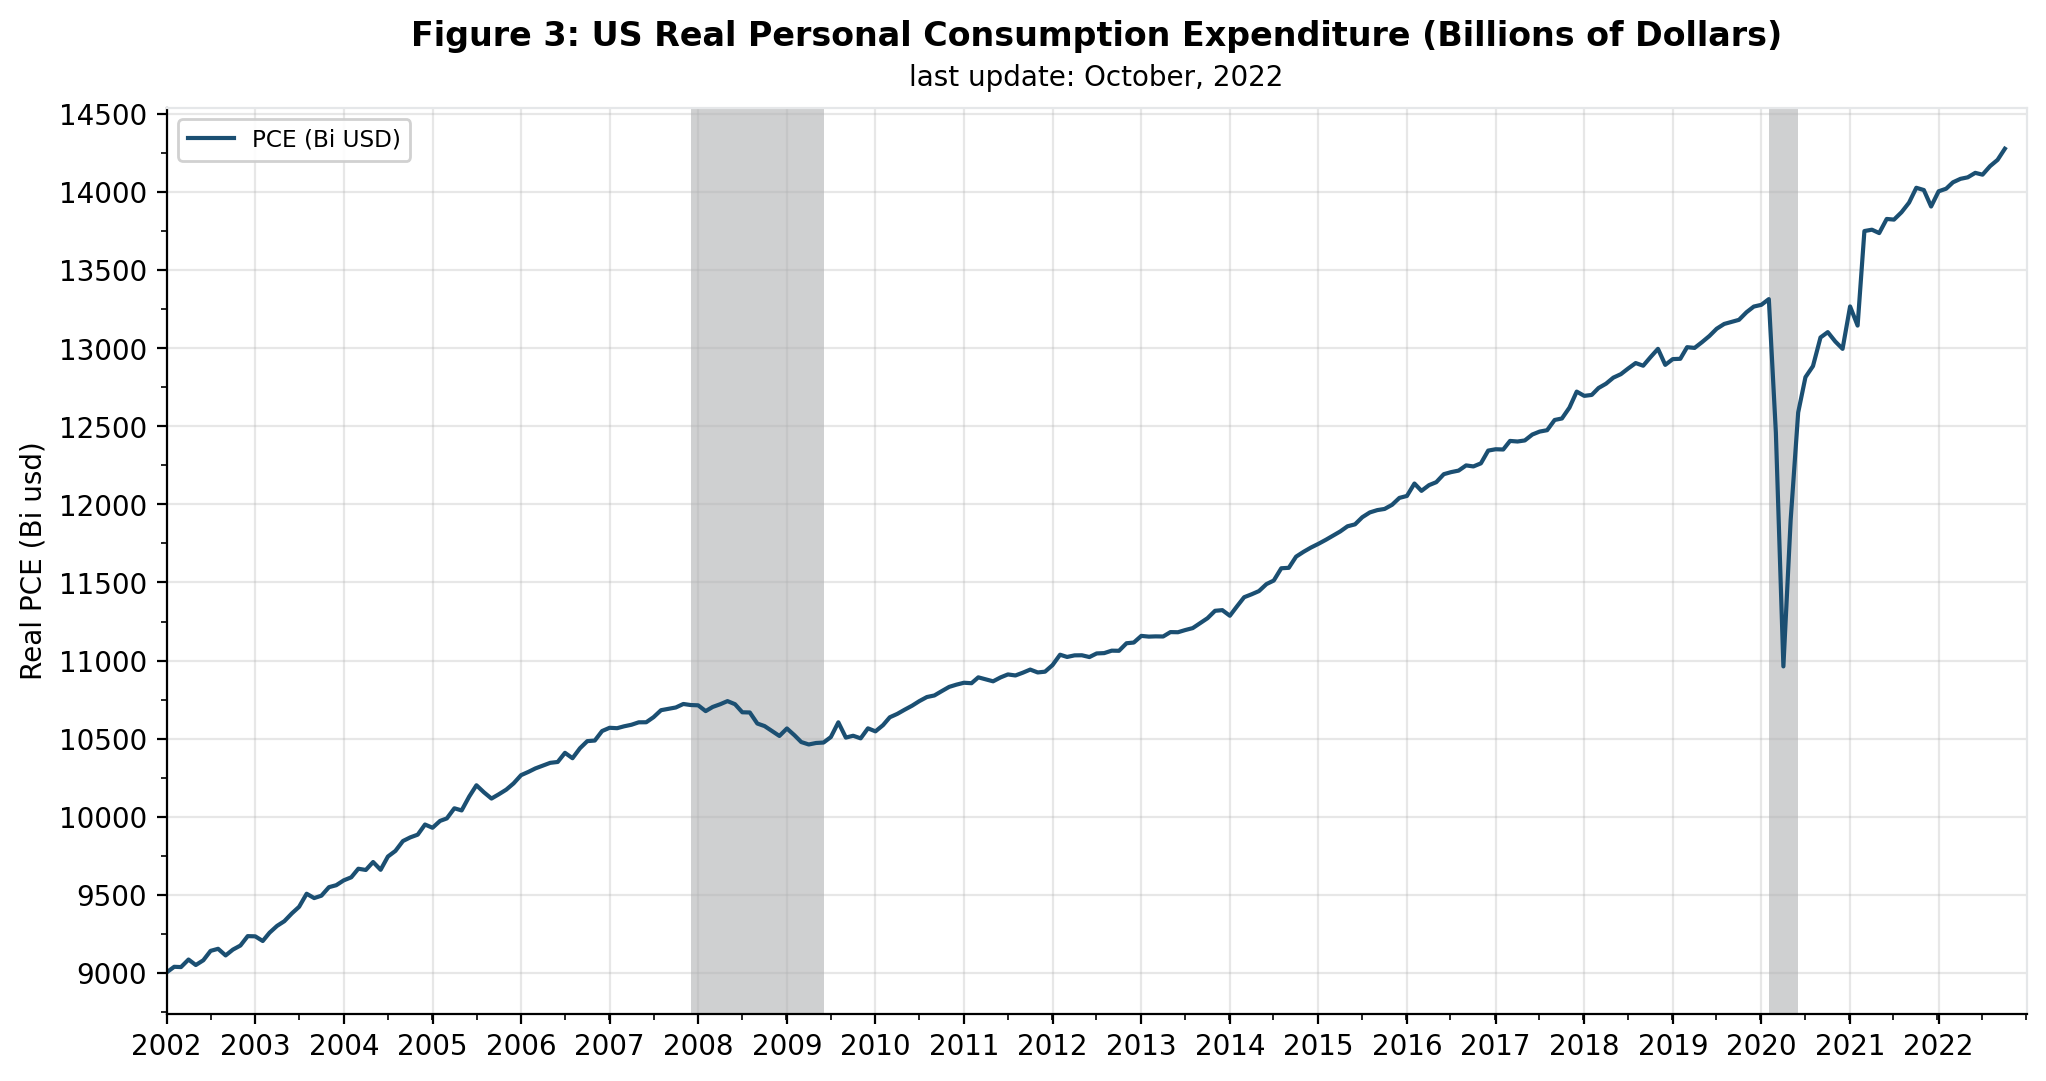

In [13]:
# Personal consumption expenditures (PCE)
data = pce[(pce["METRIC_NAME"]=="Chained Dollars") & 
                (pce["LineDescription"]=="Personal consumption expenditures (PCE)")].copy()

data["series_id"] = data["series_id"].replace("T20806_DPCERX","PCE (Bi USD)")
data["value"] = data["value"]/1000

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['PCE (Bi USD)'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2002-01-01",
                  title ='Figure 3: US Real Personal Consumption Expenditure (Billions of Dollars)',
                  ylab='Real PCE (Bi usd)',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True,hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 500, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

It is more interesting to analyze the composition of consumption. Figure 4 breaks the previous chart between the consumption of goods and services. After the first months of social distance measures, when the consumption of both groups dropped, we can observe a strong acceleration in the consumption of goods, which reflected the continuity of the isolation measures, which did not allow the consumption of services. With the advance of vaccination and the reopening process, the movement has been gradually reversing since the beginning of 2021.

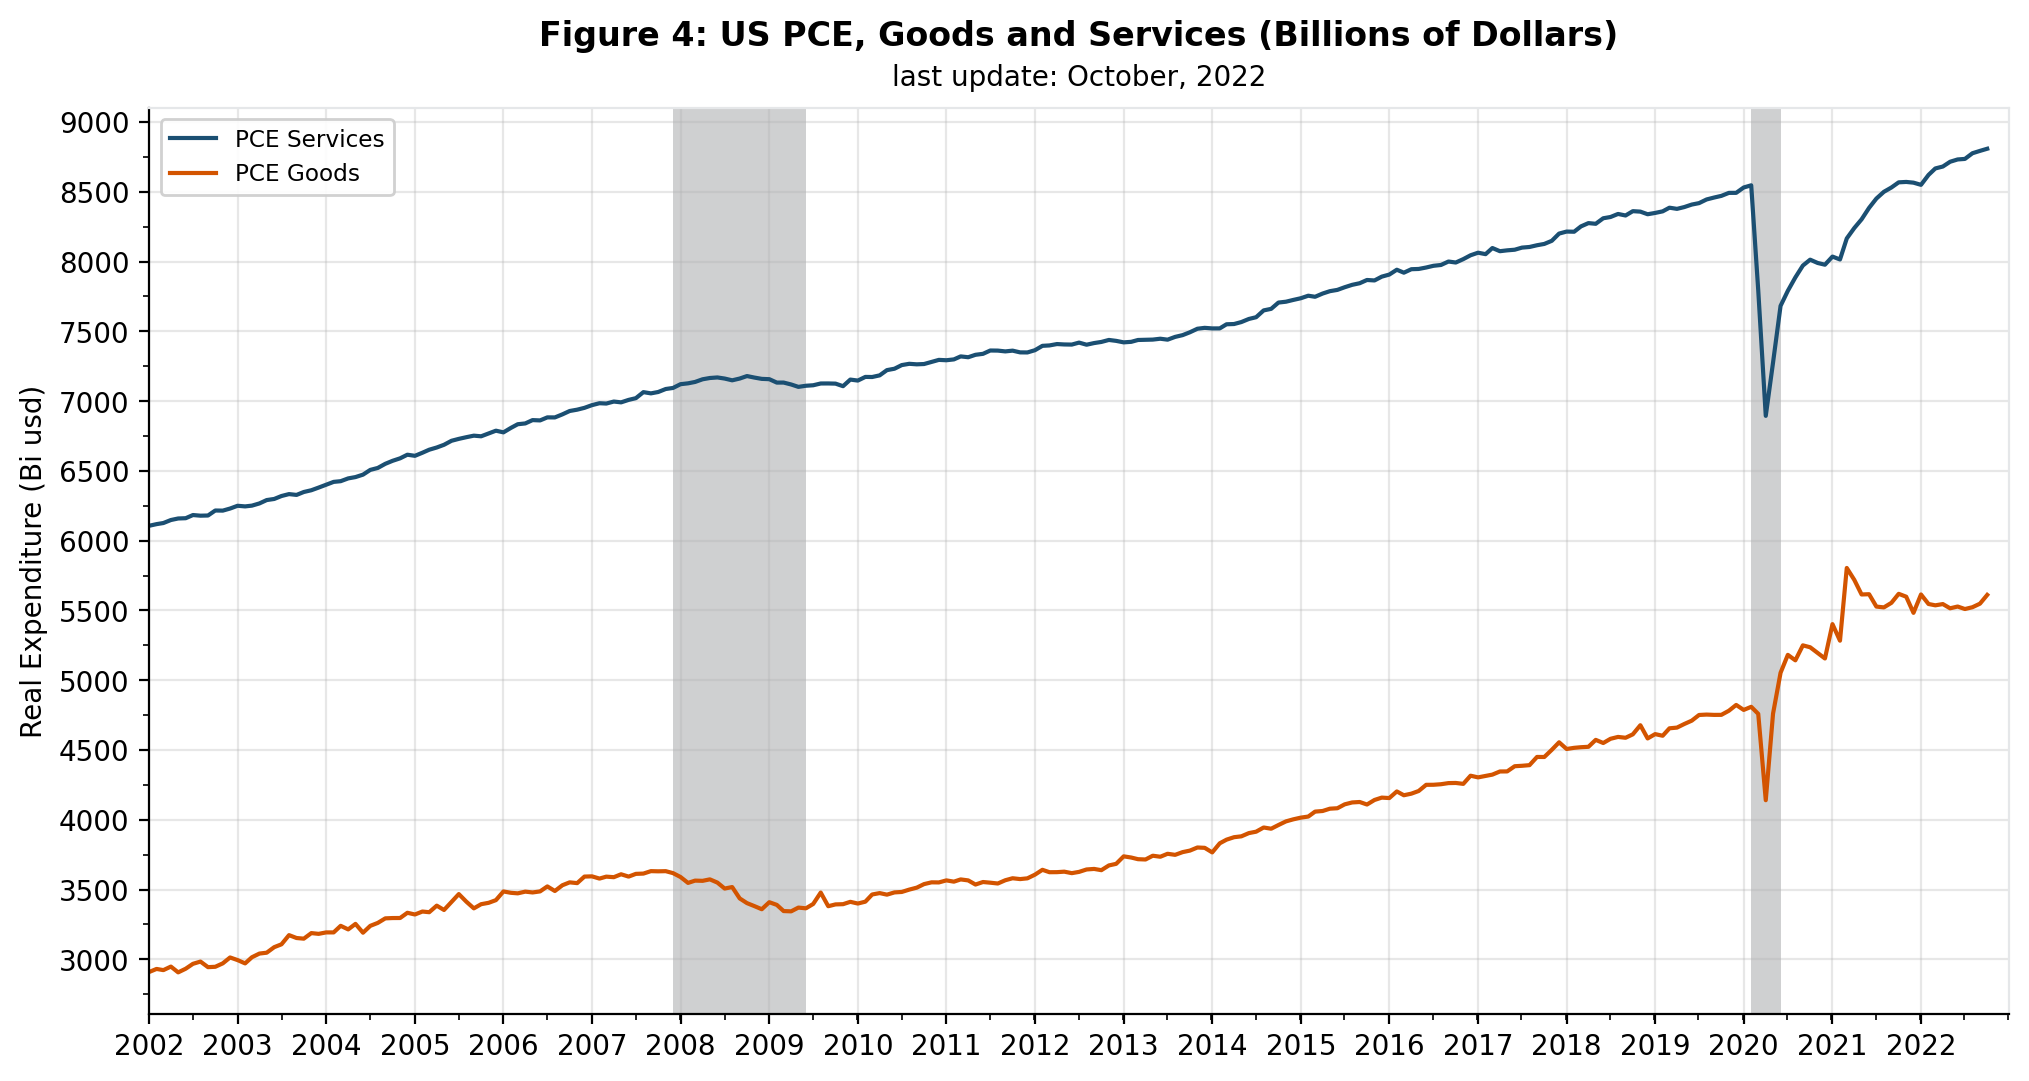

In [14]:
# Personal Consumption: Services x Goods
data = pce[(pce["METRIC_NAME"]=="Chained Dollars") & 
                (pce["LineDescription"].isin(["Services","Goods"]))].copy()

data["series_id"] = (
    data["series_id"]
    .replace(["T20806_DSERRX","T20806_DGDSRX"],
             ["PCE Services","PCE Goods"])
)

data["value"] = data["value"]/1000

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["PCE Services","PCE Goods"],
    'hue': [colors[0],colors[1]],
    'alpha':[1,1],
    'annotation':[False, False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2002-01-01",
                  title ='Figure 4: US PCE, Goods and Services (Billions of Dollars)',
                  ylab='Real Expenditure (Bi usd)',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 500, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

During recessions, both the consumption of goods and services tend to fall, either because of increased uncertainty or the effective loss of income, caused by rising unemployment, for example. In fact, there was a sharp drop in the number of people employed during the first months of the pandemic, as shown in graph 5. Unlike what we saw in consumption (graph 3), which in less than a year had already returned to pre-pandemic levels, the number of people employed took longer to return to what it was before, which is puzzling. How could consumption be back to its previous levels, while labor income was still low?

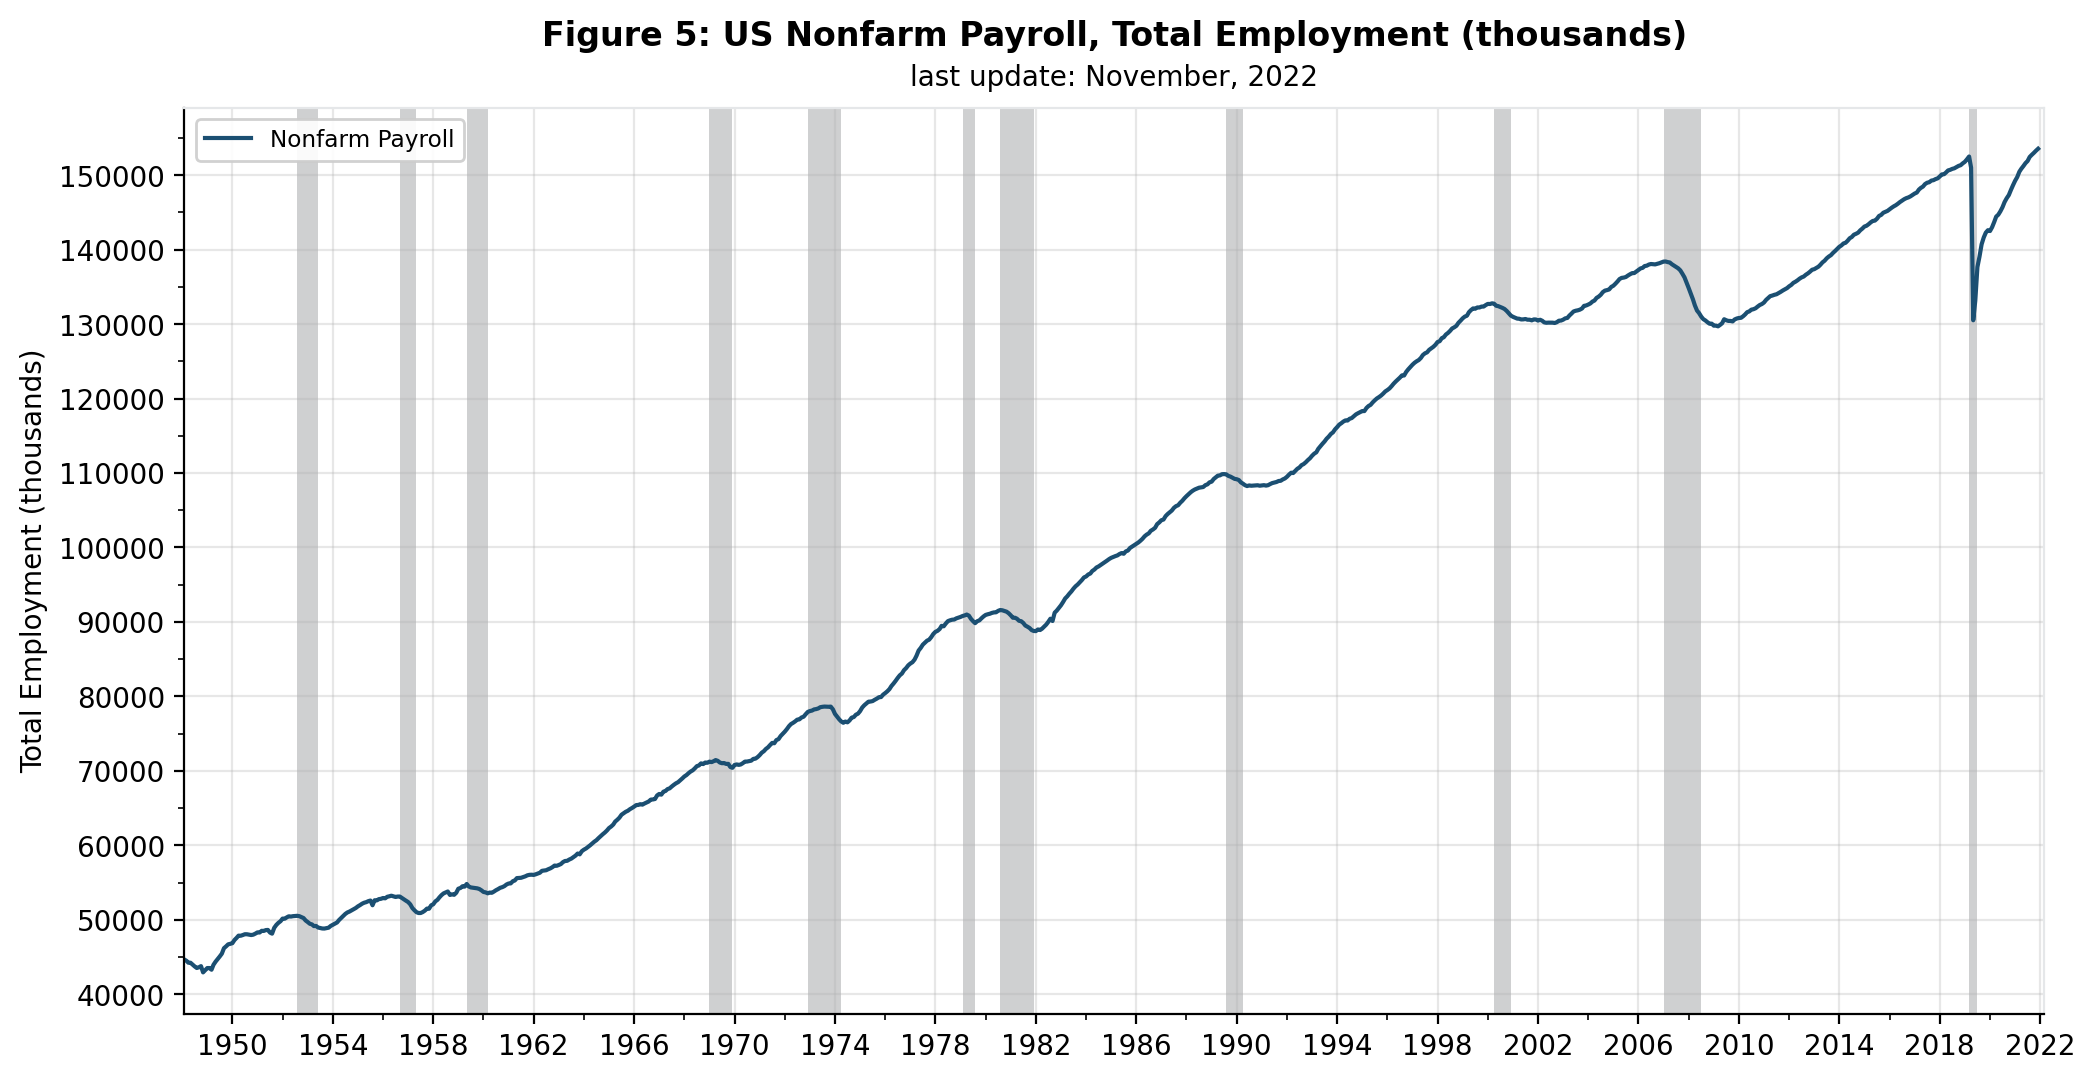

In [15]:
# NonFarm Payroll
data = (
    ces[ces["series_id"]=="CES0000000001"]
    .copy()
    .replace("CES0000000001","Nonfarm Payroll")
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Nonfarm Payroll'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1949-01-01",
                  title ='Figure 5: US Nonfarm Payroll, Total Employment (thousands)',
                  ylab='Total Employment (thousands)',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 10000, y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

The answer is the large volume of fiscal and monetary stimulus adopted to sustain the social distance measures. Graph 6 shows the evolution of federal government expenditures and revenues accumulated in 12 months. As in other recessions, expenses increased, albeit much more strongly in 2020. On the other hand, unlike the last two recessions, revenues were little affected. The increase in the public deficit, represented by the difference between the two curves, was one of the main measures to ease the crisis, mainly by extending unemployment insurance benefits and guaranteeing direct income transfers to individuals.

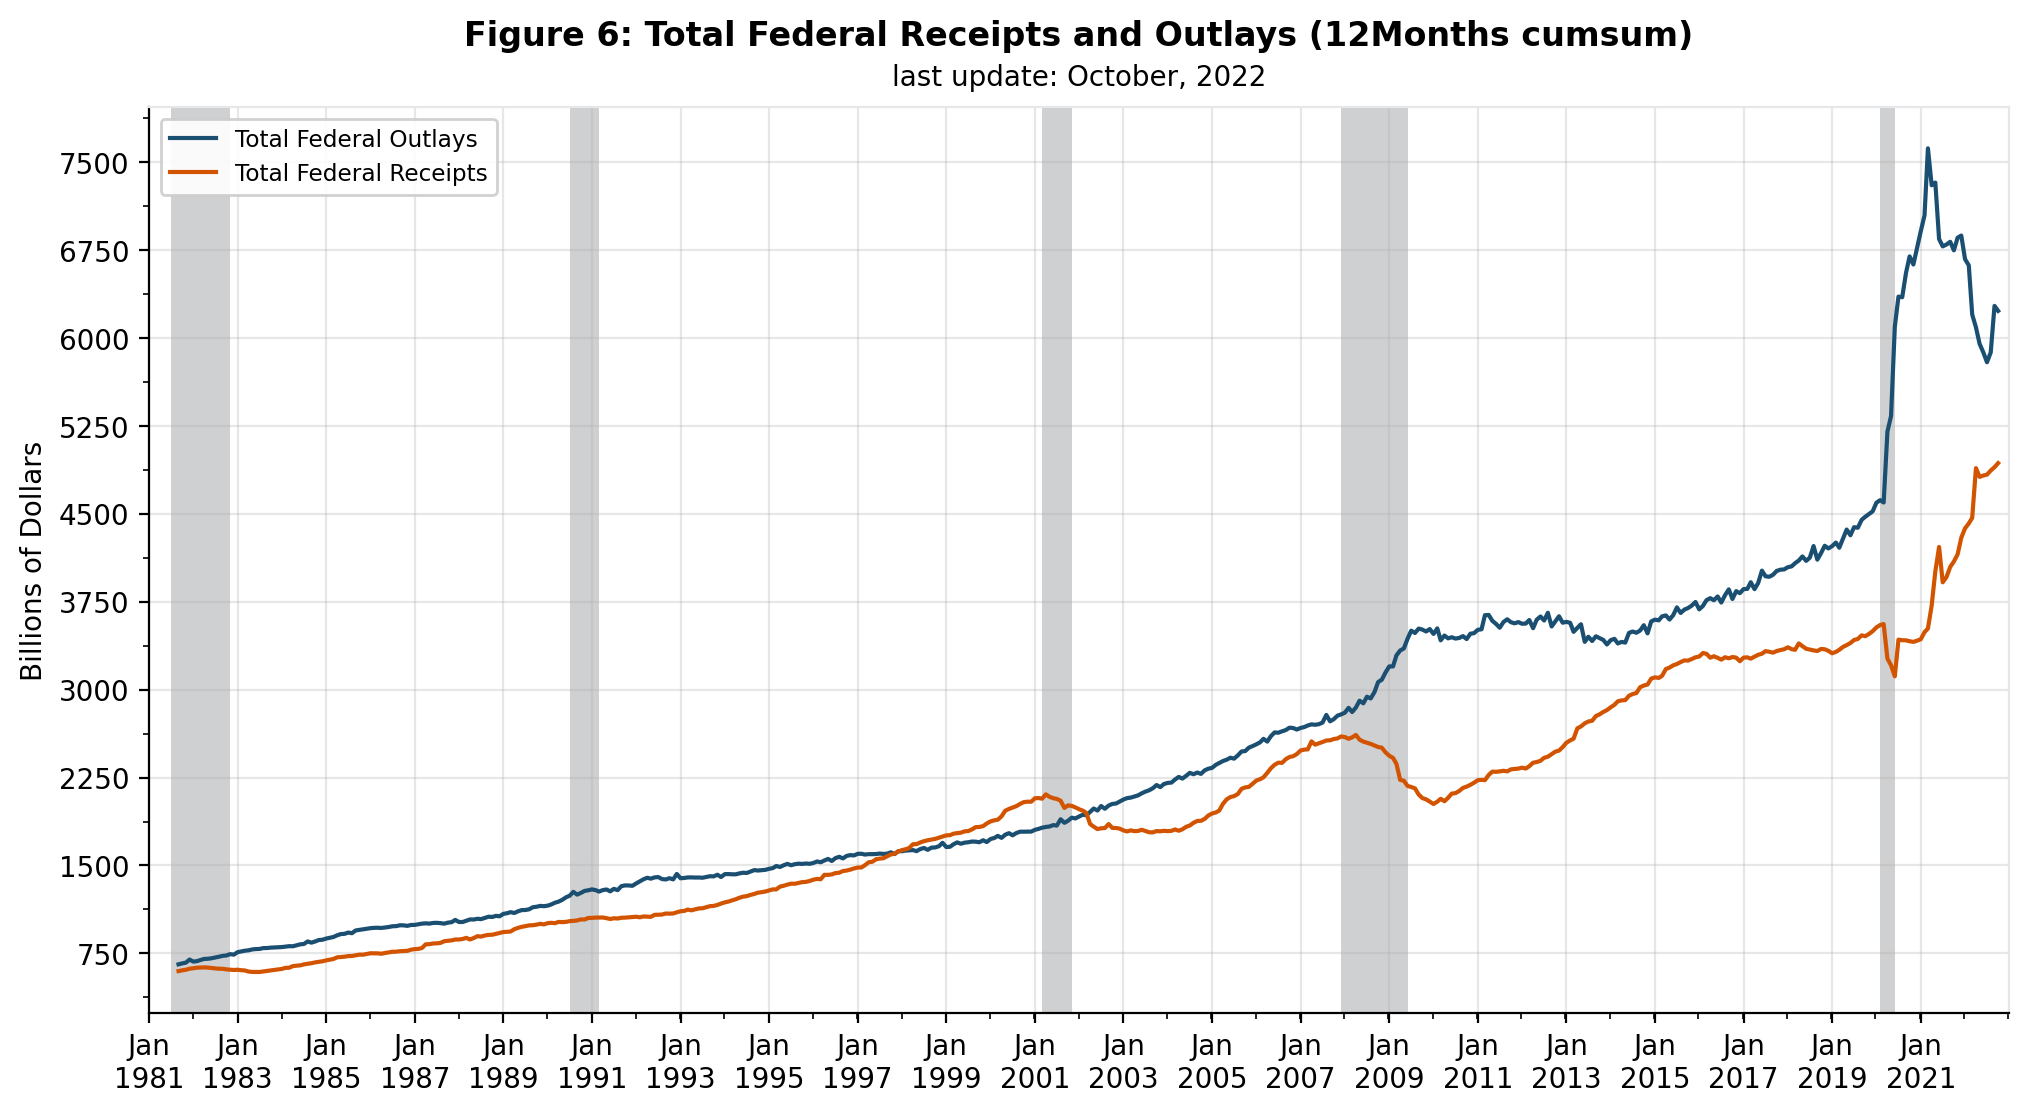

In [16]:
data = (
    fiscal[fiscal["series_id"].isin(["MTSO133FMS","MTSR133FMS"])]
    .copy()
    .replace(["MTSO133FMS","MTSR133FMS"],["Total Federal Outlays","Total Federal Receipts"])
)

data_ma = (data
           .copy()
           .sort_values("date")
           .set_index("date")
           .groupby("series_id")["value"]
           .rolling(12)
           .sum()
           .dropna()
           .reset_index())

data_ma["value"] = data_ma["value"]/1000

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Total Federal Outlays","Total Federal Receipts"],
    'hue': [fn.colors[0],fn.colors[1]],
    'alpha':[1,1],
    'annotation':[False,False]})

# running function
fig, ax = fn.ts_plot(df = data_ma[["series_id","date","value"]],
                     df_map = df_code,
                     start_date = "1981-01-01",
                     title ='Figure 6: Total Federal Receipts and Outlays (12Months cumsum)',
                     ylab='Billions of Dollars',
                     fig_size = (12,6), legend_loc = "upper left",
                     plot_recession = True, hline = False, hline_loc = 0,
                     xmargin = 0.00, ymargin = 0.05,
                     y_major_loc = 750, y_minor_loc = 2,
                     x_major_loc = 24, x_minor_loc = 2, x_format = "%b\n%Y", n=90)

plt.show()

In addition to fiscal measures, large monetary stimulus was used by the FED, which reduced interest rates to zero and started a new quantitative easing program, with the purchase of 120 billion dollars monthly in treasury bonds and mortgage securities. Even with the recovery of the economy, employment, and the constant rise in inflation, the FED continued with a very stimulating monetary policy throughout 2021, only starting to tighten financial conditions in the first half of 2022. Graphs 7 and 8 show the evolution of Fed Funds and the Fed's total assets.

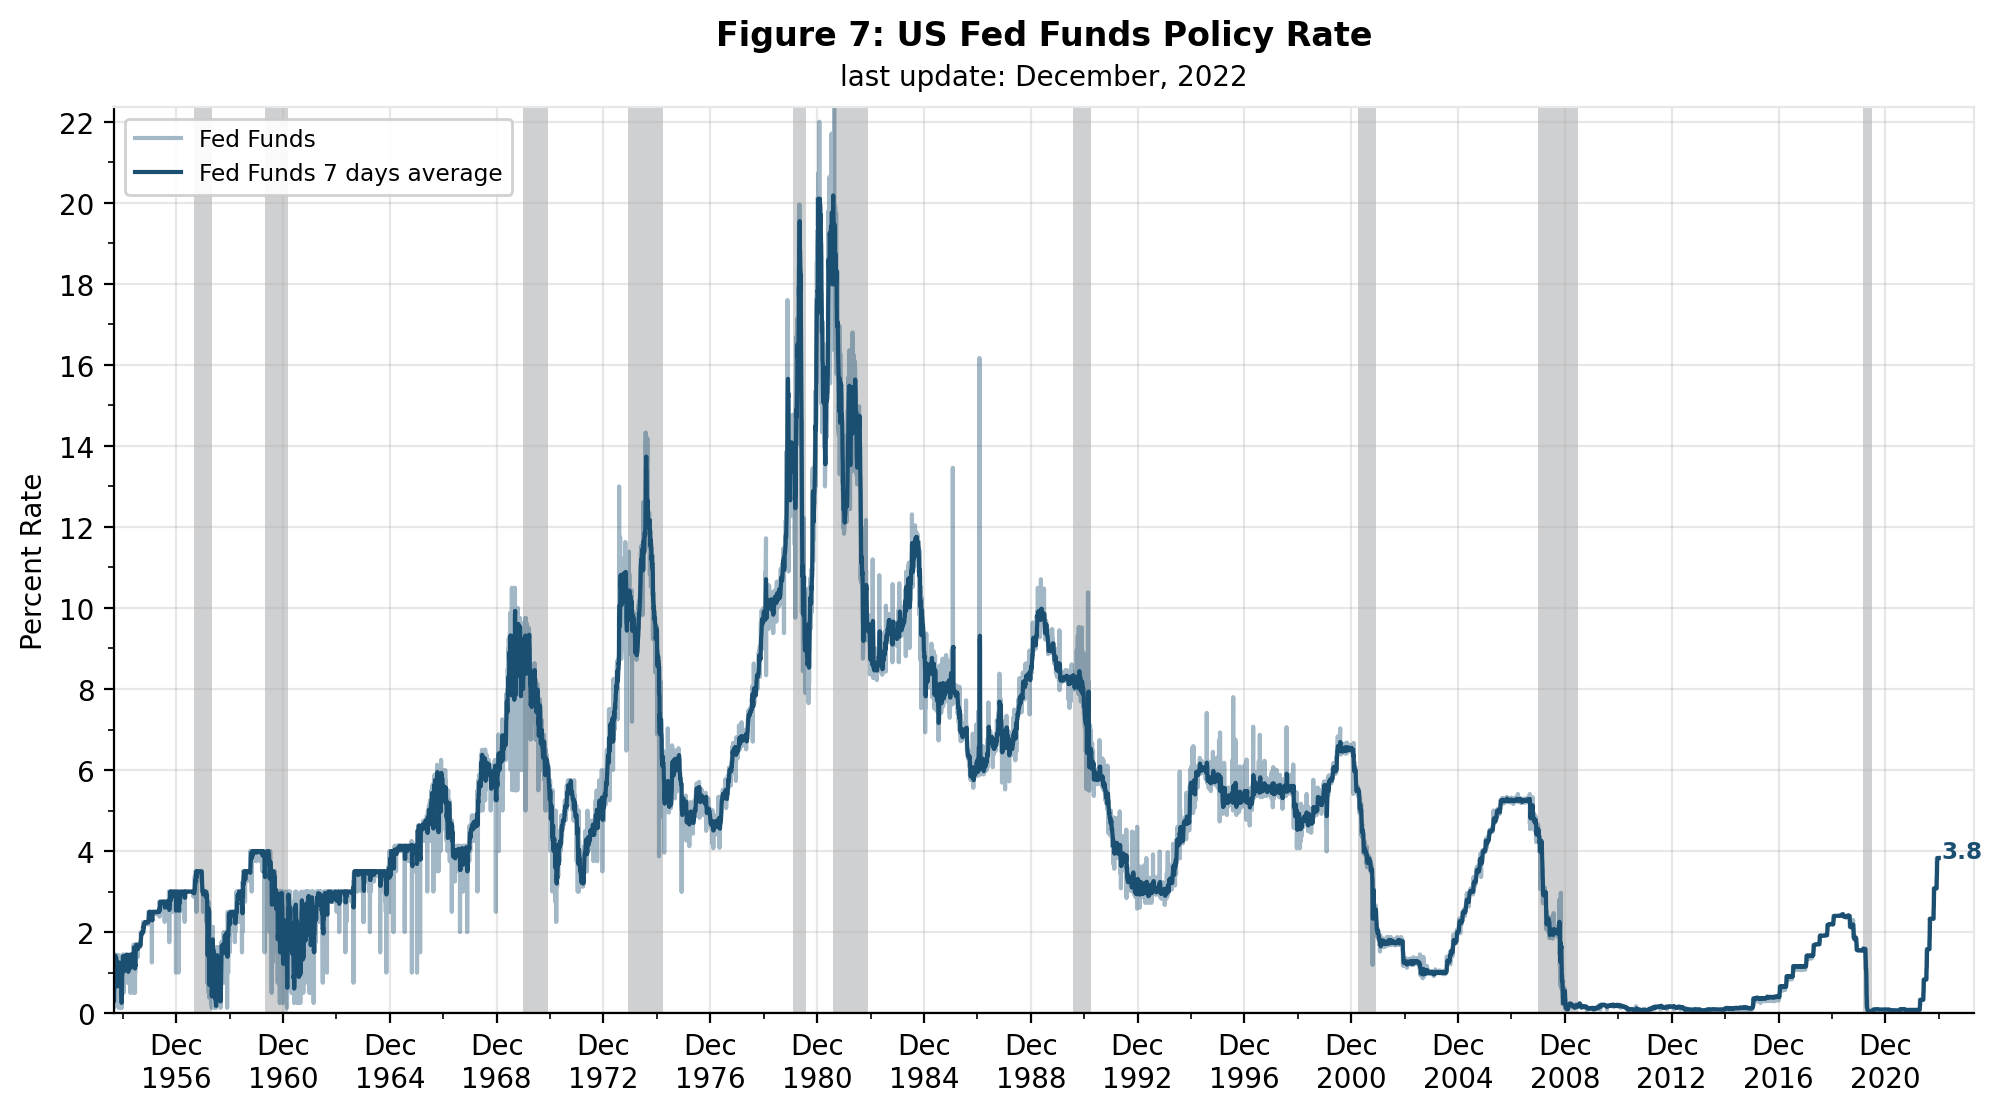

In [17]:
# Fed Funds
data = (
    ffunds[ffunds["series_id"]=="RIFSPFFNB"]
    .copy()
    .replace("RIFSPFFNB","Fed Funds")
    [["series_id","date","value"]]
)

data_ma = (data
           .copy()
           .sort_values("date")
           .set_index("date")
           .groupby("series_id")["value"]
           .rolling(7)
           .mean()
           .dropna()
           .reset_index()
           .replace("Fed Funds","Fed Funds 7 days average"))

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Fed Funds','Fed Funds 7 days average'],
    'hue': [colors[0],colors[0]],
    'alpha':[0.4,1],
    'annotation':[False, True]})

# running function
fig, ax = ts_plot(df = pd.concat([data,data_ma]),
                  df_map = df_code,
                  start_date = "1954-08-01",
                  title ='Figure 7: US Fed Funds Policy Rate',
                  ylab='Percent Rate',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = True, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.0,
                  y_major_loc = 2, y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%b\n%Y", n=480)

plt.show()

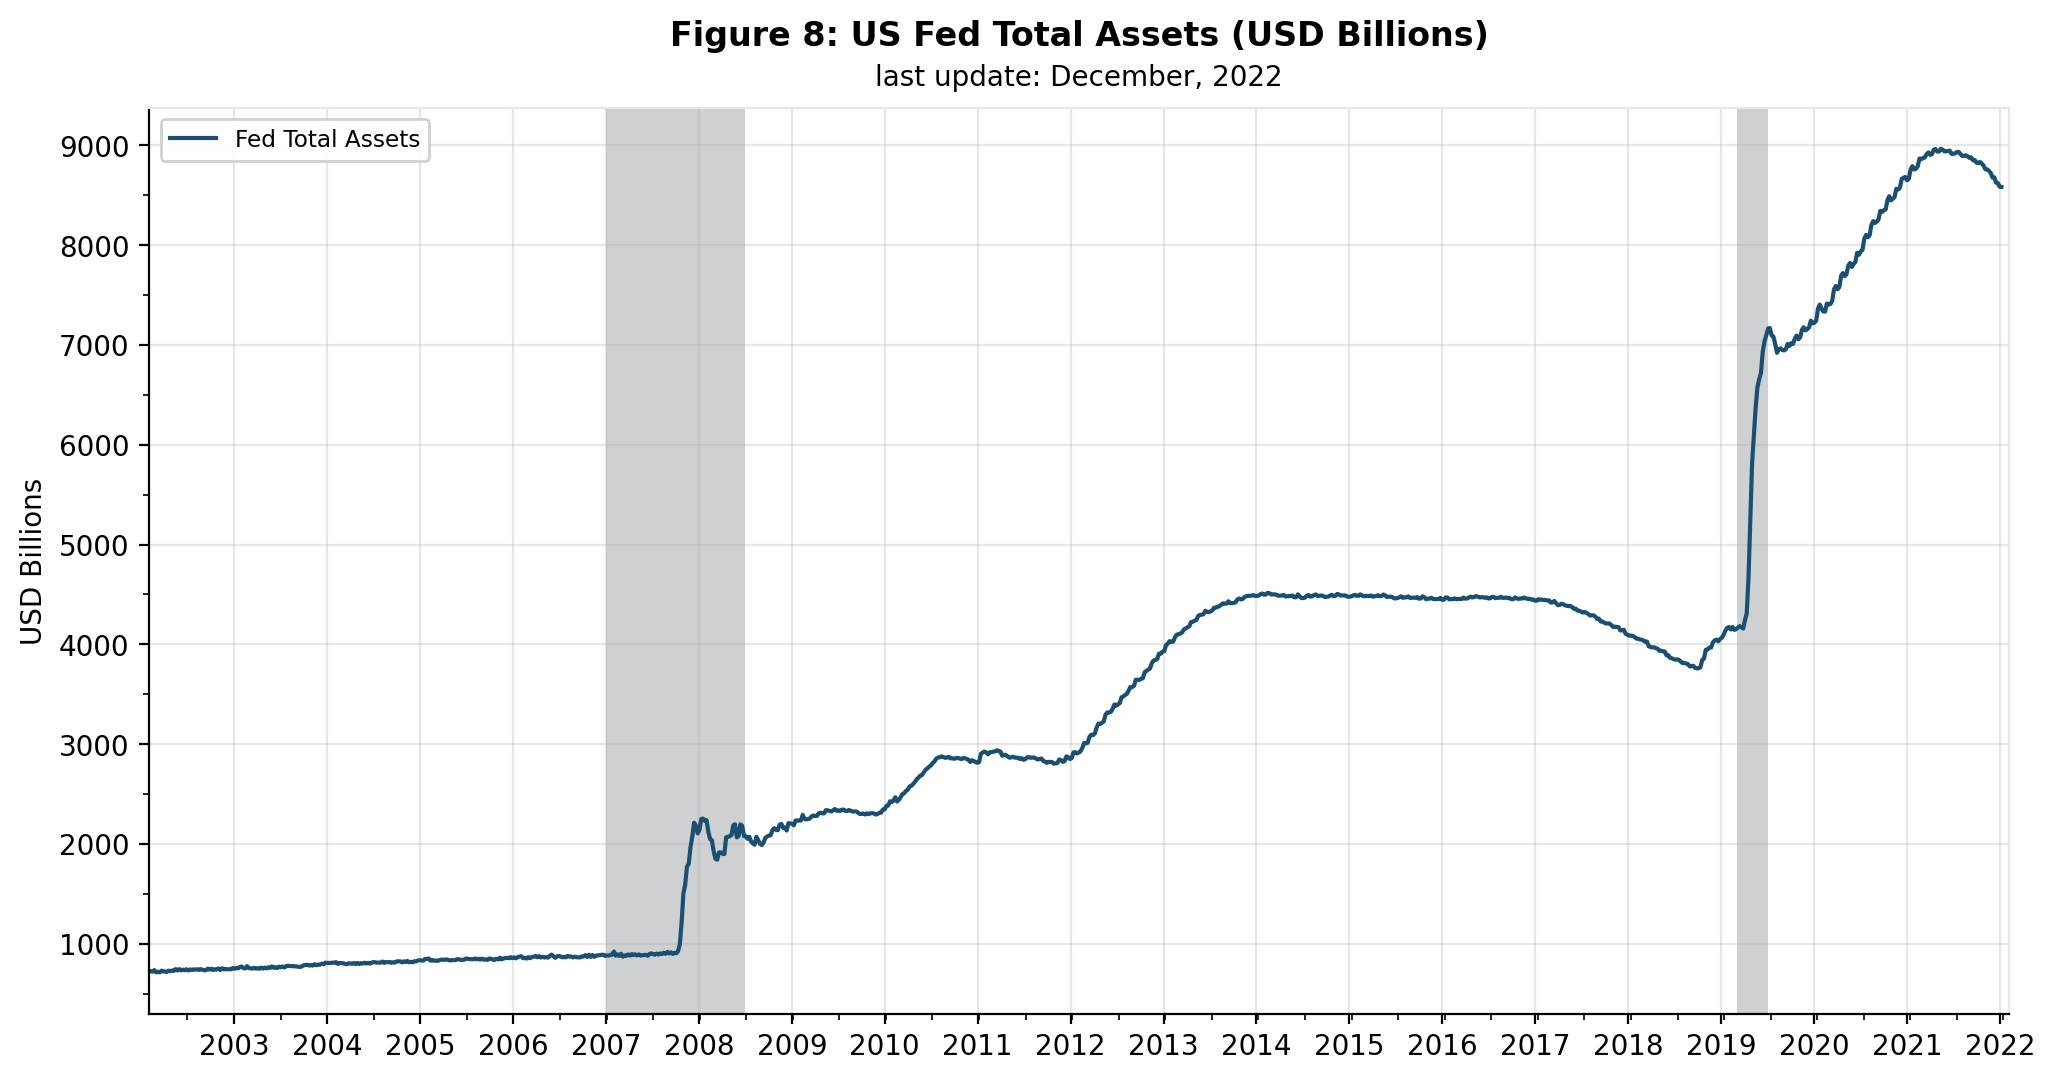

In [18]:
# Fed Total Assets
data = (
    fassets[fassets["series_id"]=="RESPPANWW"]
    .copy()
    .replace("RESPPANWW","Fed Total Assets")
)

data["value"] = data["value"]/1000

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Fed Total Assets'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2003-01-01",
                  title ='Figure 8: US Fed Total Assets (USD Billions)',
                  ylab='USD Billions',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 1000, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=30)

plt.show()

At first, there didn't seem to be any other alternative. The high degree of uncertainty regarding the evolution of the virus, the sharp drop in GDP, and the increase in unemployment, in a period when inflation was still low, made it clear to the monetary authorities and the government what they should do. Even more so when the slow recovery that took place after the 2008 financial crisis is taken into account. Too much stimulus would not represent a big issue at that time. In fact, there was a great overkill, and surprisingly, the effects were limited at that time. The economy reopened, and returned to normal, while inflation remained under control. The problem was that even with the economic recovery, new rounds of stimulus were adopted, and were fundamental to trigger the sharp increase in inflation. The exaggeration of the stimulus can be seen in Graph 9, which shows the disposable income of families, and the portion corresponding only to labor income. Direct transfers from the government via the three rounds of checks, and the extension of unemployment benefit programs more than offset the fall in labor income.

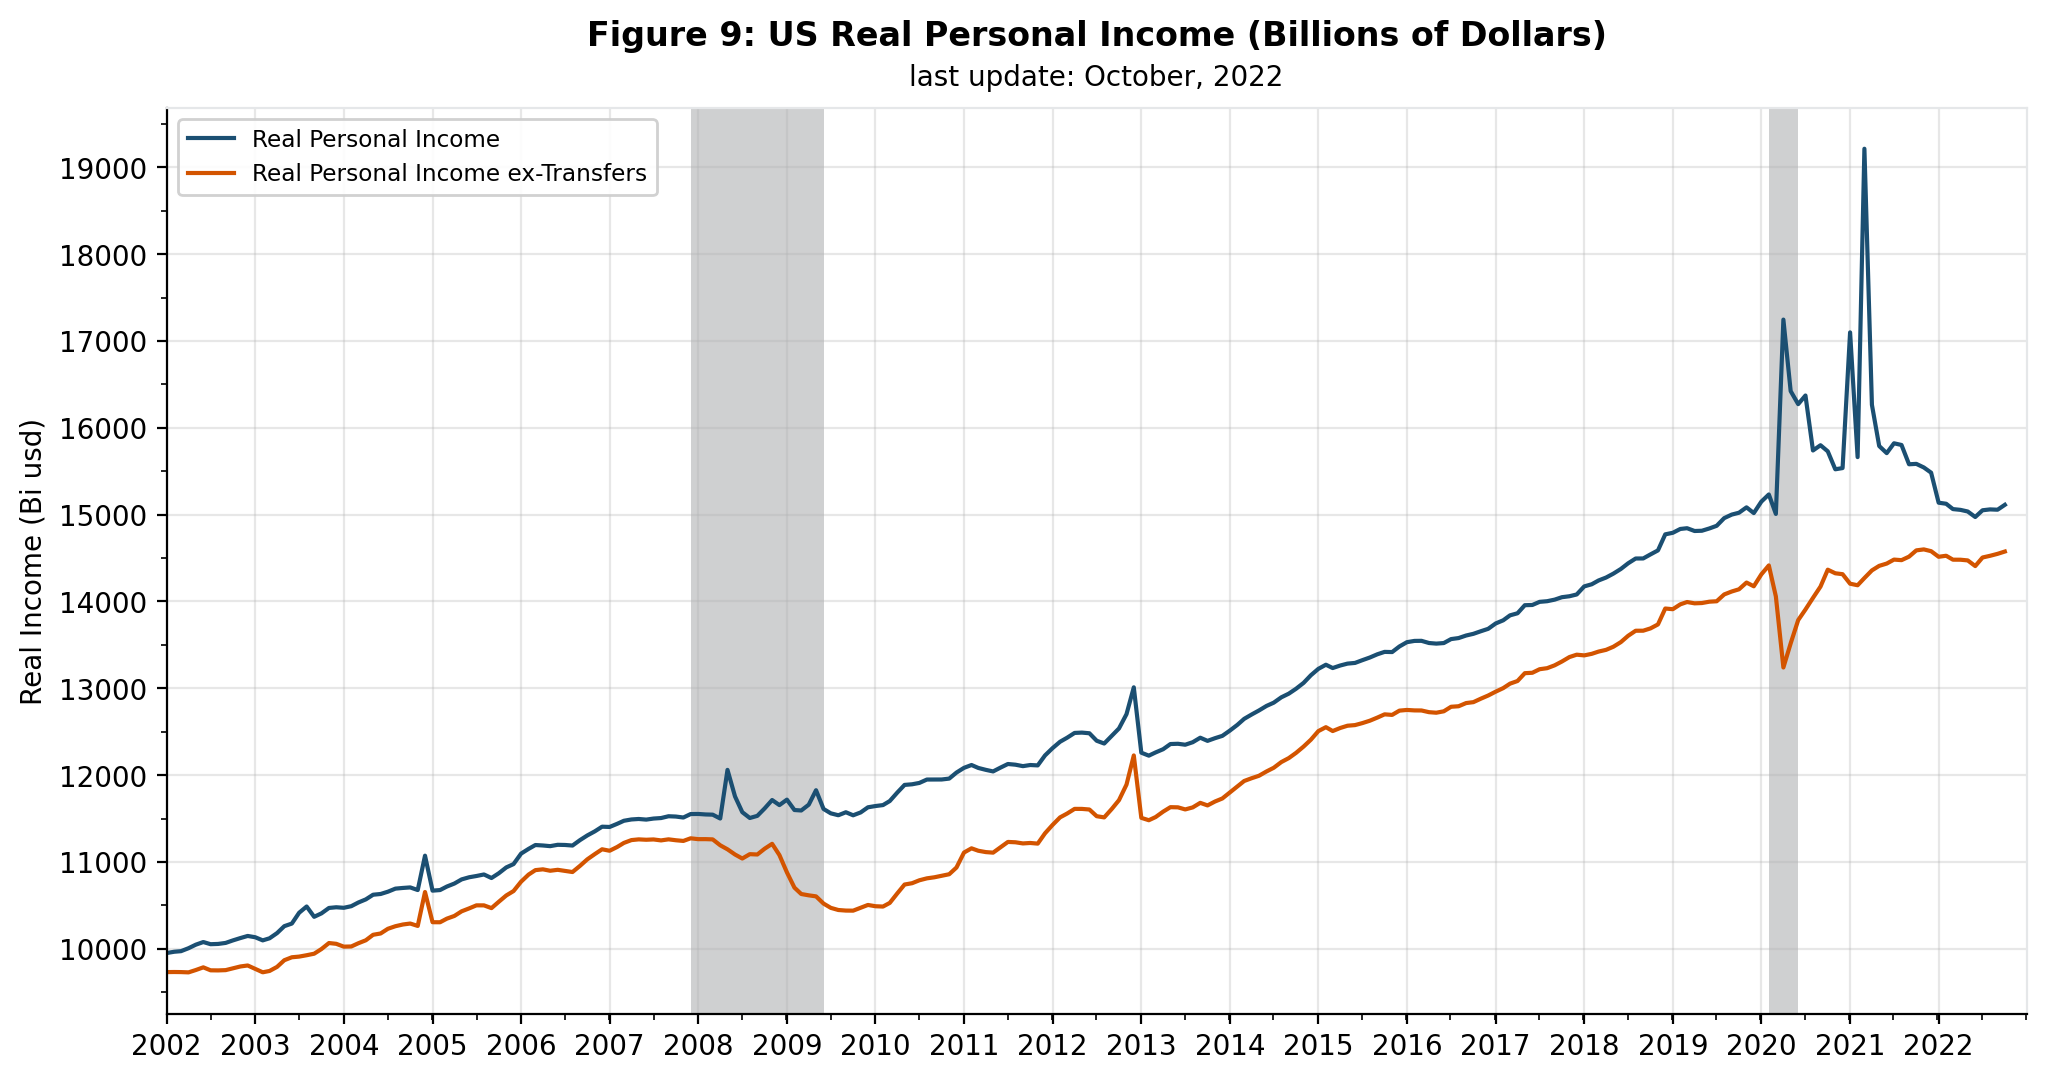

In [19]:
data = income[(income["METRIC_NAME"]=="Chained Dollars")].copy()

data["series_id"] = (
    data["series_id"]
    .replace(["T20600_A067RX","T20600_W875RX"],
             ["Real Personal Income","Real Personal Income ex-Transfers"])
)

data["value"] = data["value"]/1000

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Real Personal Income","Real Personal Income ex-Transfers"],
    'hue': [colors[0],colors[1]],
    'alpha':[1,1],
    'annotation':[False, False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2002-01-01",
                  title ='Figure 9: US Real Personal Income (Billions of Dollars)',
                  ylab='Real Income (Bi usd)',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 1000, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

The increase in disposable income with the drop in consumption caused by the lockdown led to a strong accumulation of savings by families that only began to be spent over the last few months, as shown in graph 10.

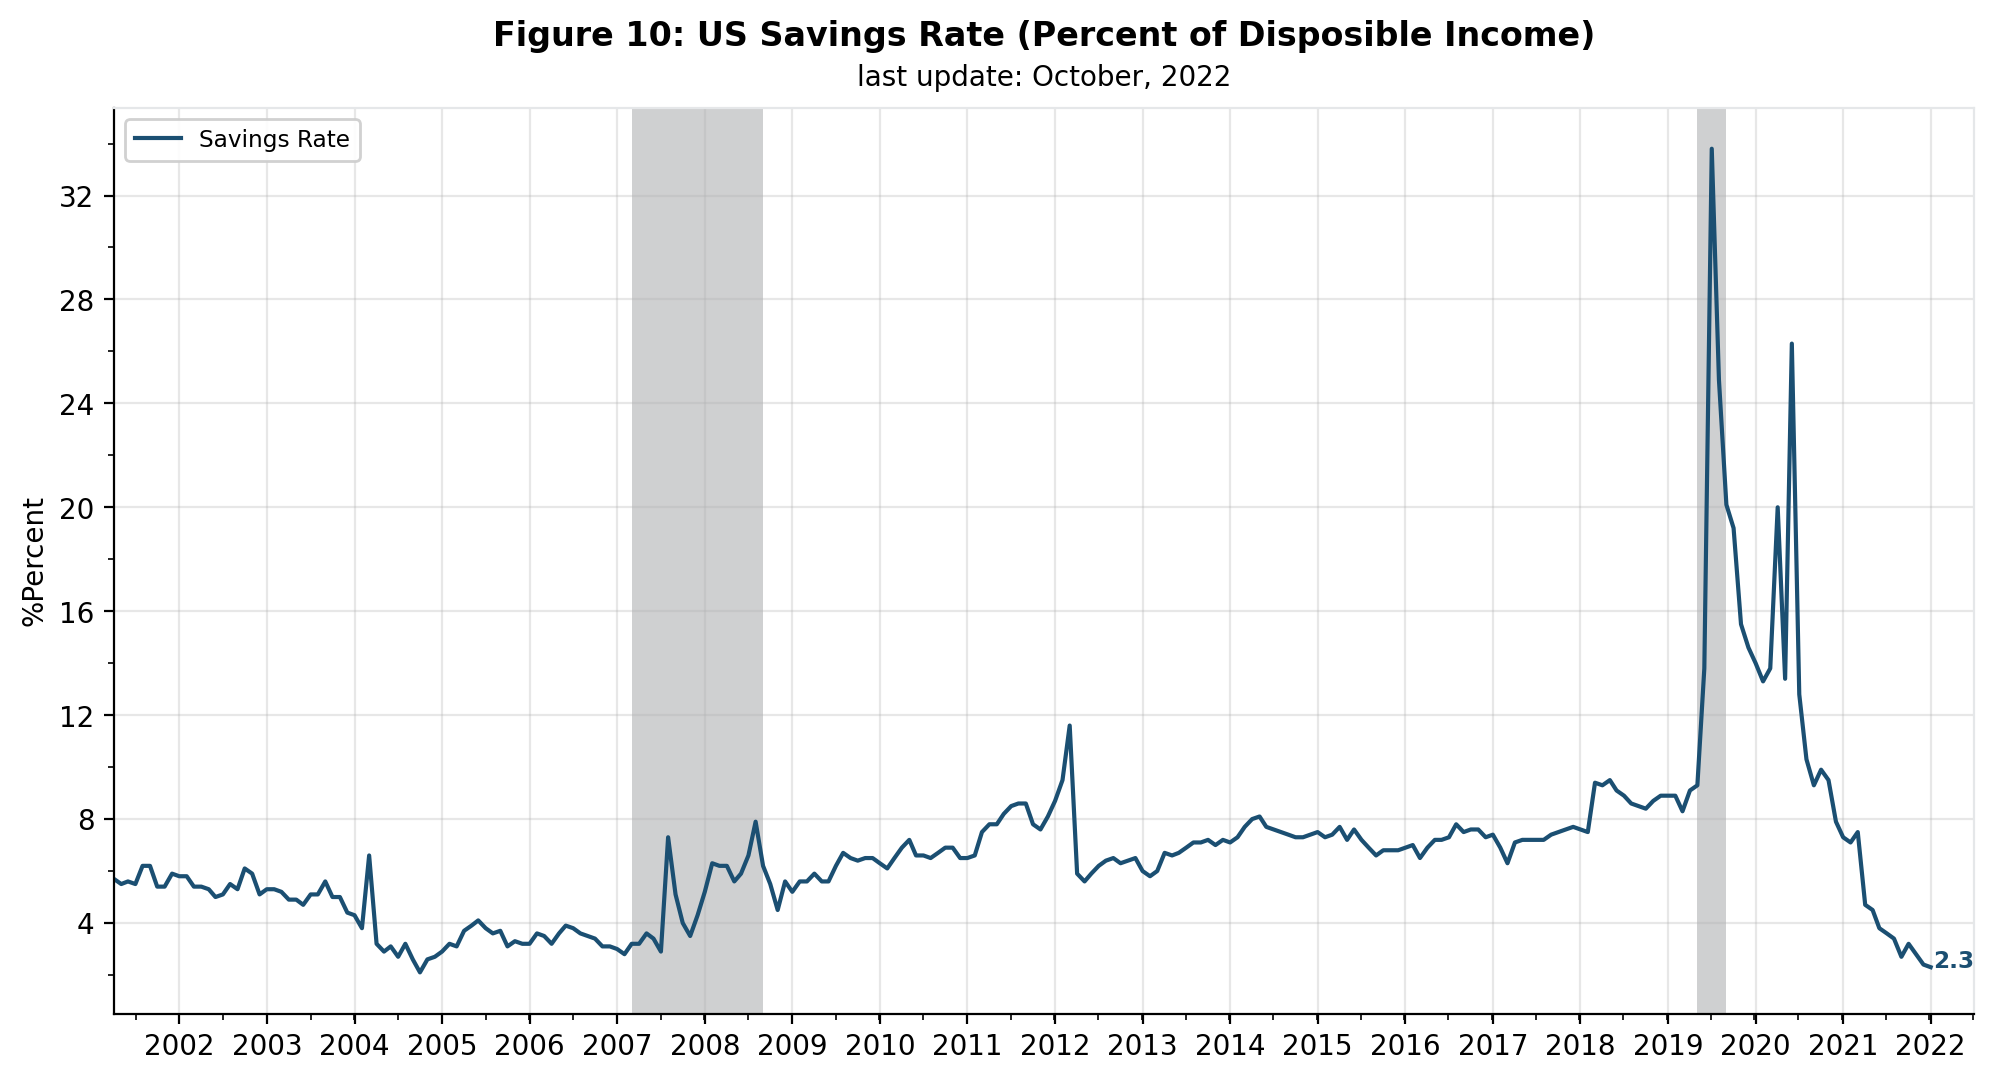

In [20]:
data = income[income["LineDescription"]
                 .isin(["Personal saving as a percentage of disposable personal income"])].copy()
data["series_id"] = (
    data["series_id"]
    .replace(["T20600_A072RC"],
             ["Savings Rate"])
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Savings Rate"],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2002-01-01",
                  title ='Figure 10: US Savings Rate (Percent of Disposible Income)',
                  ylab='%Percent',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 4, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=180)

plt.show()

Added to the accumulated savings, as a result of the fiscal policy, there was also a strong increase in the total wealth of households since the looser monetary policy boosted both the price of financial assets (chart 11) and the price of houses (chart 12), which correspond to the two main asset classes of American households.

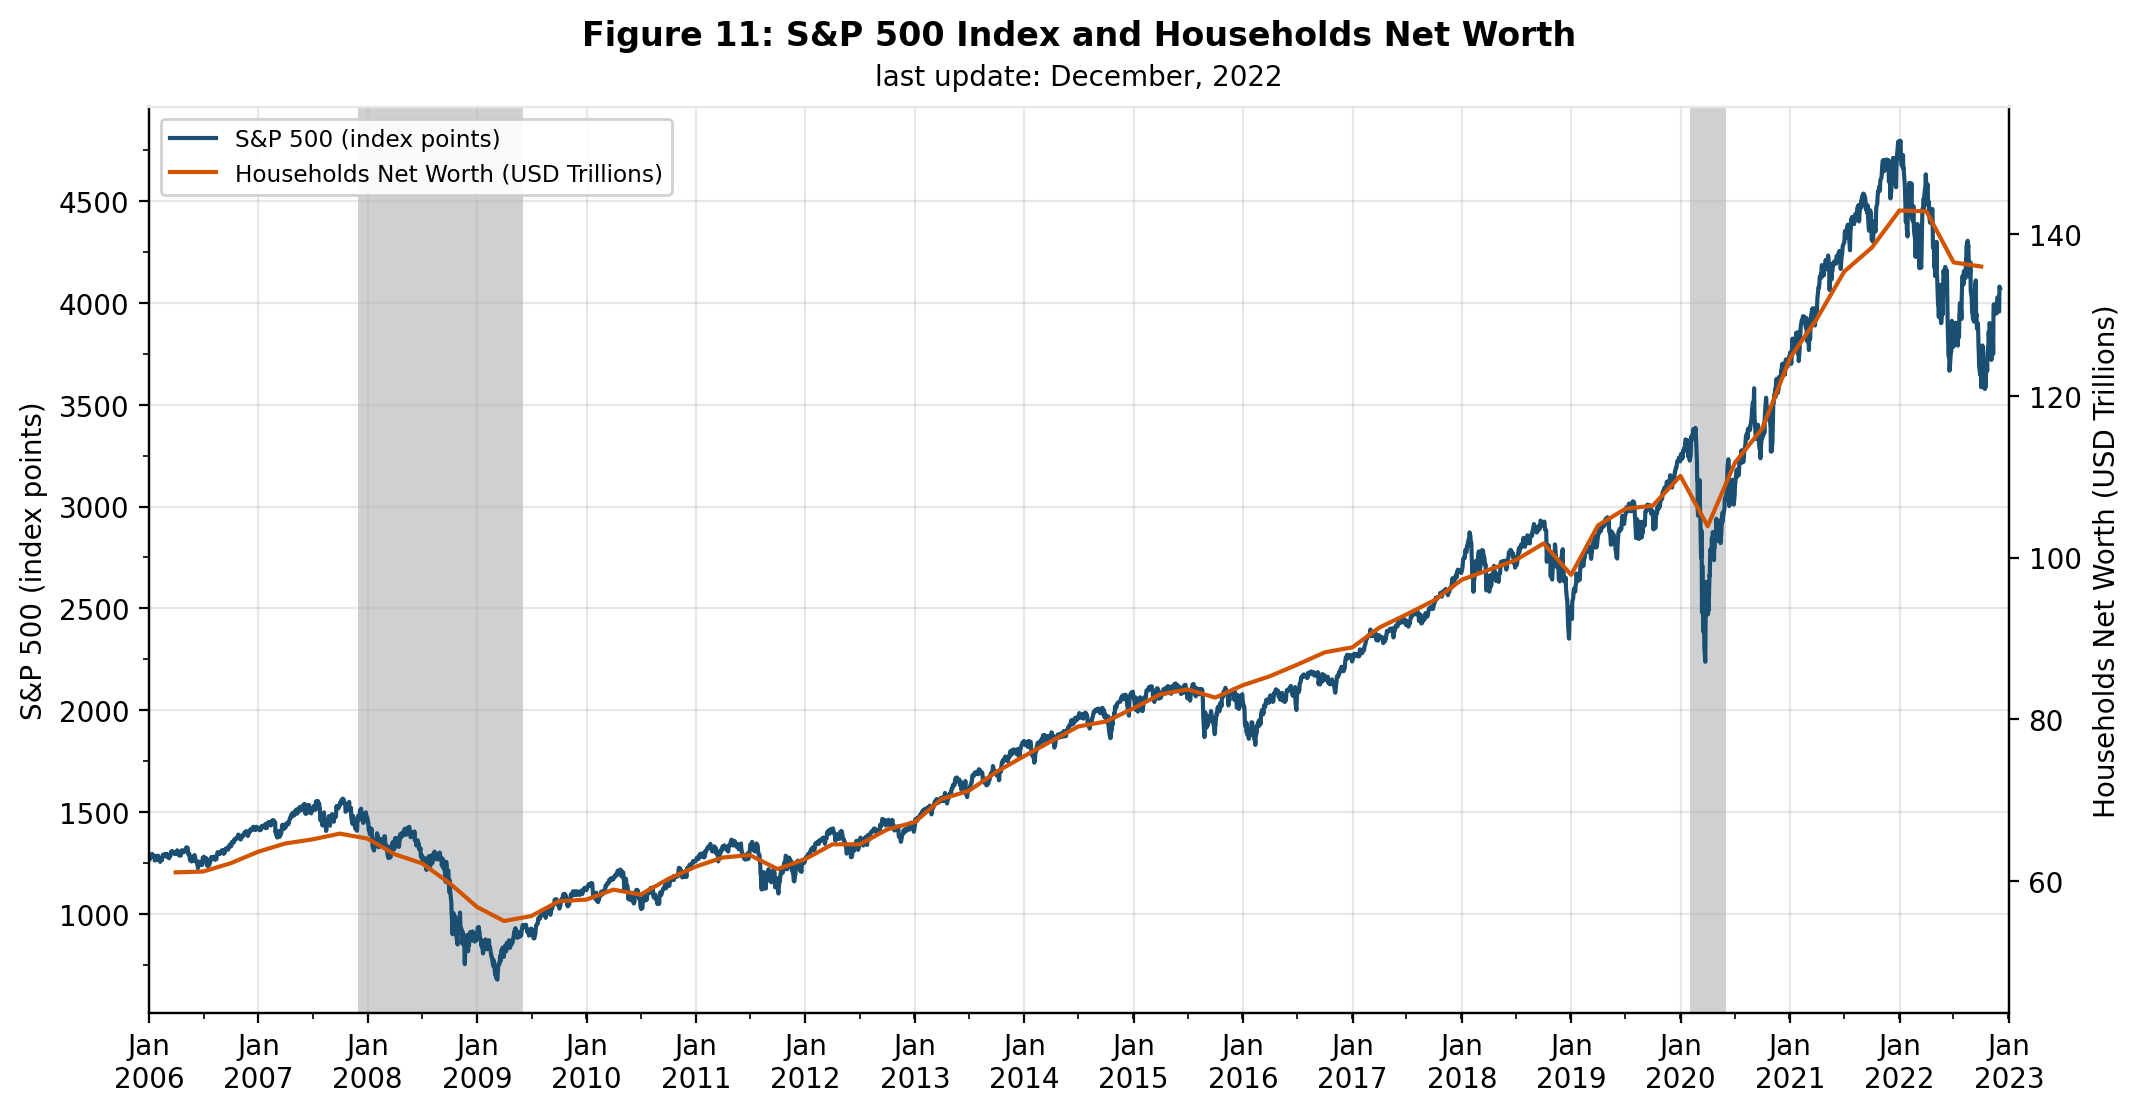

In [21]:
# snp x households net worth
# S&P500
data = (
    snp[snp["series_id"].isin(["GSPC"])]
    .copy()
    .replace(["GSPC"],
             ["S&P 500 Index"])
)

nw = hh_netwoth.copy()[["series_id","date","value"]]
nw["value"] = round(nw["value"]/1000000,1) 
nw["series_id"] = "Households Net Worth (Trillions of Dollars)"
nw["date"] = nw["date"] + pd.DateOffset(months=3)
nw["date"] = nw["date"] - pd.Timedelta(days=1)

fig, ax = dual_ts_plot(df = pd.concat([data, nw]),
                       series1 = "S&P 500 Index", series2 = "Households Net Worth (Trillions of Dollars)",
                       start_date = "2006-01-01",
                       title = "Figure 11: S&P 500 Index and Households Net Worth",
                       ly_label = "S&P 500 (index points)",
                       ry_label = "Households Net Worth (USD Trillions)",
                       fig_size = (12,6), legend_loc = "upper left",
                       plot_recession = True, hline = False, hline_loc = 0,
                       xmargin = 0.01, ymargin = 0.04,
                       y_major_loc = 500, y_minor_loc = 2,
                       x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n = 30)

plt.show()

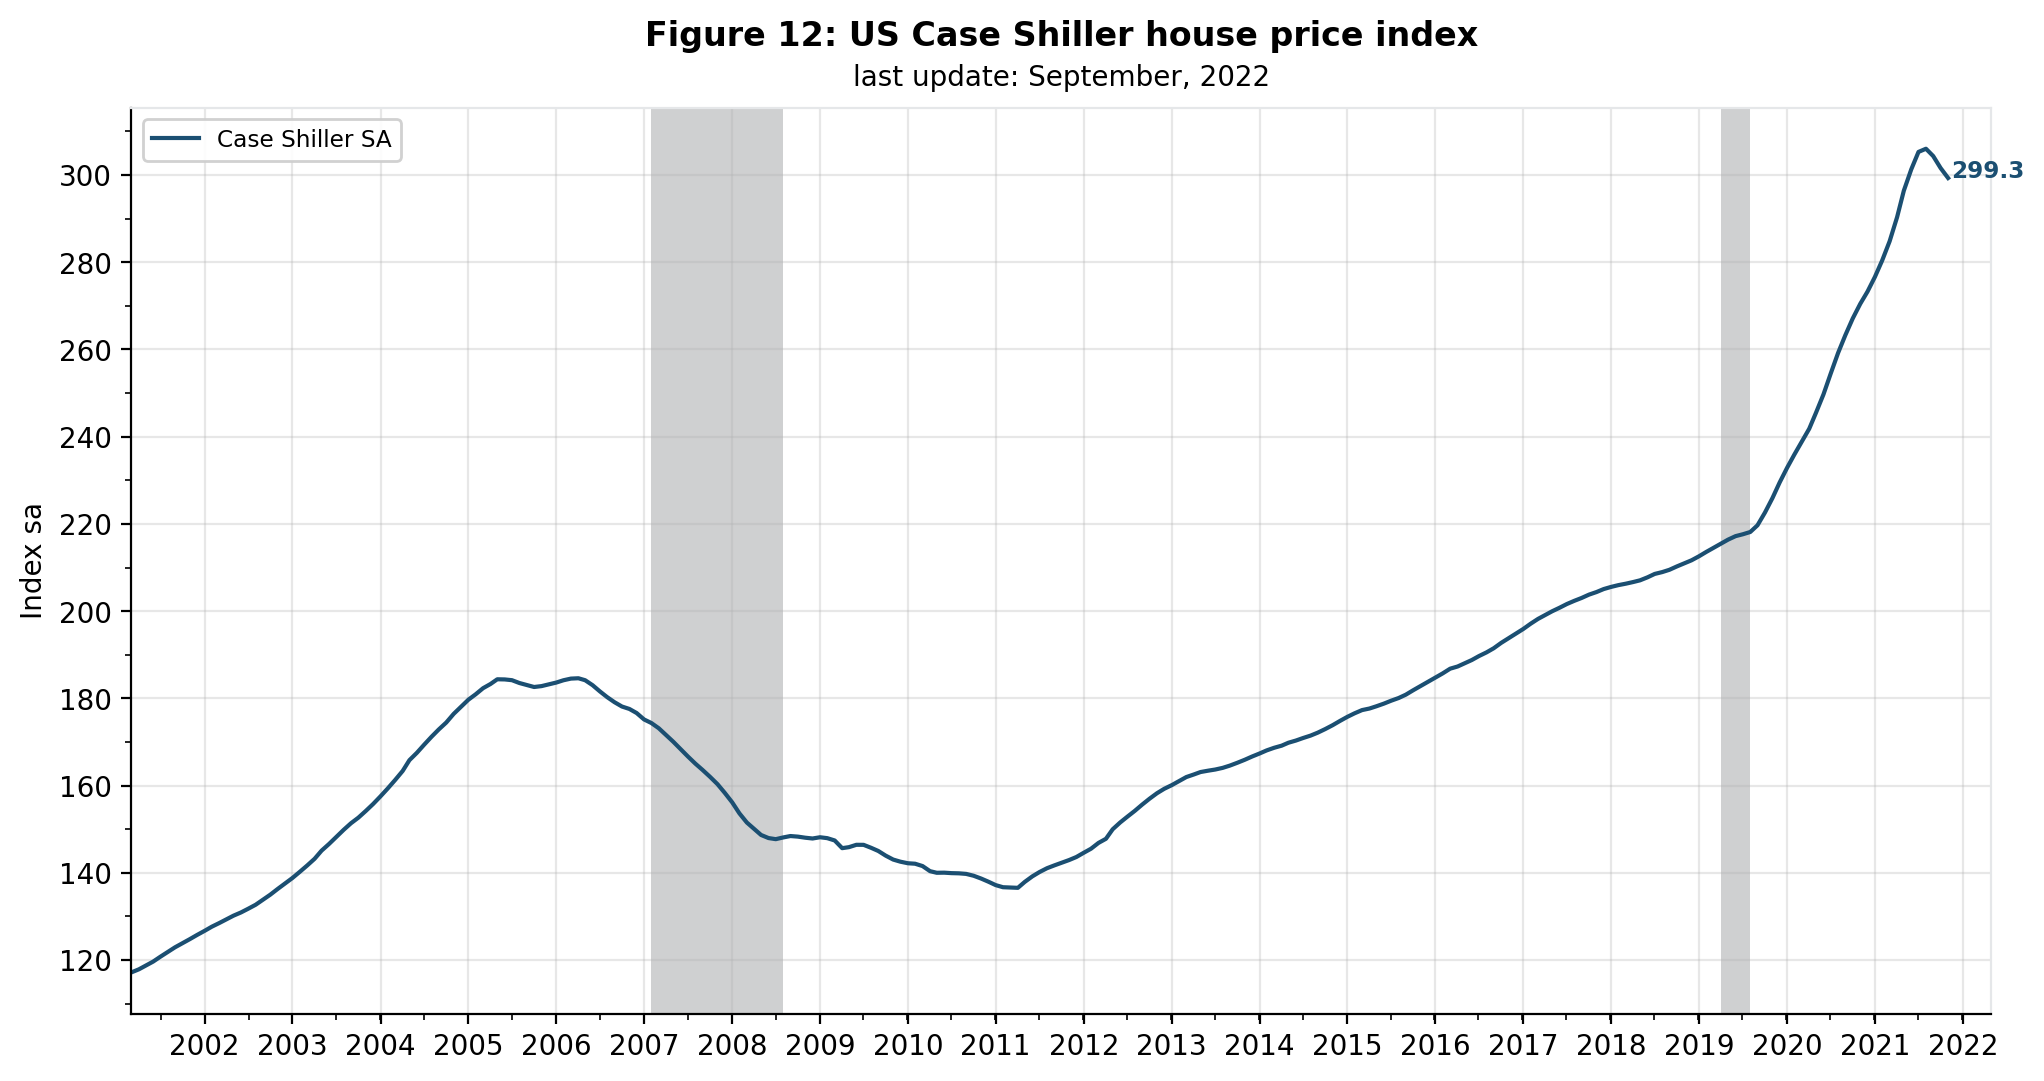

In [22]:
cs.tail()

data = cs[cs["series_id"]
                 .isin(["CSUSHPISA"])].copy()
data["series_id"] = (
    data["series_id"]
    .replace(["CSUSHPISA"],
             ["Case Shiller SA"])
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Case Shiller SA"],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2002-01-01",
                  title ='Figure 12: US Case Shiller house price index',
                  ylab='Index sa',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 20, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=180)

plt.show()

With economic activity on the rise, and the reopening process still slow, several imbalances between supply and demand began to exist, as shown by the components of the PMIs for delivering time in Graph 13, which rose sharply between 2020 and 2021, and only in recent months have begun to slow down.

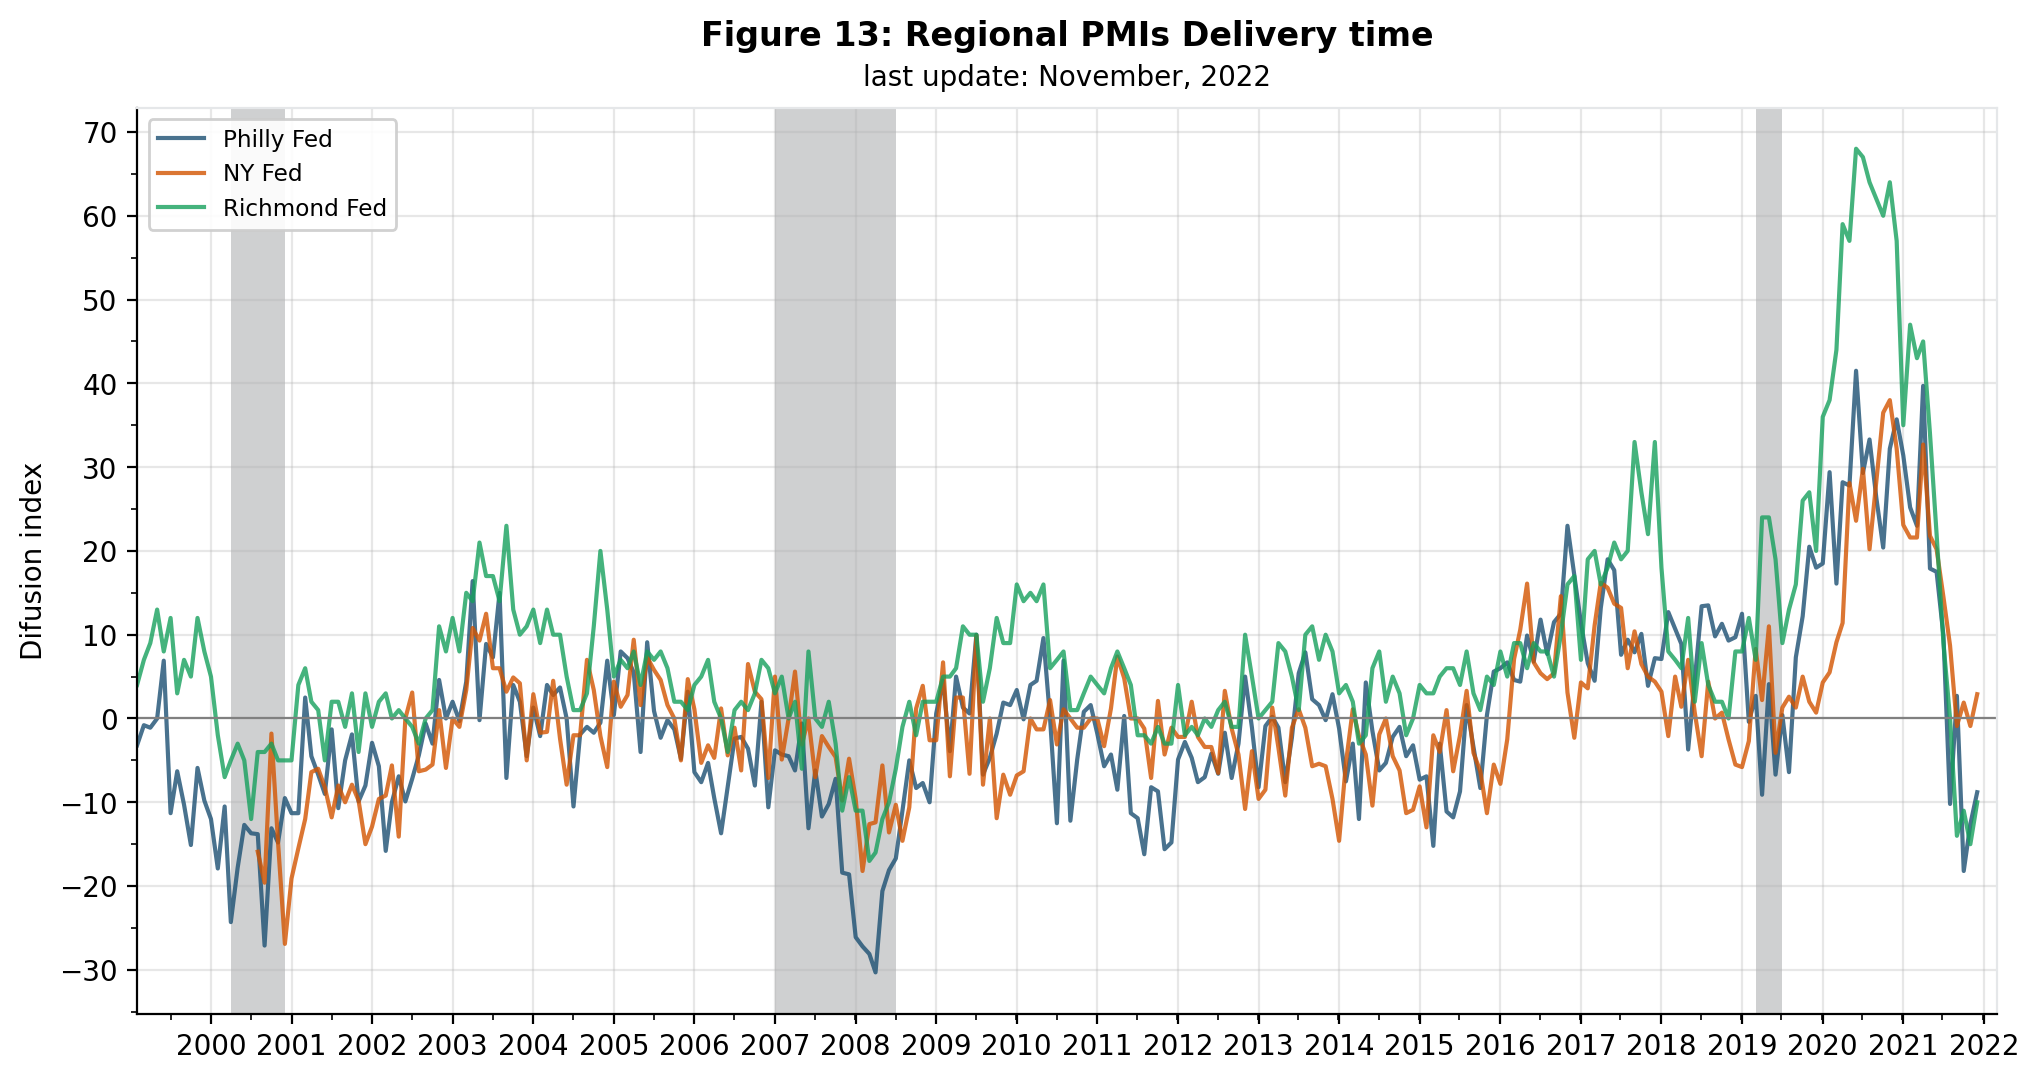

In [23]:
# dtcdfsa Delivery Time (current) philly
# dtcdisa Delivery Time (current) empire
# sa_mfg_vend_lead_c Vendor Lead Time (current) richmond
data_philly = philly[philly["series_id"]=="dtcdfsa"].copy().replace("dtcdfsa","Philly Fed")
data_empire = empire[empire["series_id"]=="dtcdisa"].copy().replace("dtcdisa","NY Fed")
data_rich = richmond[richmond["series_id"]=="sa_mfg_vend_lead_c"].copy().replace("sa_mfg_vend_lead_c","Richmond Fed")

data = pd.concat([data_philly,data_empire,data_rich])

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Philly Fed","NY Fed","Richmond Fed"],
    'hue': [colors[0],colors[1],colors[2]],
    'alpha':[0.8,0.8,0.8],
    'annotation':[False,False,False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2000-01-01",
                  title ='Figure 13: Regional PMIs Delivery time',
                  ylab='Difusion index',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = True, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 10, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()


The problems in the supply chains were the Fed's main argument supporting the narrative that the inflation surge was based on transitory factors. For Fed members, the slow recovery in the labor market demanded continuity of stimulus. The problem was that most of the stimulus provided incentives for workers to not return to the labor market. Perhaps the most relevant stimulus in this regard was the extension of unemployment aid programs, which often paid amounts higher than the salaries previously received by low-paid workers. Graph 14a shows the total number of people receiving the usual unemployment benefits program to give a historical perspective on how the number of beneficiaries increases during recessions. Graph 14b shows this same number added to the number of people receiving aid from emergency programs after 2020. Emergency programs lasted until September 2021, when a large part of the population was already vaccinated, and the economy was fully heated for a few months.

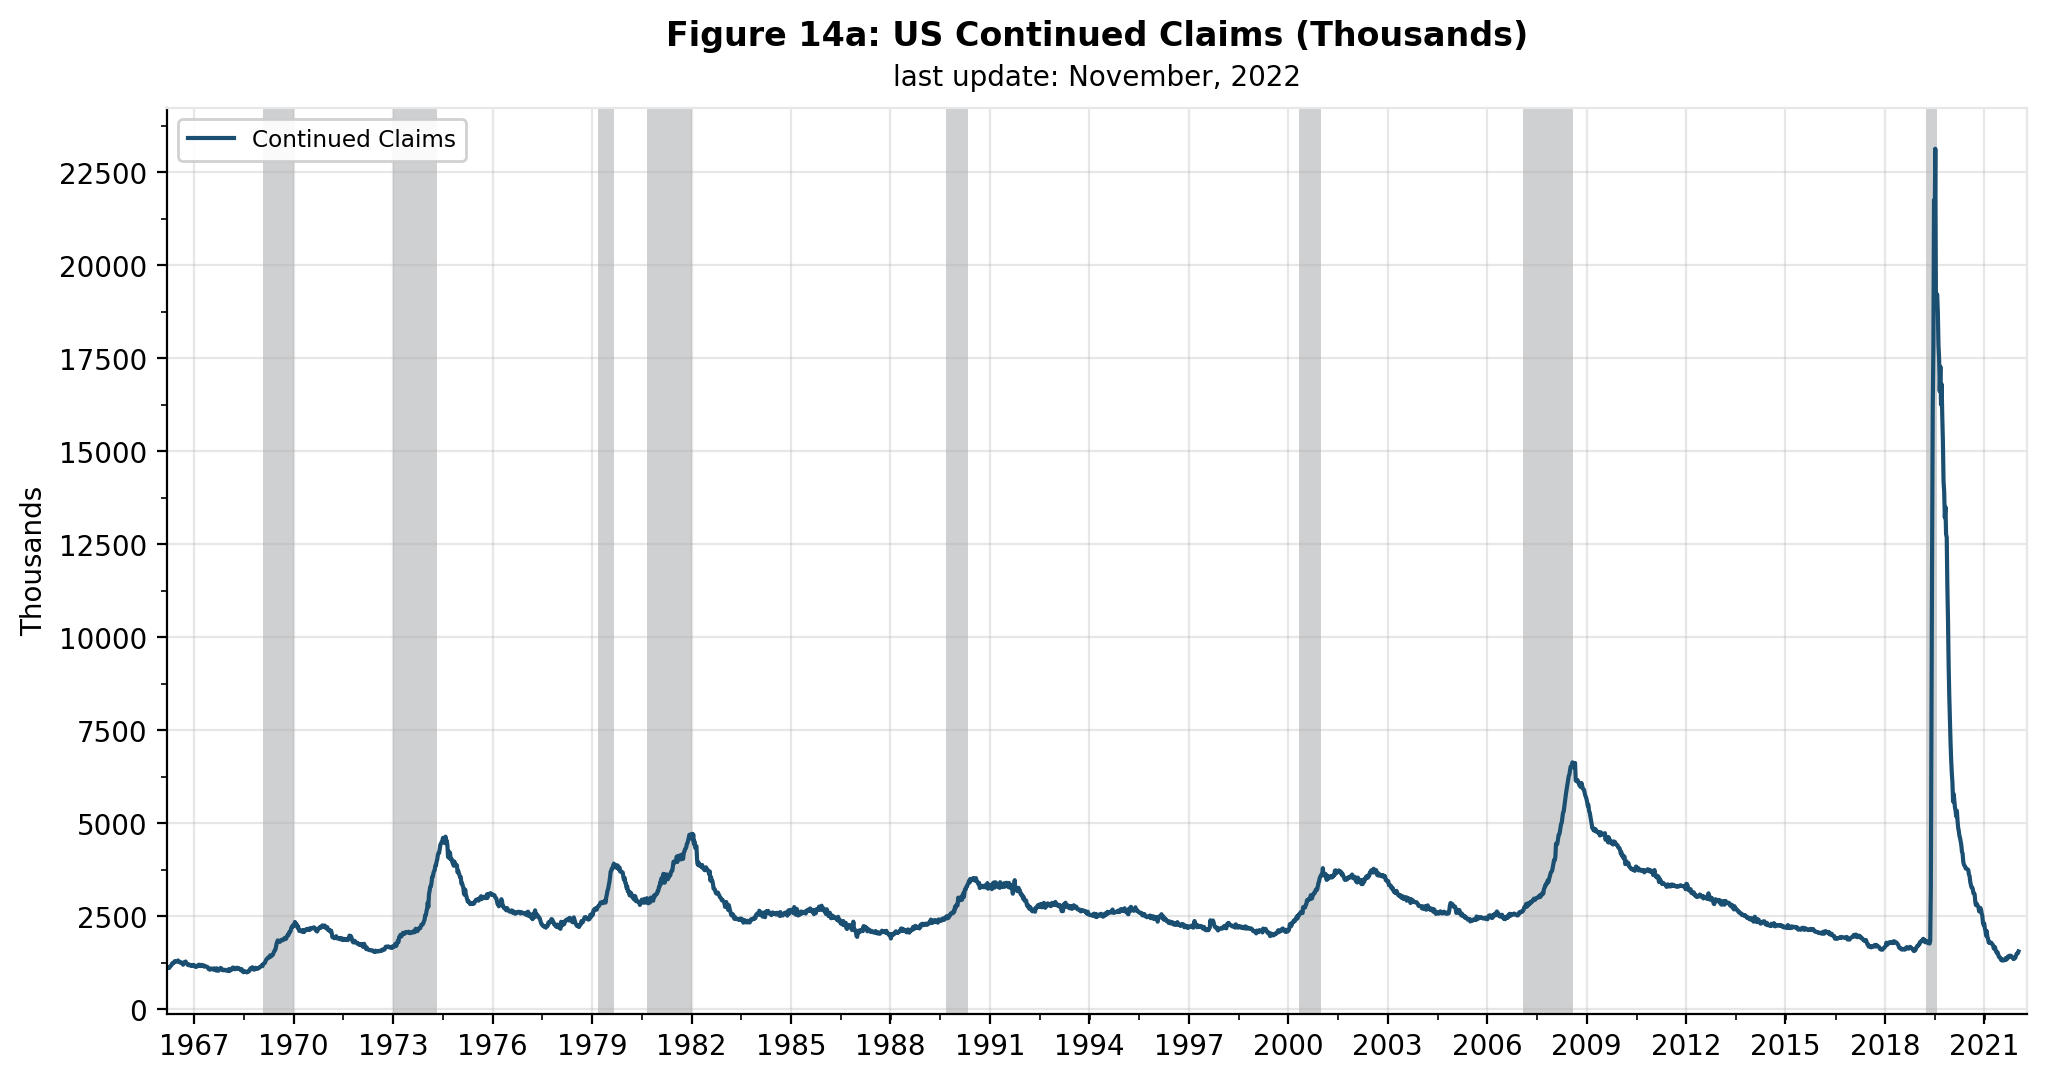

In [24]:
# Continued Claims
data = (
    claims[claims["series_id"]=="CCSA"]
    .copy()
    .replace("CCSA","Continued Claims")[["series_id","date","value"]]
)

data["value"] = data["value"]/1000

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Continued Claims'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1967-01-01",
                  title ='Figure 14a: US Continued Claims (Thousands)',
                  ylab='Thousands',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 2500, y_minor_loc = 2,
                  x_major_loc = 36, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

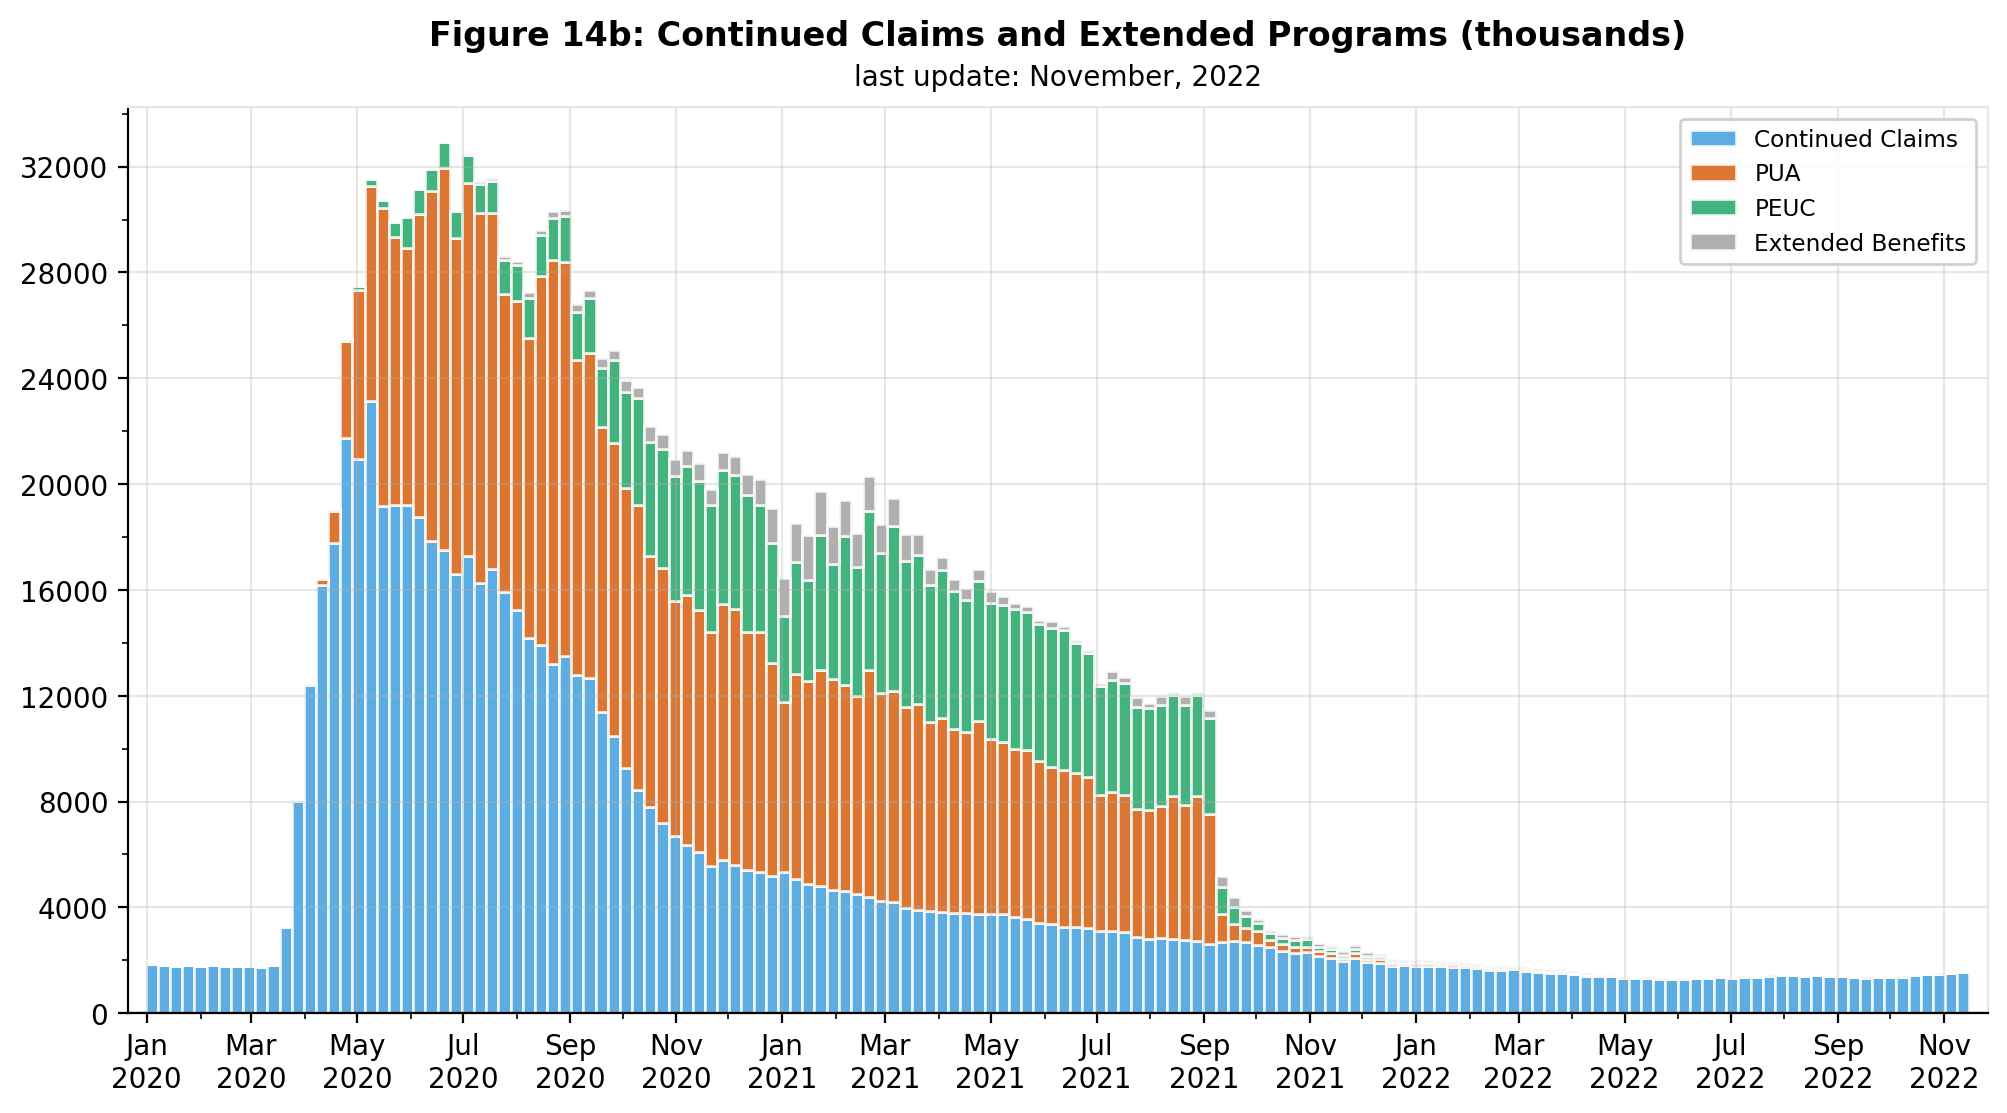

In [25]:
# continued claims+ extended benefits
c_claims = (
    claims[claims["series_id"]=="CCSA"]
    .copy()
    .rename(columns={"value":"Continued Claims"})[["date","Continued Claims"]]
)

c_claims = pd.merge(c_claims, eb, how="left")
c_claims = c_claims[c_claims["date"]>="2020"]

c_claims["Continued Claims"] = c_claims["Continued Claims"]/1000
c_claims["Extended Benefits"] = c_claims["Extended Benefits"]/1000
c_claims["PUA"] = c_claims["PUA"]/1000
c_claims["PEUC"] = c_claims["PEUC"]/1000

# chart:
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(12,6))

# positive values
ax.bar(c_claims["date"], c_claims["Continued Claims"],
       width = 7, label="Continued Claims", color= colors[4], alpha=0.8,
       edgecolor = 'white', linewidth = 1)

ax.bar(c_claims["date"], c_claims["PUA"], width = 7,
       bottom = c_claims["Continued Claims"], label="PUA", color= colors[1], alpha=0.8,
       edgecolor = 'white', linewidth = 1)

ax.bar(c_claims["date"], c_claims["PEUC"], width = 7,
       bottom = c_claims["Continued Claims"]+c_claims["PUA"], label="PEUC", color= colors[2], alpha=0.8,
       edgecolor = 'white', linewidth = 1)

ax.bar(c_claims["date"], c_claims["Extended Benefits"], width = 7,
       bottom = c_claims["Continued Claims"]+c_claims["PUA"]+c_claims["PEUC"], label="Extended Benefits",
       color= colors[5], alpha=0.8,
       edgecolor = 'white', linewidth = 1)

ax.legend(['Continued Claims', 'PUA','PEUC', 'Extended Benefits'], 
    loc='upper right', frameon=True, framealpha=0.9, fontsize='small')

ax.axhline(y=0, color='gray', lw=0.8, label = "_line")

ax.margins(x=0.01, y=0.04)

# date axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

year_month_formatter = mdates.DateFormatter("%b\n%Y")
ax.xaxis.set_major_formatter(year_month_formatter)

# y axis
ax.yaxis.set_major_locator(MultipleLocator(4000))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylabel(None)

#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.spines['top'].set_edgecolor(colors[107])
ax.spines['right'].set_edgecolor(colors[107])

ax.grid(axis='y', alpha=0.3)
ax.grid(axis='x', alpha=0.3)

ax.set_title('Figure 14b: Continued Claims and Extended Programs (thousands)', y=1.05, loc="center",
            fontweight="bold")

# subtitle...
last = c_claims.loc[c_claims['date']==max(c_claims['date']),:]

ax.xaxis.set_label_position('top')
text = last["date"].dt.strftime("%B, %Y").values[0]

ax.set_xlabel(f"last update: {text}",
              labelpad = 8, loc="center")

plt.show()

Several indicators show how difficult it was to find qualify workers at that time, as can be seen from the NFIB data in chart 15.

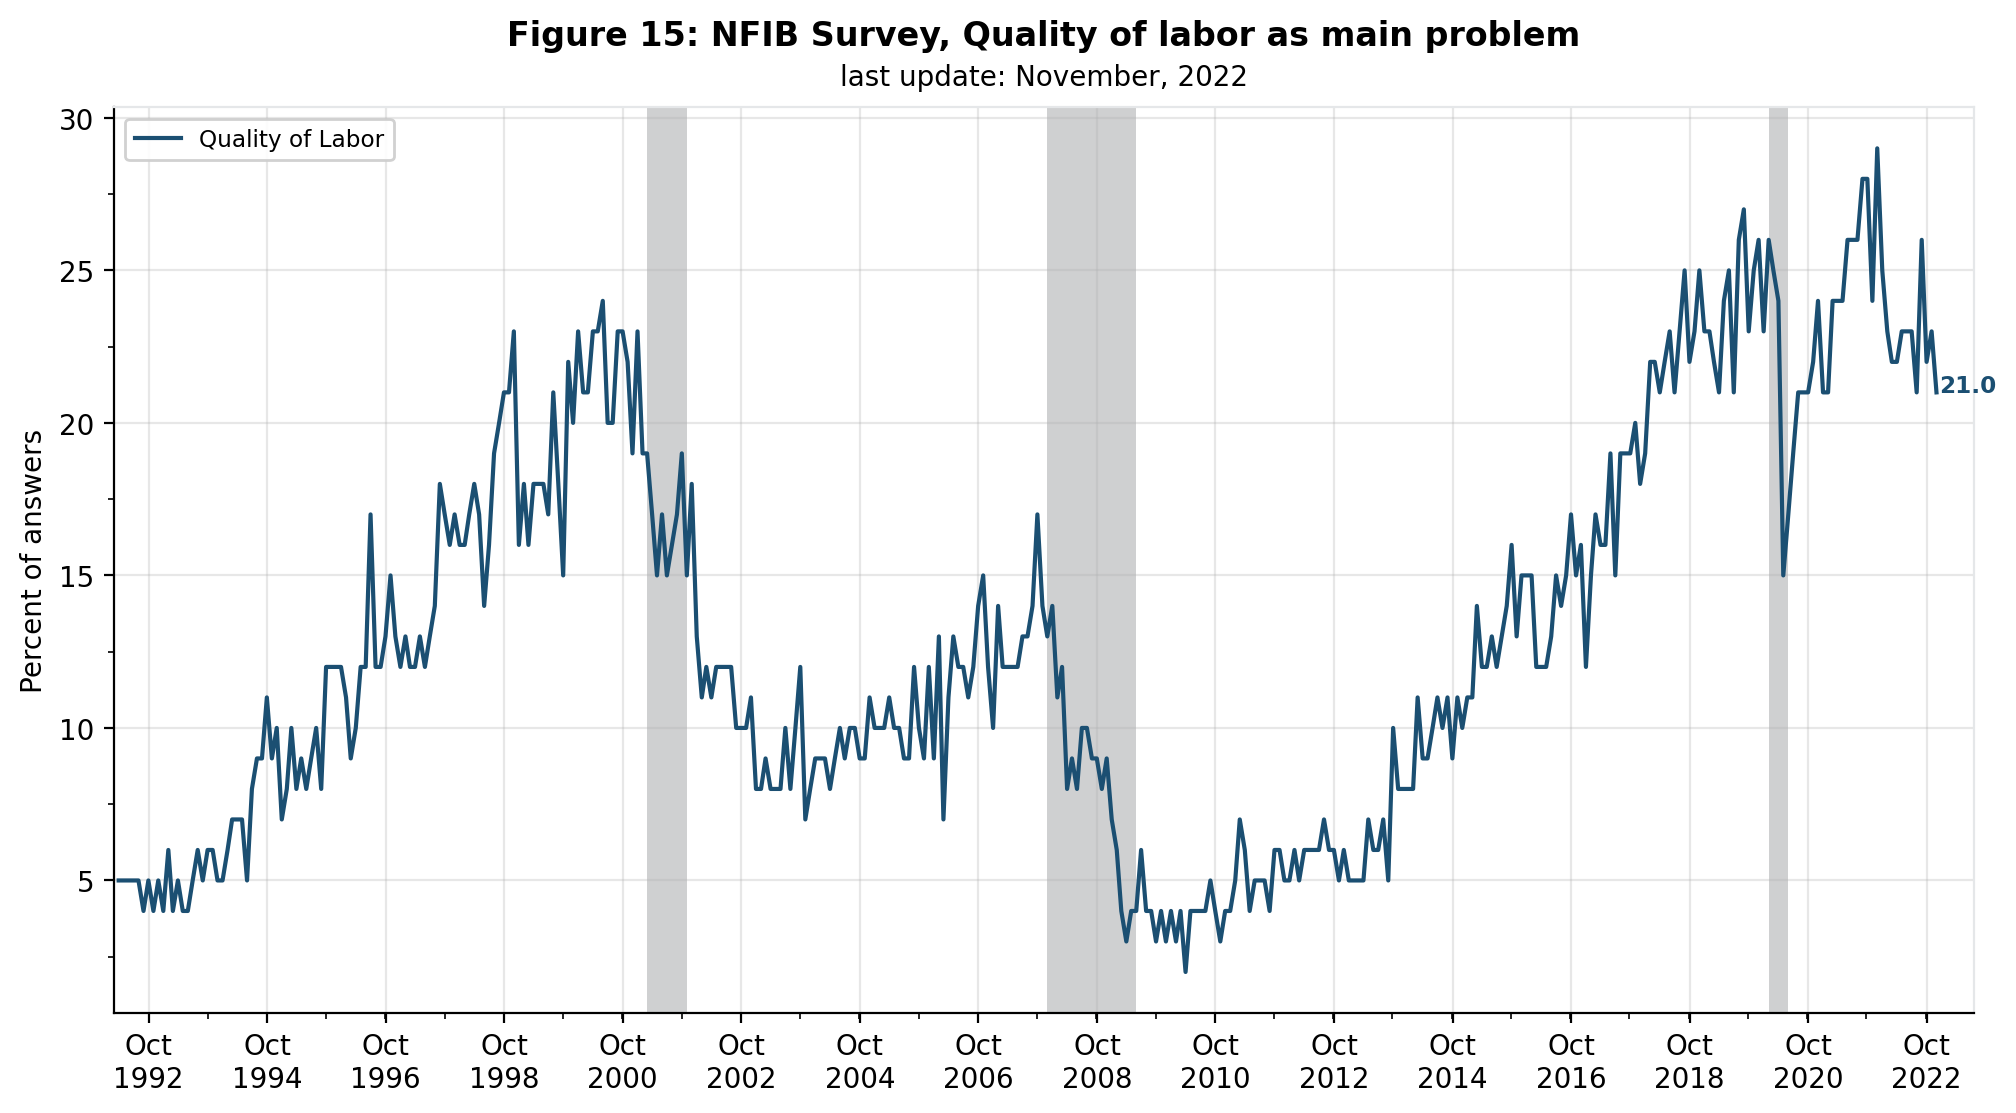

In [26]:
#NFIB_NFIB Qualified Applicants for Job Openings_SA_Diffusion
data = (
    nfib[nfib["series_id"].isin(["NFIB_Quality of Labor_NSA_Percent"])]
    .copy().replace("NFIB_Quality of Labor_NSA_Percent","Quality of Labor")[["series_id","date","value"]]
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Quality of Labor"],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1992-03-01",
                  title ='Figure 15: NFIB Survey, Quality of labor as main problem',
                  ylab='Percent of answers',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 5, y_minor_loc = 2,
                  x_major_loc = 24, x_minor_loc = 2, x_format = "%b\n%Y", n=230)

plt.show()

With the shortage of workers, wage inflation began to rise rapidly, as shown by the Atlanta Fed data (chart 16). This data is interesting because it allows us to analyze the composition of the indicator. In Graph 17 we have wage inflation for workers who change jobs and workers who remain in the same position. The strongest rise in the first group shows that workers were leaving to occupy higher-paying positions.

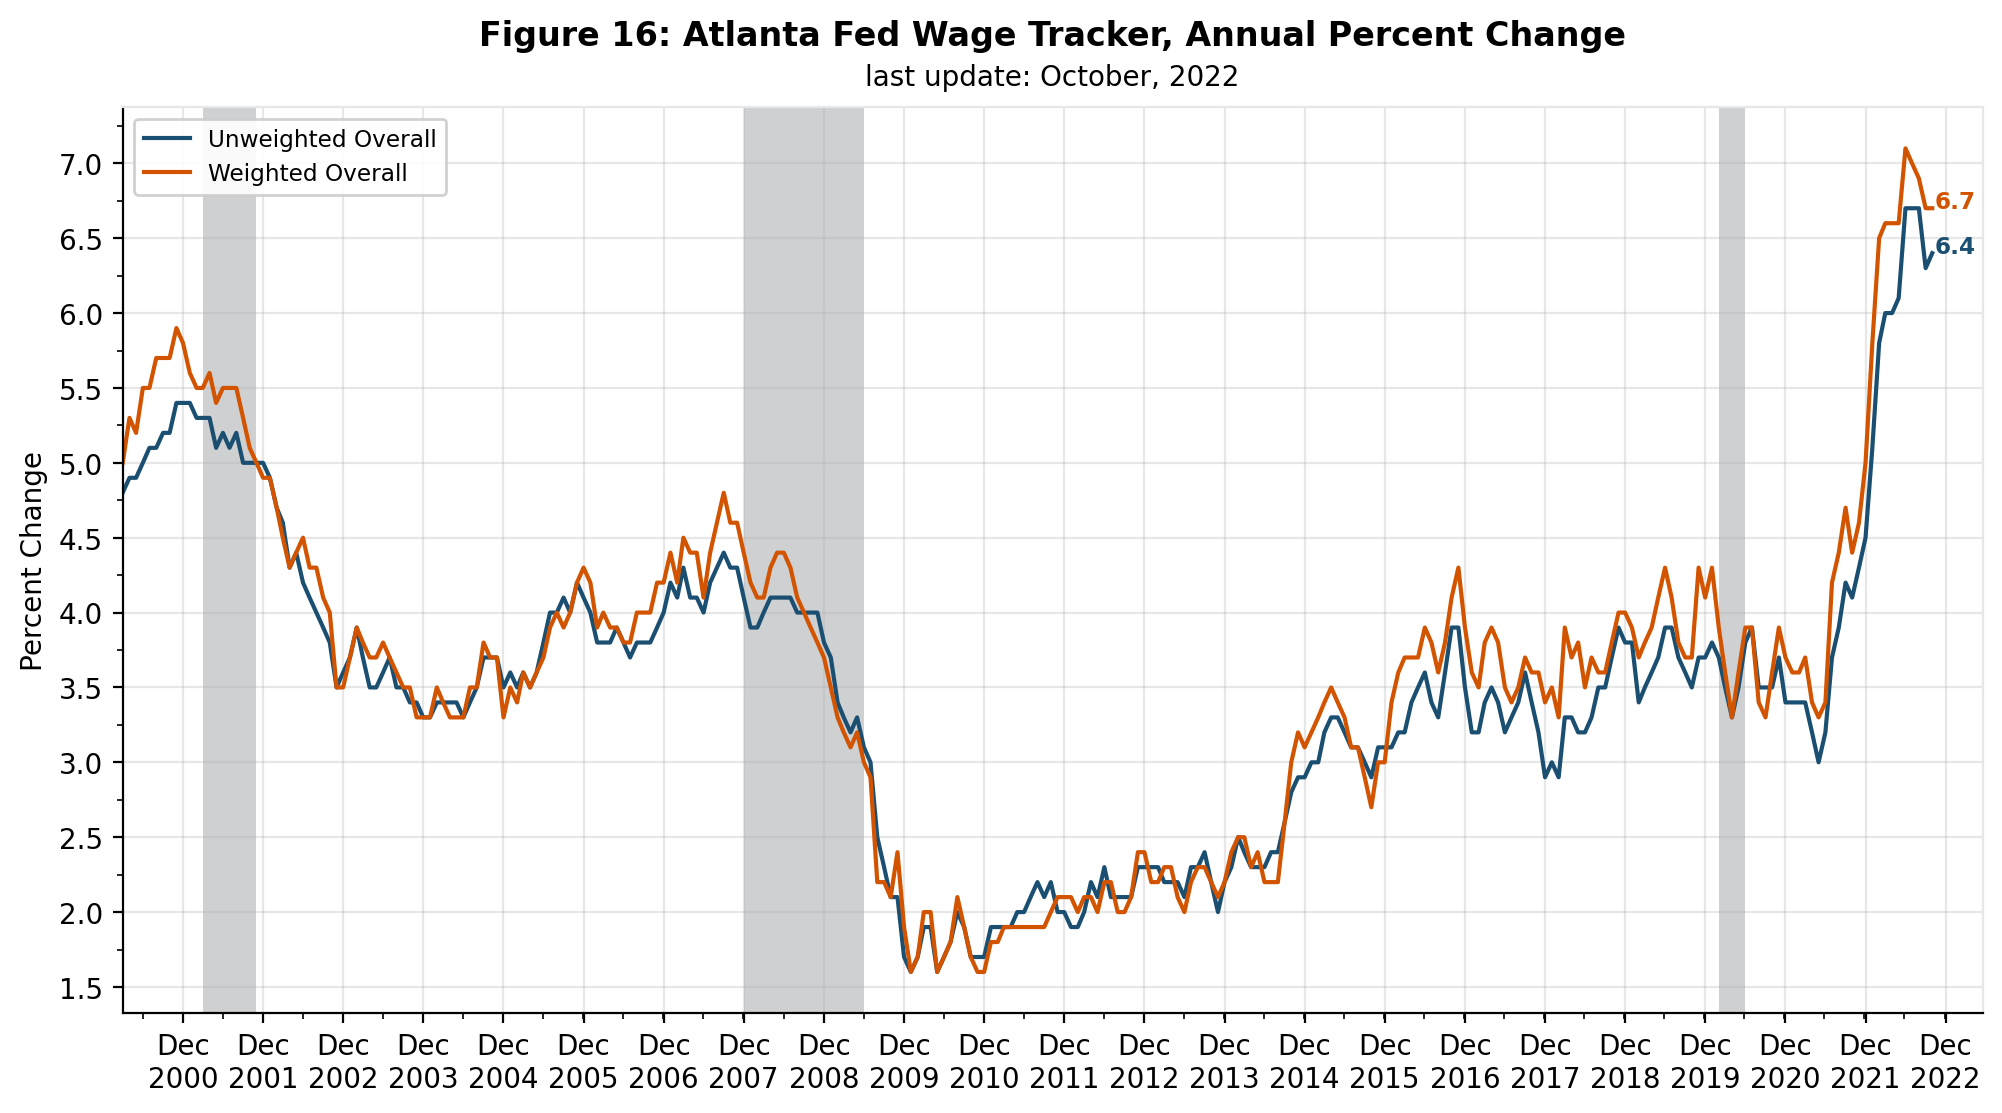

In [27]:
# Atlanta Fed Wage Tracker
data = (
    wage[wage["series_id"].isin(["Unweighted Overall","Weighted Overall"])]
    .copy()
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Unweighted Overall","Weighted Overall"],
    'hue': [colors[0],colors[1]],
    'alpha':[1,1],
    'annotation':[True, True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2000-03-01",
                  title ='Figure 16: Atlanta Fed Wage Tracker, Annual Percent Change',
                  ylab='Percent Change',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 0.5, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n=230)

plt.show()

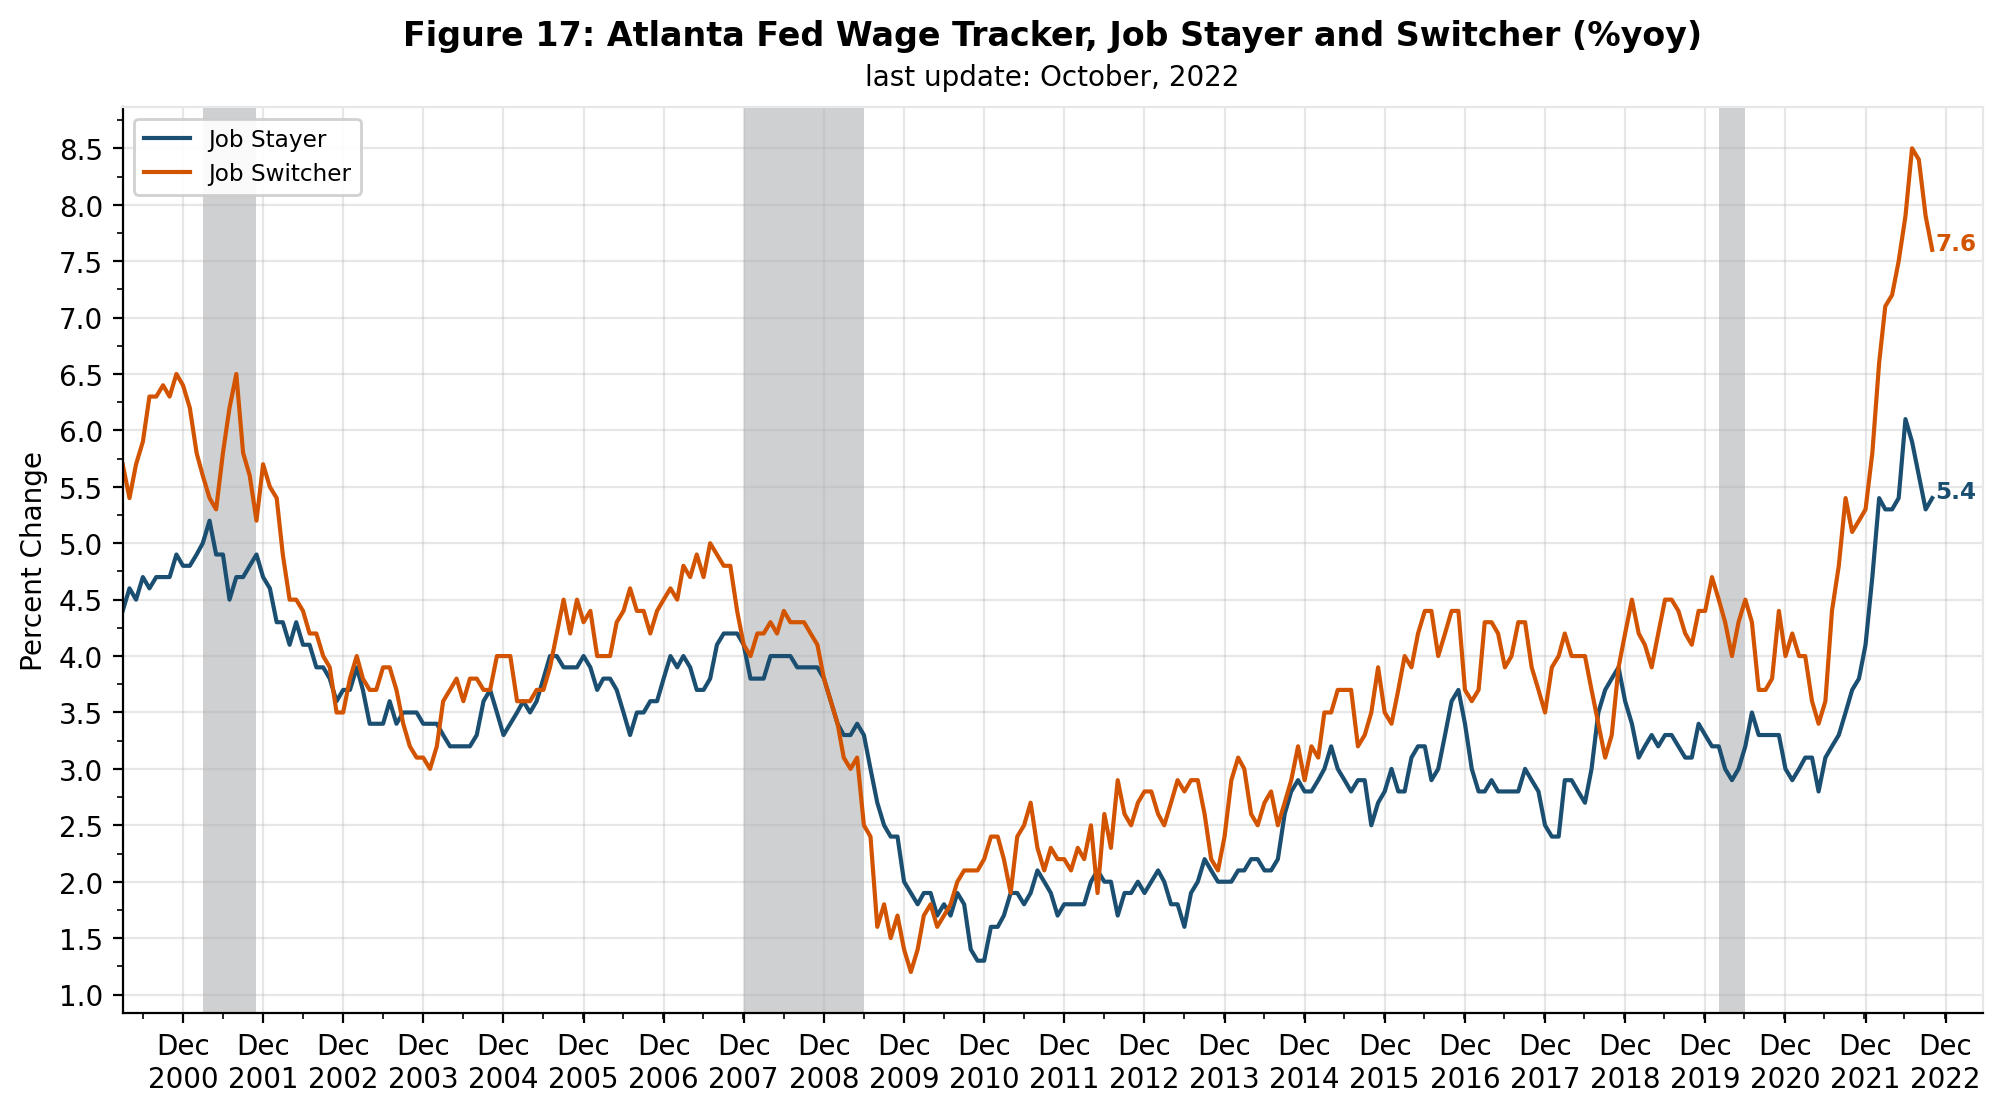

In [28]:
#Job Stayer
#Job Switcher

data = (
    wage[wage["series_id"].isin(["Job Stayer","Job Switcher"])]
    .copy()
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Job Stayer","Job Switcher"],
    'hue': [colors[0],colors[1]],
    'alpha':[1,1],
    'annotation':[True, True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2000-03-01",
                  title ='Figure 17: Atlanta Fed Wage Tracker, Job Stayer and Switcher (%yoy)',
                  ylab='Percent Change',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 0.5, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n=230)

plt.show()


### The outcomes for inflation

Before starting the analysis on inflation, it is worth mentioning that although the Fed uses the Core PCE metric as the target, the focus here will be the CPI, which is usually the most relevant data to monitor when it comes to inflation in the United States. In general, the CPI is preferred because it is widely known, but also because it is released three to four weeks before the PCE. This difference seems subtle but is actually quite relevant since a large part of the PCE can be inferred with CPI components, which means that when we get to know the PCE data, it usually comes without surprises.

Graph 18 shows the evolution of inflation measured by the CPI and the Core CPI from 1960 to October 2022, using two metrics: the annual percent change, normally abbreviated as yoy, and the annualized quarterly percent change, abbreviated as 3msaar (3 months seasonally adjusted annual rate). After inflation was brought under control in the mid-1980s, US inflation entered a new regime, where it became lower and less volatile. This behavior lasted even in the years before the pandemic when the unemployment rate renewed at historic lows, and the Fed continued to struggle to raise inflation to the 2% target. That changed in mid-2021 when inflation rose sharply, reaching levels not seen for over forty years.


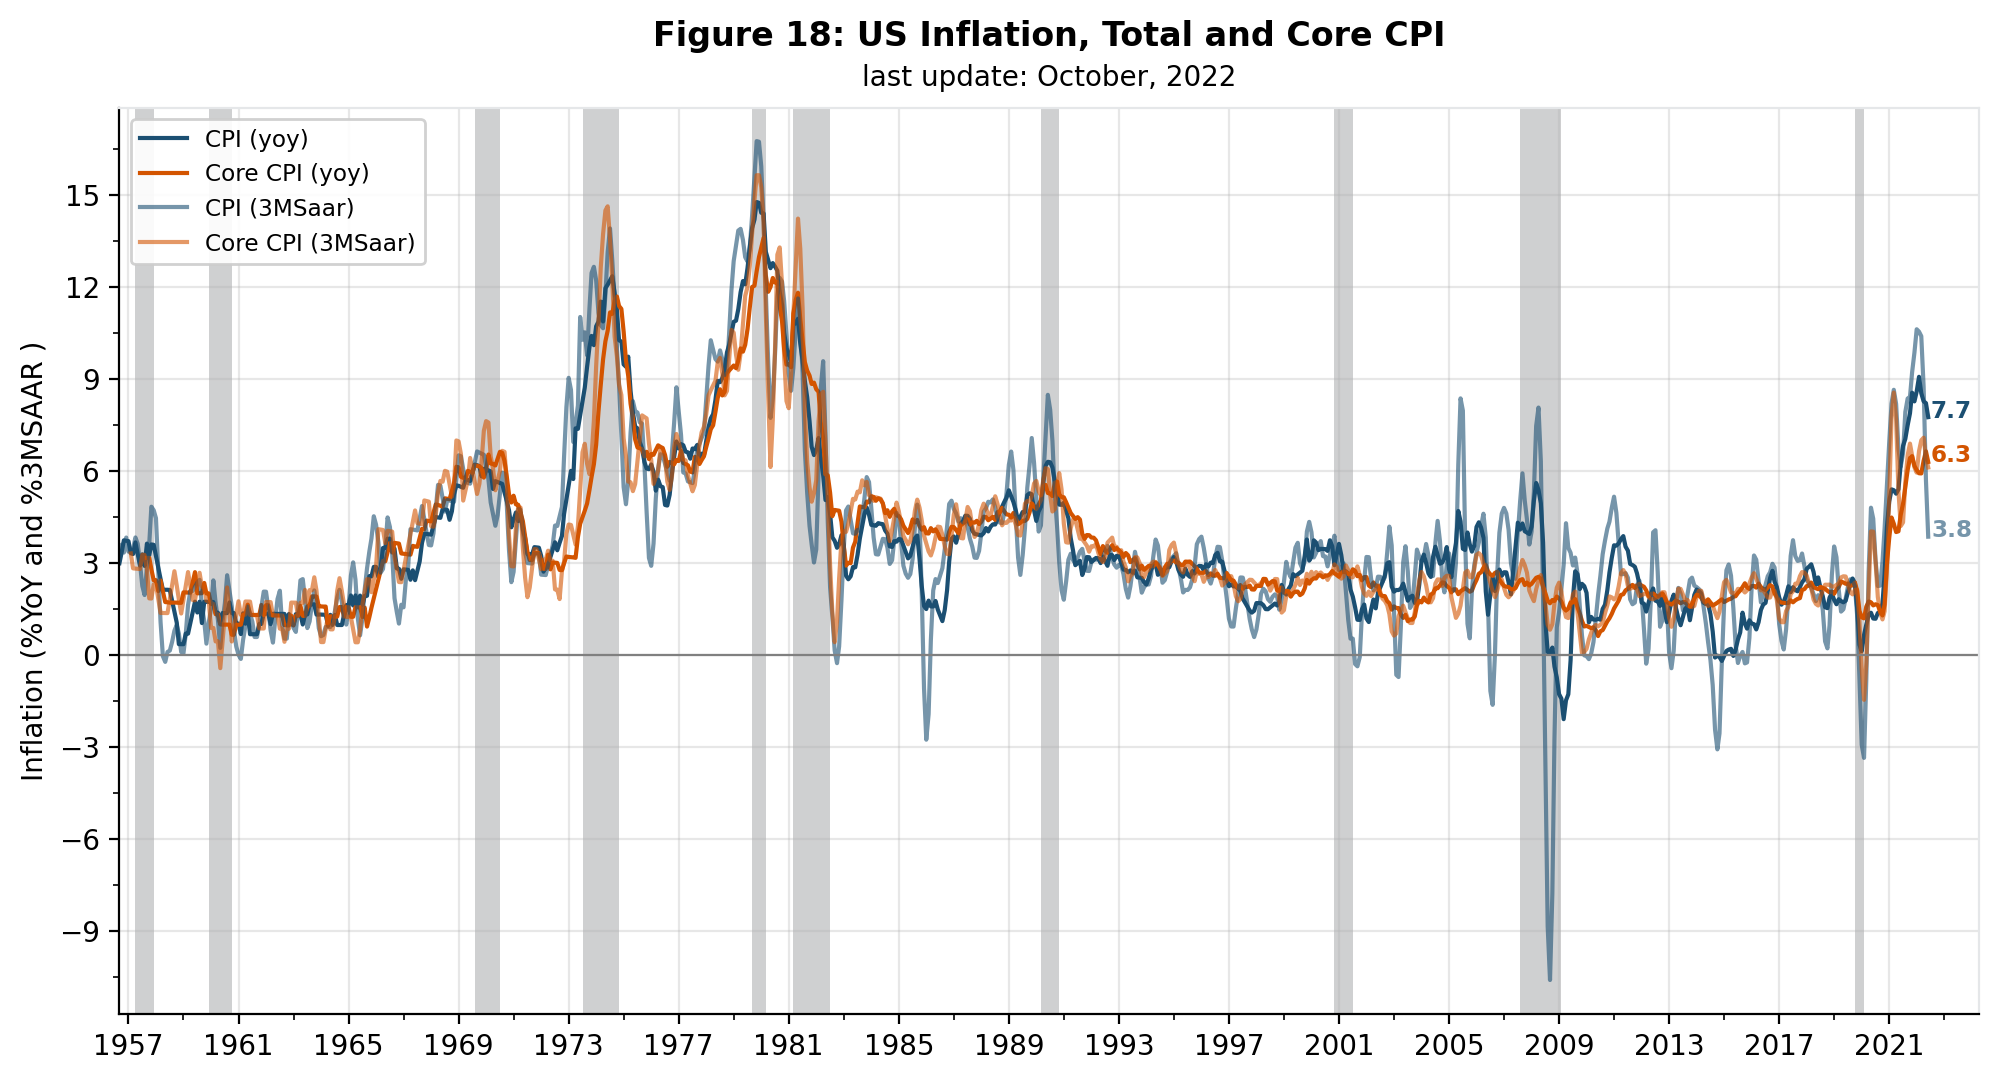

In [30]:
# cpi
cpi_yoy = cpi[cpi["series_id"].isin(["CUUR0000SA0", "CUUR0000SA0L1E"])].copy().reset_index()
cpi_yoy = compute_change(cpi_yoy, n=12).replace(["CUUR0000SA0","CUUR0000SA0L1E"],["CPI (yoy)","Core CPI (yoy)"])
cpi_saar = cpi[cpi["series_id"].isin(["CUSR0000SA0", "CUSR0000SA0L1E"])].copy().reset_index()
cpi_saar = saar(cpi_saar, n = 3).replace(["CUSR0000SA0","CUSR0000SA0L1E"],["CPI (3MSaar)", "Core CPI (3MSaar)"])

#plt.rcParams['figure.dpi'] = 200

df_code = pd.DataFrame({
    'series_id': ['CPI (yoy)','Core CPI (yoy)','CPI (3MSaar)','Core CPI (3MSaar)'],
    'hue': [colors[0], colors[1], colors[0], colors[1]],
    'alpha':[1, 1, 0.6, 0.6],
    'annotation':[True, True, True, False]})

fig, ax = ts_plot(df = pd.concat([cpi_yoy, cpi_saar]),
                  df_map = df_code,
                  start_date = "1957-01-01",
                  title ='Figure 18: US Inflation, Total and Core CPI',
                  ylab='Inflation (%YoY and %3MSAAR )',
                  plot_recession = True, hline = True, hline_loc = 0,
                  xmargin = 0.01, ymargin = 0.04,
                  y_major_loc = 3, y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n=680)

plt.show()

Inflation indices are composed of different groups that are sensitive to different sectors of the economy. The simplest way to disaggregate the CPI is by separating more volatile groups from less noisy groups, which are normally associated with the economic cycle. Although there are different ways to do this, the most traditional way is to separate the energy and food groups (non-core) from the so-called core group (services and industrial goods). Graph 19 shows the contribution of each of these three groups to the annual change in the CPI. The core, which represents more than 80% of the basket of products and services that make up the index, was quite stable before the start of the pandemic. For groups outside the core, food had little relevance for total inflation, while energy, despite representing only about 7% of the index, was largely responsible for the volatility in the index.

In [31]:
# Contribution
headline_contr = weights[weights["item_name"].isin(["Food","Energy","All items less food and energy"])]

# merge with series id
headline_contr = (
    pd.merge(
        headline_contr,
        metadata[metadata["seasonal"]=="U"][["series_id","item_name"]],
        how="left", on = ["item_name"])
)

# weights, 12m moving averages
headline_contr["weight"] = (
    headline_contr
    .sort_values("date")
    .groupby('series_id')['weight']
    .transform(lambda x: x.rolling(12,min_periods=1).mean())
) 

headline_contr = headline_contr.dropna()

# getting cpi data
# computing yoy changes
# merge result with df
headline_contr = (
    pd.merge(headline_contr,
             compute_change(
                 cpi[cpi["series_id"].isin(["CUUR0000SAF1","CUUR0000SA0E","CUUR0000SA0L1E"])],
                 n = 12),
             how="left", on=["date","series_id"])
)

# calculating contribution
headline_contr["value"] = (headline_contr["weight"]/100) * headline_contr["value"]
headline_contr["item_name"] = headline_contr["item_name"].replace("All items less food and energy","Core")
headline_contr.head()

# reshaping data:
headline_contr = (
    pd.pivot_table(
        headline_contr[["date","item_name","value"]],
        values="value", columns="item_name", index="date")
    .reset_index()
    .rename_axis(None,axis=1)
)

headline_contr.head()

test = headline_contr.copy()
test = test[["date","Core","Food","Energy"]]

yoy = cpi_yoy.loc[cpi_yoy["series_id"]=="CPI (yoy)",["series_id","date","value"]]
yoy = yoy[yoy["date"]>="2012-03-01"]

# test_positive
test_positive = test.copy()
test_positive.loc[test_positive["Core"] < 0 ,"Core"] = 0
test_positive.loc[test_positive["Food"] < 0 ,"Food"] = 0
test_positive.loc[test_positive["Energy"] < 0 ,"Energy"] = 0

# test_negative
test_negative = test.copy()
test_negative.loc[test_negative["Core"] >= 0 ,"Core"] = 0
test_negative.loc[test_negative["Food"] >= 0 ,"Food"] = 0
test_negative.loc[test_negative["Energy"] >= 0 ,"Energy"] = 0

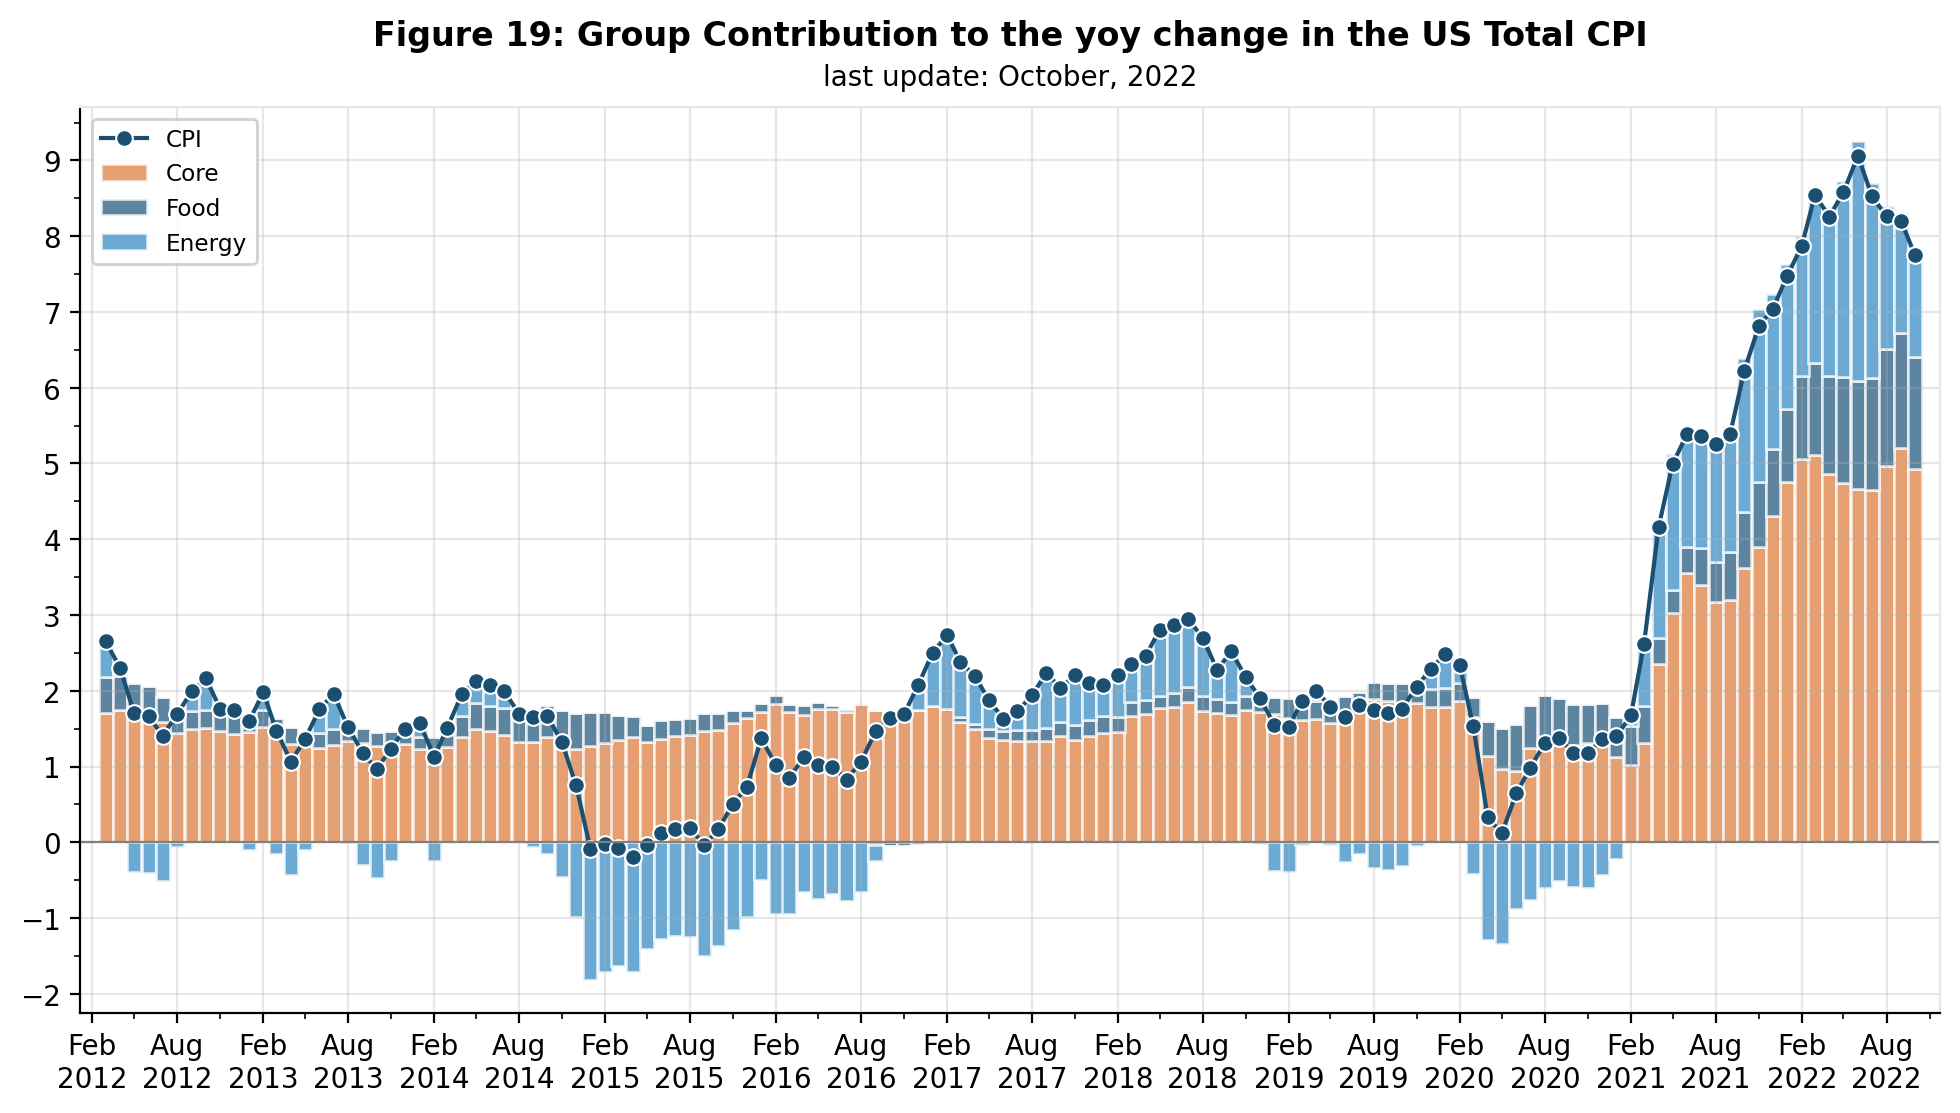

In [32]:
# chart:
#plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(12,6))

# positive values
ax.bar(test_positive["date"], test_positive["Core"], width = 30, label="Core", color= colors[75], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(test_positive["date"], test_positive["Food"], width = 30,
       bottom = test_positive["Core"], label="Food", color= colors[31], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(test_positive["date"], test_positive["Energy"], width = 30,
       bottom = test_positive["Food"]+test_positive["Core"], label="Energy", color= colors[43], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

# negative values
ax.bar(test_negative["date"], test_negative["Core"], width = 30, label="Core", color= colors[75], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(test_negative["date"], test_negative["Food"], width = 30,
       bottom = test_negative["Core"], label="Food", color= colors[31], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(test_negative["date"], test_negative["Energy"], width = 30,
       bottom = test_negative["Food"]+test_negative["Core"], label="Energy", color= colors[43], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

# line
sns.lineplot(data=yoy,
            x="date", y="value",
            color=colors[0], ax=ax, legend=False, marker="o")

ax.legend(['CPI', 'Core','Food', 'Energy'], 
    loc='upper left', frameon=True, framealpha=0.9, fontsize='small')

ax.axhline(y=0, color='gray', lw=0.8, label = "_line")

ax.margins(x=0.01, y=0.04)

# date axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))

year_month_formatter = mdates.DateFormatter("%b\n%Y")
ax.xaxis.set_major_formatter(year_month_formatter)

# y axis
ax.yaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylabel(None)

#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.spines['top'].set_edgecolor(colors[107])
ax.spines['right'].set_edgecolor(colors[107])

ax.grid(axis='y', alpha=0.3)
ax.grid(axis='x', alpha=0.3)

ax.set_title('Figure 19: Group Contribution to the yoy change in the US Total CPI', y=1.05, loc="center",
            fontweight="bold")

# subtitle...
last = test_positive.loc[test_positive['date']==max(test_positive['date']),:]

ax.xaxis.set_label_position('top')
text = last["date"].dt.strftime("%B, %Y").values[0]

ax.set_xlabel(f"last update: {text}",
              labelpad = 8, loc="center")

plt.show()

The reopening and the supply problems had a strong impact on the prices of agricultural commodities, but mainly on oil, a movement that intensified with the beginning of the conflict between Russia and Ukraine in early 2022. After the sharp rise, the prospect of a slowdown in global economic activity, due to the monetary tightening that started this year, has brought down the price of commodities, causing the energy component of the CPI to continue to decline in the coming months, as shown in graph 20, which compares the annual variation of weekly gasoline prices in the United States States with annual CPI inflation.

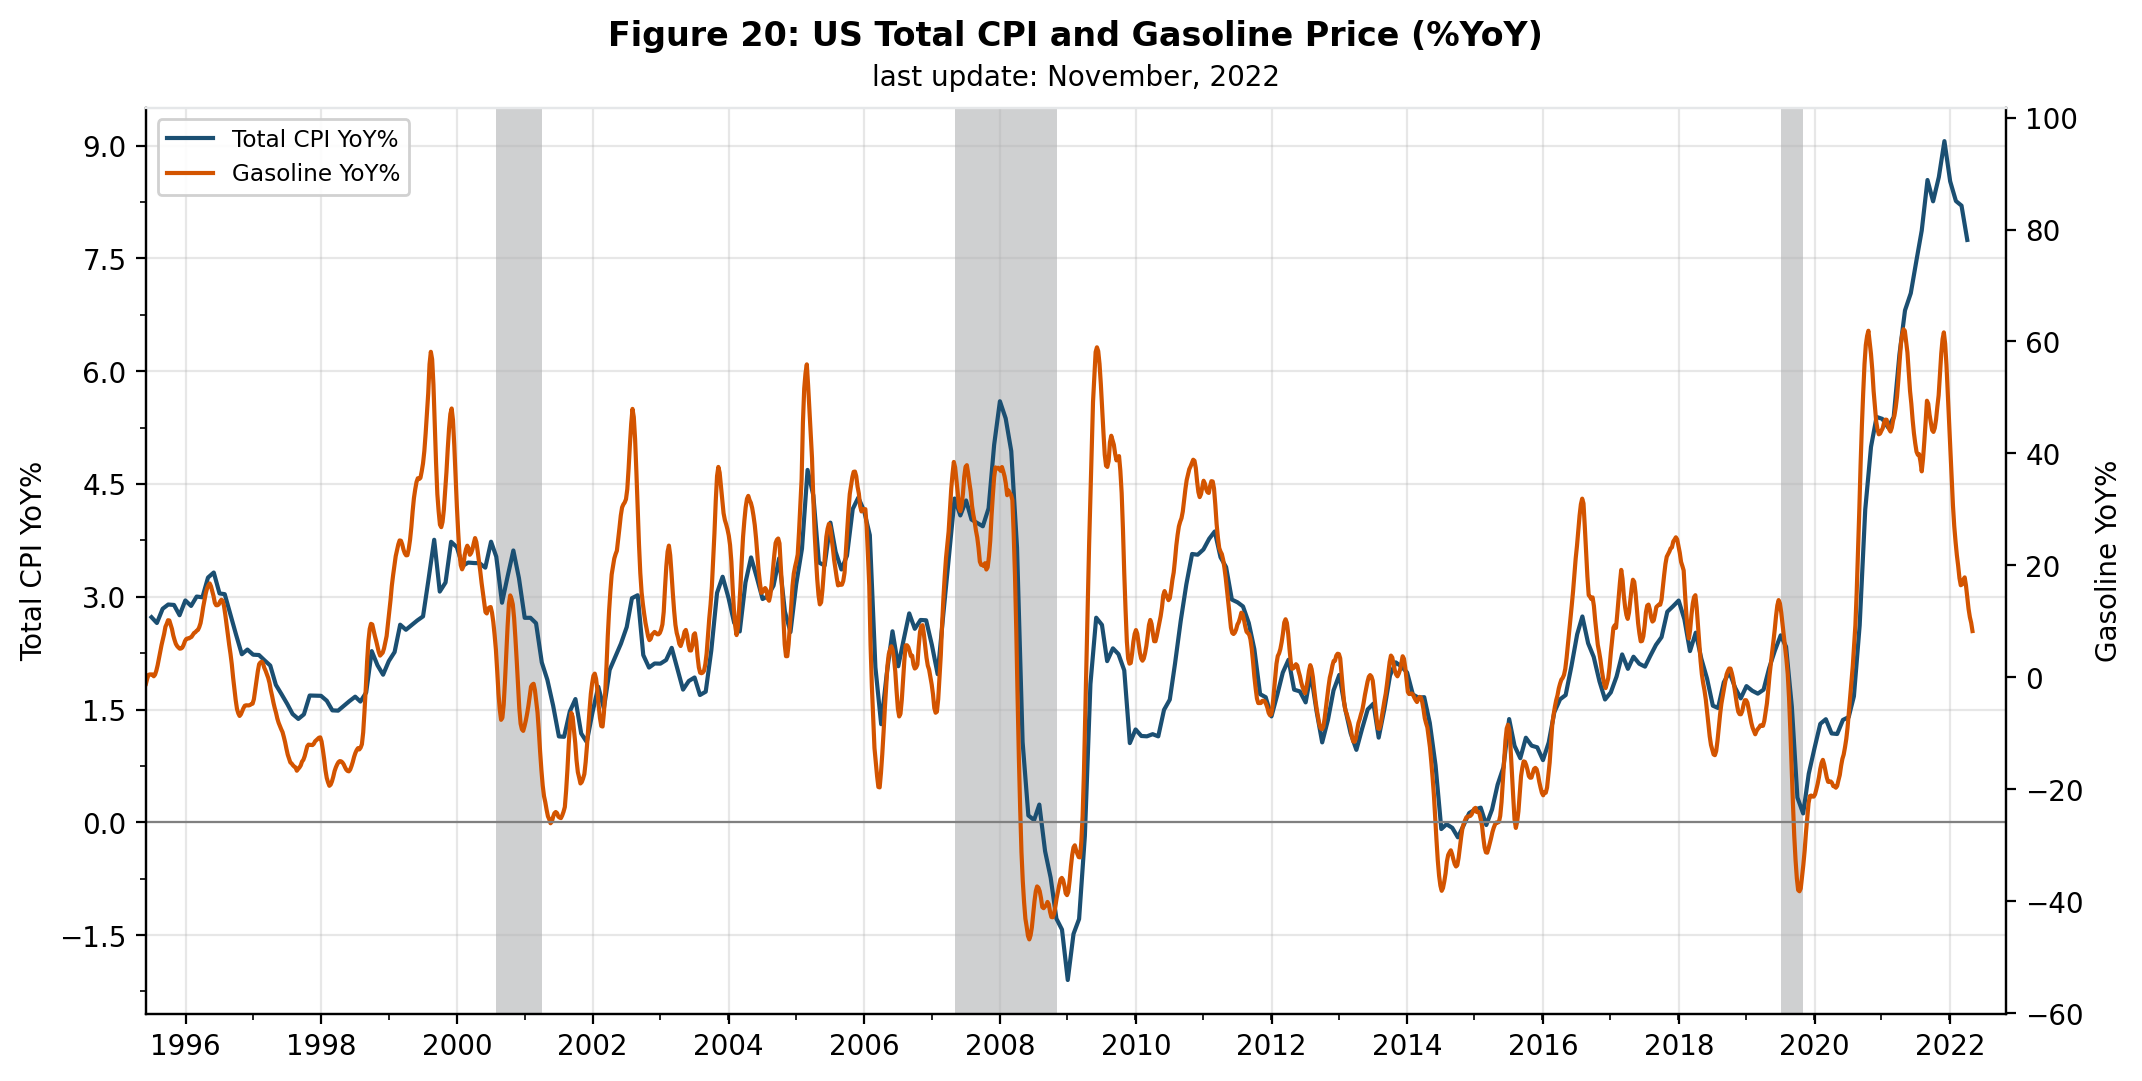

In [33]:
# Gasoline x CPI
# first, 4w moving averages
gas_yoy = gas.copy()
gas_yoy['value'] = (gas_yoy
                .sort_values("date")
                .groupby('series_id')["value"]
                .transform(lambda x: x.rolling(4).mean()))
gas_yoy = gas_yoy.dropna()
gas_yoy = compute_change(gas_yoy[["series_id","date","value"]], n=52)

gas_yoy = gas_yoy[gas_yoy["date"]>="1996"]

# cpi yoy:
yoy = cpi_yoy.loc[cpi_yoy["series_id"]=="CPI (yoy)",["series_id","date","value"]]
yoy = yoy[yoy["date"]>="1996"]
yoy["date"] = yoy["date"] + pd.DateOffset(months=1)
yoy["date"] = yoy["date"] - pd.Timedelta(days=1)
yoy.head()

fig, ax = dual_ts_plot(df = pd.concat([yoy, gas_yoy]),
                       series1 = "CPI (yoy)", series2 = "GASREGW",
                       start_date = "1996-01-01",
                       title = "Figure 20: US Total CPI and Gasoline Price (%YoY)",
                       ly_label = "Total CPI YoY%",
                       ry_label = "Gasoline YoY%",
                       fig_size = (12,6), legend_loc = "upper left",
                       plot_recession = True, hline = True, hline_loc = 0,
                       xmargin = 0.01, ymargin = 0.04,
                       y_major_loc = 1.5, y_minor_loc = 2,
                       x_major_loc = 24, x_minor_loc = 2, x_format = "%Y", n = 180)

plt.show()

Although the deceleration of items not present in the core is welcome, the greatest attention should be on the future dynamics of the core inflation, which, as shown in Graph 18, has not yet shown signs of deceleration.
Opening the core between industrial goods and services is very relevant since the behavior of these two sectors has been quite different since the beginning of the pandemic, as described in the previous session, and will have very different inflationary dynamics in the coming months. Such dissonant behavior has already been characteristic over the last few months, as can be seen in Graph 21, which shows the yoy and 3msaar variation of the two groups.


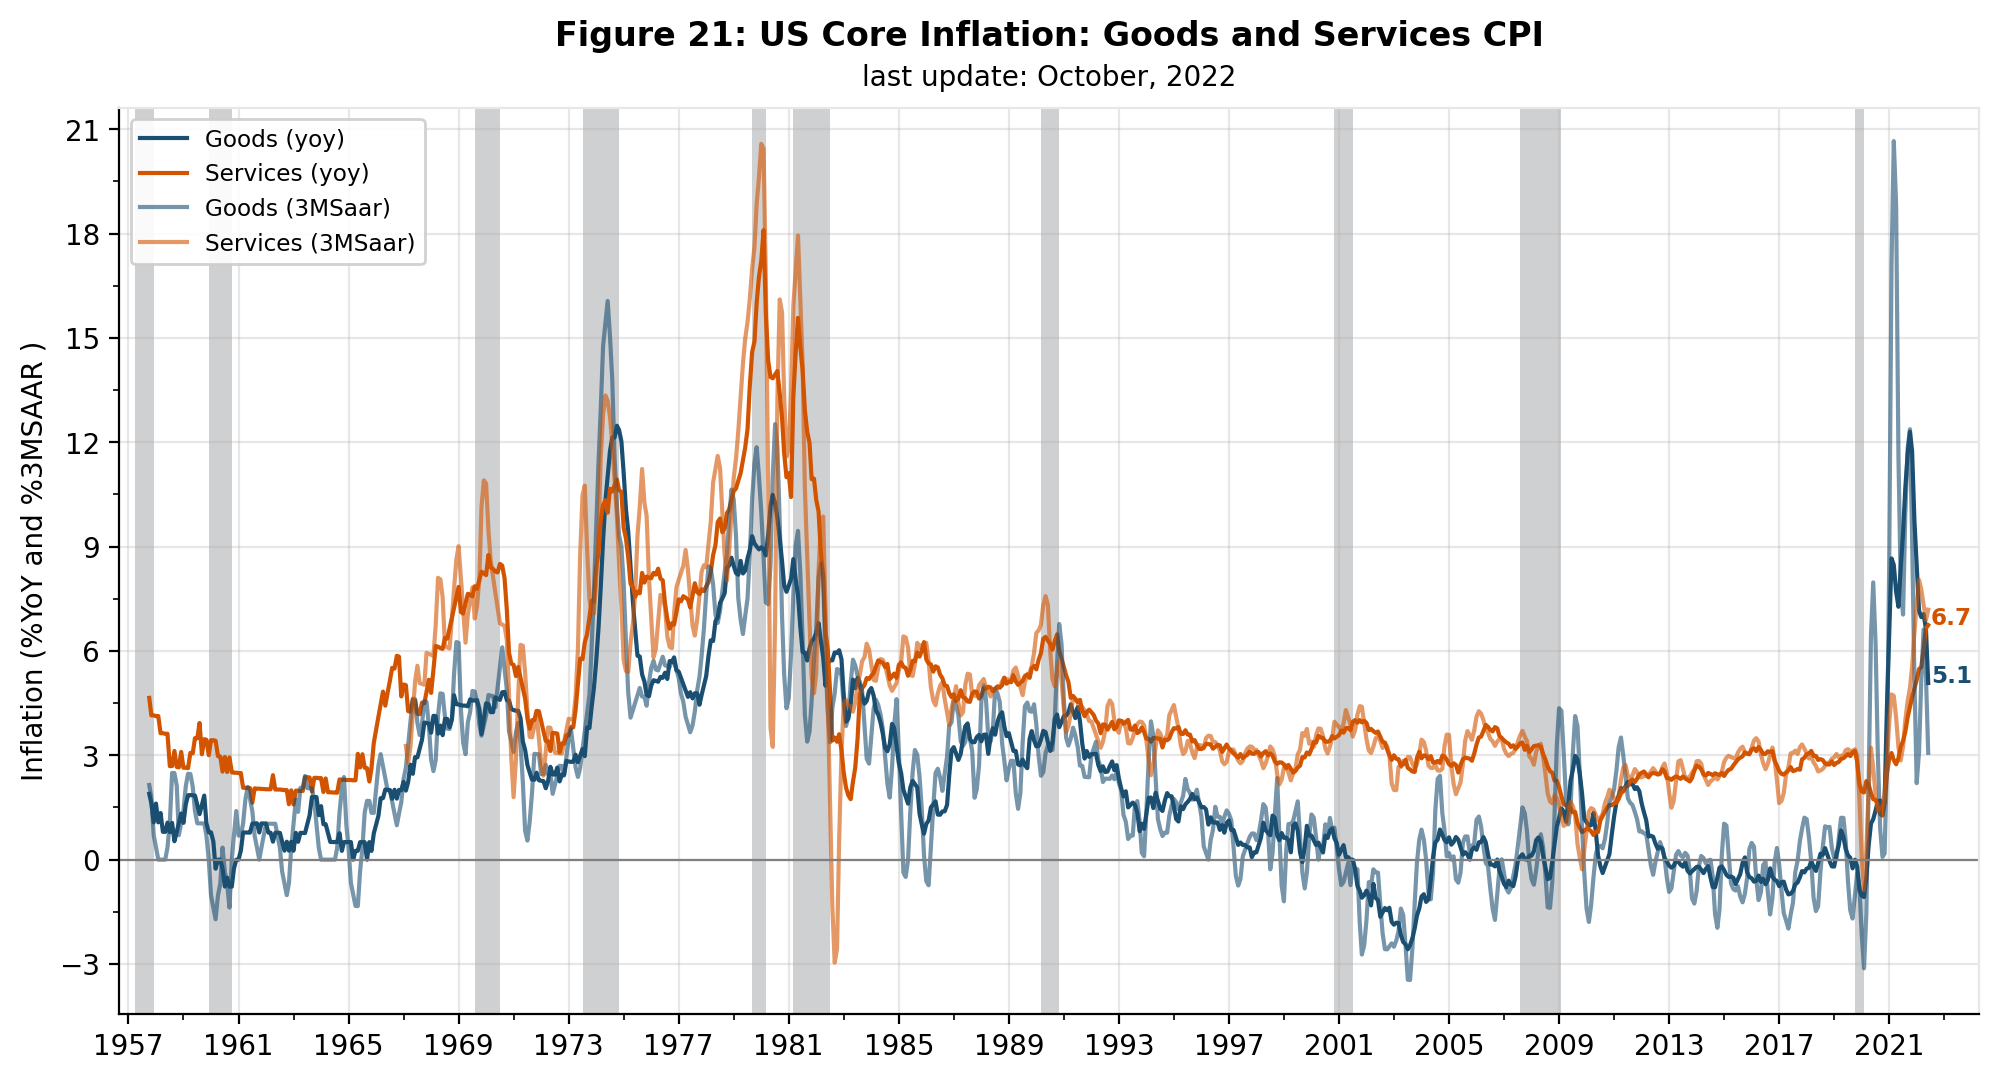

In [34]:
# Core CPI
# Select them in our data
core_nsa = cpi[cpi["series_id"].isin(["CUUR0000SACL1E","CUUR0000SASLE"])].copy()
core_sa = cpi[cpi["series_id"].isin(["CUSR0000SACL1E","CUSR0000SASLE"])].copy()

# YoY
core_nsa = (
    compute_change(core_nsa, n = 12).
    replace(["CUUR0000SACL1E","CUUR0000SASLE"],
            ["Goods (yoy)","Services (yoy)"])
)
core_nsa = core_nsa[core_nsa["date"]>"1958"].dropna()

# 3MSAAR
core_sa = (
    saar(core_sa, n = 3)
    .replace(["CUSR0000SACL1E","CUSR0000SASLE"],
             ["Goods (3MSaar)", "Services (3MSaar)"])
)
core_sa = core_sa[core_sa["date"]>"1958"].dropna()

df_code = pd.DataFrame({
    'series_id': ['Goods (yoy)','Services (yoy)','Goods (3MSaar)','Services (3MSaar)'],
    'hue': [colors[0], colors[1], colors[0], colors[1]],
    'alpha':[1, 1, 0.6, 0.6],
    'annotation':[True, True, False, False]})

fig, ax = ts_plot(df = pd.concat([core_nsa, core_sa]),
                  df_map = df_code,
                  start_date = "1957-01-01",
                  title ='Figure 21: US Core Inflation: Goods and Services CPI',
                  ylab='Inflation (%YoY and %3MSAAR )',
                  plot_recession = True, hline = True, hline_loc = 0,
                  xmargin = 0.01, ymargin = 0.04,
                  y_major_loc = 3, y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n=680)

plt.show()

The group of goods, which in the years prior to the pandemic was characterized by constant deflation, was strongly affected by the disruption of supply chains, as a result of the imbalances created by the tsunami of stimulus. Graph 22 shows the contribution of the main items in the group to the annual inflation of goods, it is easy to see that much of the recent problem was in the automobile industry.

During the beginning of the pandemic, demand for home appliances, computers, and cell phones rose sharply, while demand for vehicles retreated. All of these industrial goods depend on semiconductor chips, and the high demand for these goods has resulted in a global semiconductor shortage. When the economy reopened, and demand for new vehicles picked up again, factories were unable to deliver due to a lack of chips. As a result, the price of used vehicles began to rise sharply, as they emerged as substitutes for new vehicles. This was perhaps one of the main arguments used by the FED to support the temporary inflation narrative.


In [35]:
# Goods Composition

# Apparel: CUUR0000SAA
# New vehicles: CUUR0000SETA01
# Used cars and trucks: CUUR0000SETA02

goods_contr = weights[weights["item_name"].isin(["Apparel","New vehicles","Used cars and trucks"])]

# total goods weights
goods_weight = (
    weights[weights["item_name"]=="Commodities less food and energy commodities"]
    [["date","weight"]].rename(columns={"weight":"total"}))

goods_contr = pd.merge(goods_contr,goods_weight, how="left", on="date")

# merge with series id
goods_contr= pd.merge(goods_contr,
                      metadata[metadata["seasonal"]=="U"][["series_id","item_name"]],
                      how="left", on = ["item_name"])

# now, merging with cpi data
goods_contr = (
    pd.merge(
        goods_contr,
        compute_change(cpi[cpi["series_id"].isin(["CUUR0000SAA","CUUR0000SETA01","CUUR0000SETA02"])],n = 12),
        how="left", on=["date","series_id"])
)

# weights, 12m moving averages
goods_contr["weight"] = (goods_contr
                         .sort_values("date")
                         .groupby('series_id')['weight']
                         .transform(lambda x: x.rolling(12,min_periods=1).mean())) 

goods_contr = goods_contr.dropna()

#calculating weights
goods_contr["value"] = (goods_contr["weight"]/goods_contr["total"]) * goods_contr["value"]

# reshaping data:
goods_contr = (
    pd.pivot_table(
        goods_contr[["date","item_name","value"]],
        values="value", columns="item_name", index="date")
    .reset_index()
    .rename_axis(None,axis=1)
)

# Goods YoY
goods_yoy = (
    core_nsa.loc[
        core_nsa["series_id"]=="Goods (yoy)",
        ["series_id","date","value"]]
    .rename(columns = {"value":"goods"})
)

goods_contr = pd.merge(goods_contr,goods_yoy[["date","goods"]], how="left", on="date")

goods_contr["Others"] = (
    goods_contr["goods"] -
    (goods_contr["Apparel"] + goods_contr["New vehicles"] + goods_contr["Used cars and trucks"])
)


# positive values
goods_contr_p = goods_contr.copy()
goods_contr_p.loc[goods_contr_p["Apparel"] < 0 ,"Apparel"] = 0
goods_contr_p.loc[goods_contr_p["New vehicles"] < 0 ,"New vehicles"] = 0
goods_contr_p.loc[goods_contr_p["Used cars and trucks"] < 0 ,"Used cars and trucks"] = 0
goods_contr_p.loc[goods_contr_p["Others"] < 0 ,"Others"] = 0

# test_negative values
goods_contr_n = goods_contr.copy()
goods_contr_n.loc[goods_contr_n["Apparel"] >= 0 ,"Apparel"] = 0
goods_contr_n.loc[goods_contr_n["New vehicles"] >= 0 ,"New vehicles"] = 0
goods_contr_n.loc[goods_contr_n["Used cars and trucks"] >= 0 ,"Used cars and trucks"] = 0
goods_contr_n.loc[goods_contr_n["Others"] >= 0 ,"Others"] = 0


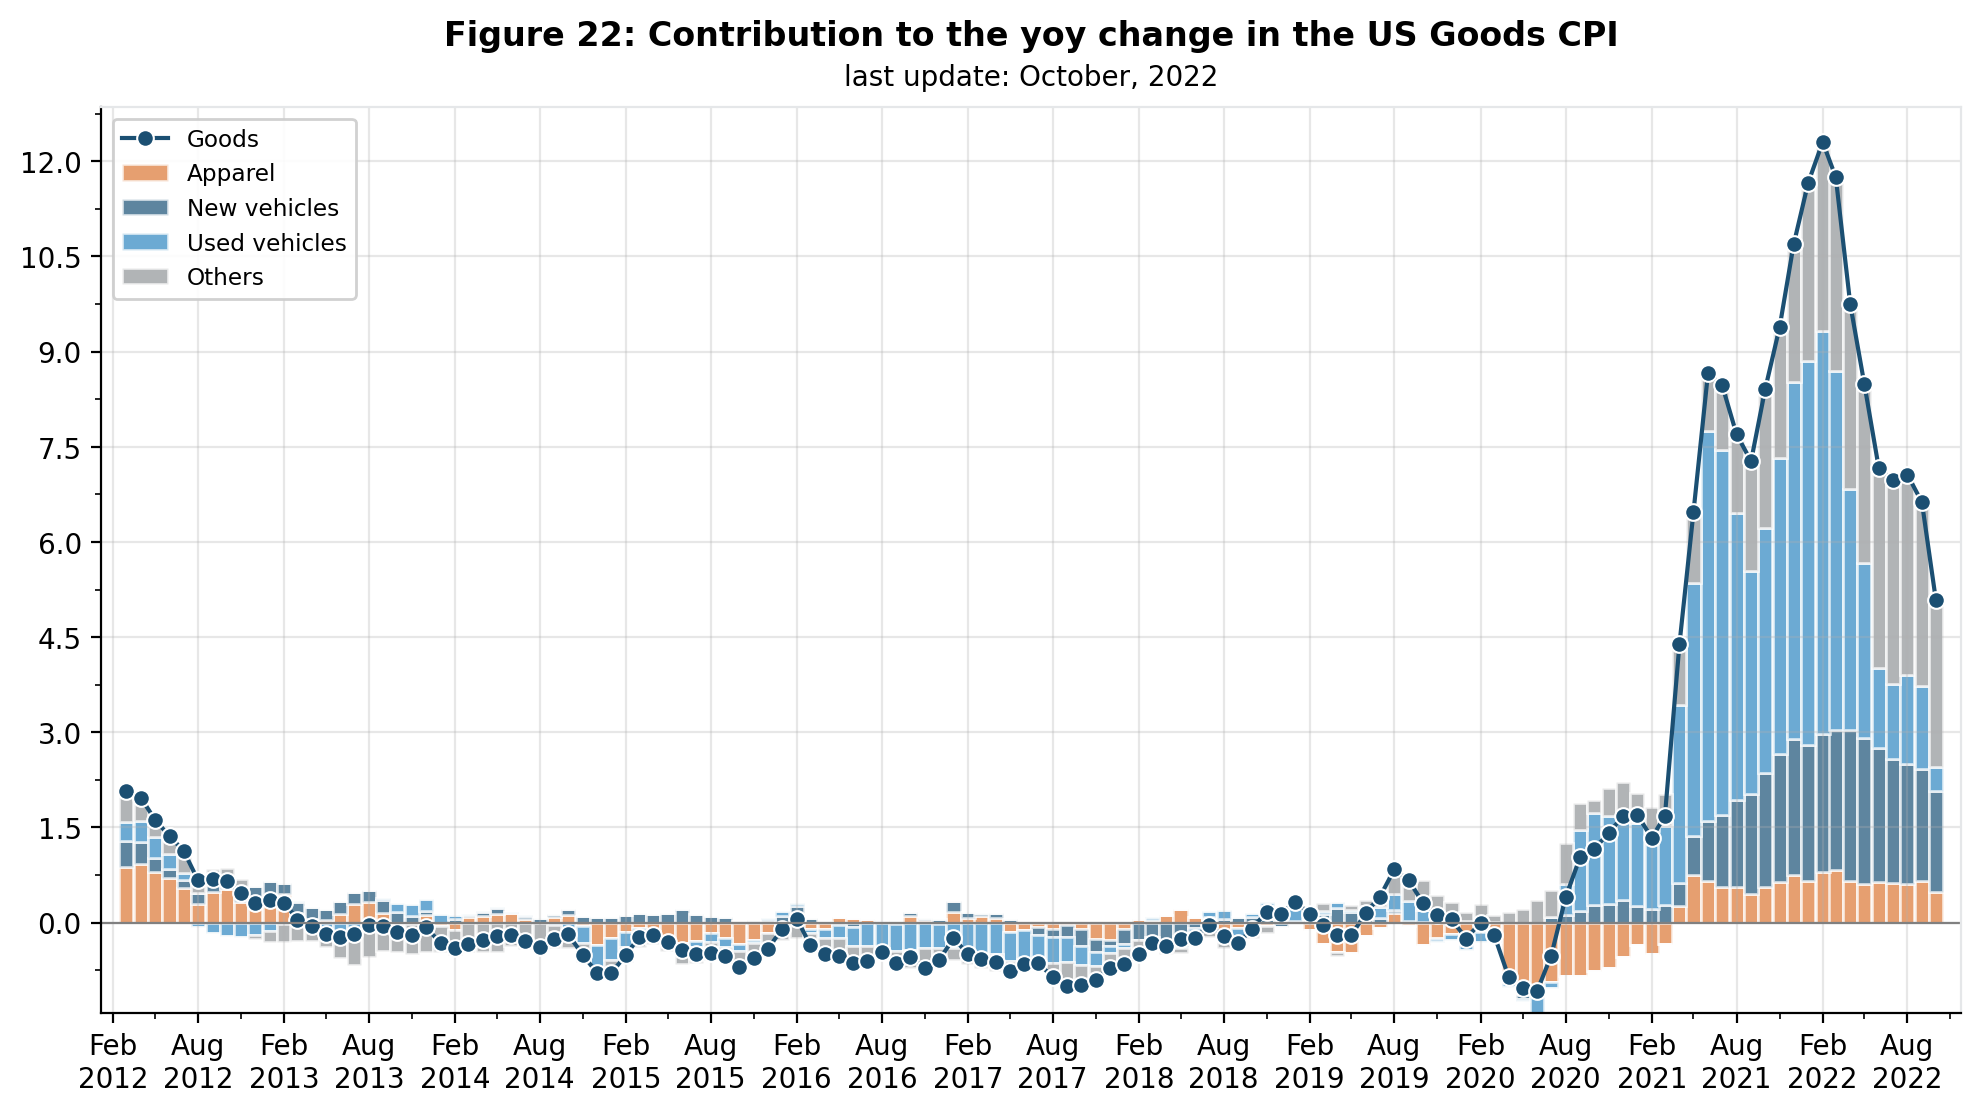

In [36]:
# chart:
fig, ax = plt.subplots(figsize=(12,6))

# positive values
ax.bar(goods_contr_p["date"], goods_contr_p["Apparel"], width = 30,
       label="Apparel", color= colors[75], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(goods_contr_p["date"], goods_contr_p["New vehicles"], width = 30,
       bottom = goods_contr_p["Apparel"], label="New vehicles", color= colors[31], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(goods_contr_p["date"], goods_contr_p["Used cars and trucks"], width = 30,
       bottom = goods_contr_p["Apparel"]+goods_contr_p["New vehicles"],
       label="Used vehicles", color= colors[43], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(goods_contr_p["date"], goods_contr_p["Others"], width = 30,
       bottom = goods_contr_p["Apparel"]+goods_contr_p["New vehicles"]+
       goods_contr_p["Used cars and trucks"],
       label="Others", color= colors[102], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

# negative values
ax.bar(goods_contr_n["date"], goods_contr_n["Apparel"], width = 30,
       label="Apparel", color= colors[75], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(goods_contr_n["date"], goods_contr_n["New vehicles"], width = 30,
       bottom = goods_contr_n["Apparel"], label="New vehicles", color= colors[31], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(goods_contr_n["date"], goods_contr_n["Used cars and trucks"], width = 30,
       bottom = goods_contr_n["Apparel"]+goods_contr_n["New vehicles"],
       label="Used vehicles", color= colors[43], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(goods_contr_n["date"], goods_contr_n["Others"], width = 30,
       bottom = goods_contr_n["Apparel"]+goods_contr_n["New vehicles"]+
       goods_contr_n["Used cars and trucks"],
       label="Others", color= colors[102], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

# line
sns.lineplot(data=goods_contr_p,
            x="date", y="goods",
            color=colors[0], ax=ax, legend=False, marker="o")

ax.legend(['Goods', 'Apparel', 'New vehicles', 'Used vehicles', 'Others'], 
    loc='upper left', frameon=True, framealpha=0.9, fontsize='small')


ax.axhline(y=0, color='gray', lw=0.8)

ax.margins(x=0.01, y=0.04)

# date axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))

year_month_formatter = mdates.DateFormatter("%b\n%Y")
ax.xaxis.set_major_formatter(year_month_formatter)

# y axis
ax.yaxis.set_major_locator(MultipleLocator(1.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylabel(None)

ax.spines['top'].set_edgecolor(colors[107])
ax.spines['right'].set_edgecolor(colors[107])

ax.grid(axis='y', alpha=0.3)
ax.grid(axis='x', alpha=0.3)

ax.set_title('Figure 22: Contribution to the yoy change in the US Goods CPI', y=1.05, loc="center",
            fontweight="bold")

# subtitle...
last = goods_contr_p.loc[goods_contr_p['date']==max(goods_contr_p['date']),:]

ax.xaxis.set_label_position('top')
text = last["date"].dt.strftime("%B, %Y").values[0]

ax.set_xlabel(f"last update: {text}",
              labelpad = 8, loc="center")

plt.show()

The adjustment (albeit slow) of the semiconductor industry, added to the slowdown in activity, caused by the reversal of stimulus, is beginning to have a stronger impact on the inflation of goods, a movement that should continue in the coming months, as shown by the Manheim used vehicle price index, used as a leading indicator for the inflation of this item in the CPI (chart 23). The PMI's Delivery time, (Graph 13) shows that a similar situation might be seen for other industries that have been facing a similar situation.

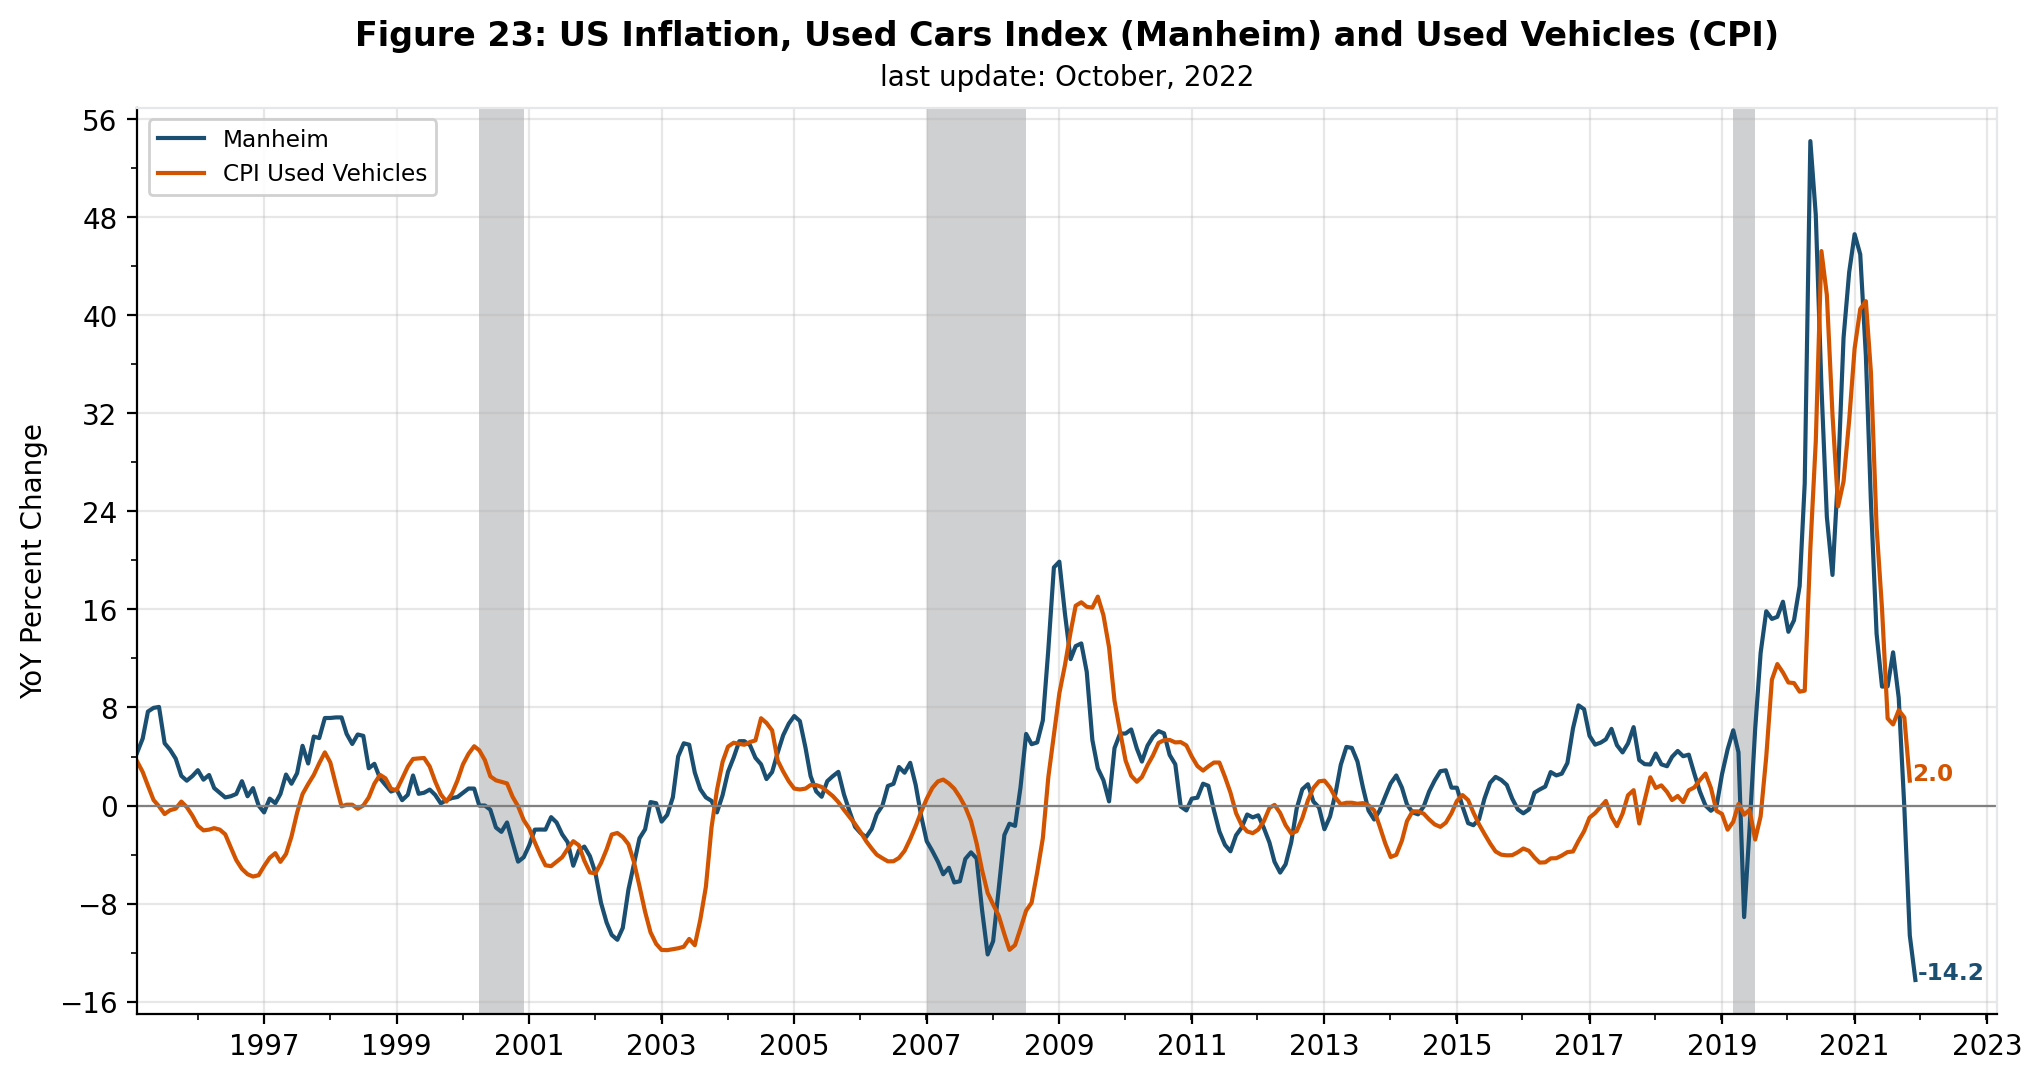

In [37]:
# Importing Manheim data
manheim = pd.read_csv("data\\inflation\\manheim.csv")
manheim["date"] = pd.to_datetime("01-" + manheim["date"])
manheim["series_id"] = "Manheim"
manheim = manheim.rename(columns = {"manheim":"value"})
manheim = compute_change(manheim[["series_id","date","value"]], n = 12)

# Goods YoY
used_vehicles_yoy = (
    compute_change(cpi[cpi["series_id"]=="CUUR0000SETA02"],n = 12)
    .replace("CUUR0000SETA02","CPI Used Vehicles"))

# chart
df_code = pd.DataFrame({
    'series_id': ['Manheim','CPI Used Vehicles'],
    'hue': [colors[0], colors[1]],
    'alpha':[1, 1],
    'annotation':[True, True]})

fig, ax = ts_plot(df = pd.concat([manheim, used_vehicles_yoy]),
                  df_map = df_code,
                  start_date = "1996-01-01",
                  title ='Figure 23: US Inflation, Used Cars Index (Manheim) and Used Vehicles (CPI)',
                  ylab='YoY Percent Change',
                  plot_recession = True, hline = True, hline_loc = 0,
                  xmargin = 0.01, ymargin = 0.04,
                  y_major_loc = 8, y_minor_loc = 2,
                  x_major_loc = 24, x_minor_loc = 2, x_format = "%Y", n=450)

plt.show()

Turning now to the services sector, graph 24 shows the contribution of the main items to the annual inflation of services measured by the CPI. A large part of services is composed of rent inflation, which is highly inertial and highly correlated with house prices due to the existence of the OER Index.

In [38]:
# Services:
# Shelter
# Medical care services
# Transportation services

services_contr = weights[weights["item_name"].isin(["Shelter","Medical care services","Transportation services"])]

# total goods weights
services_weight = (
    weights[weights["item_name"]=="Services less energy services"]
    [["date","weight"]].rename(columns={"weight":"total"})
)

services_contr = pd.merge(services_contr,services_weight, how="left", on="date")

# merge with series id
services_contr= pd.merge(services_contr,
                      metadata[metadata["seasonal"]=="U"][["series_id","item_name"]],
                      how="left", on = ["item_name"])

# now, merging with cpi data
services_contr = (
    pd.merge(
        services_contr,
        compute_change(cpi[cpi["series_id"].isin(["CUUR0000SAH1","CUUR0000SAM2","CUUR0000SAS4"])],n = 12),
        how="left", on=["date","series_id"])
)

# weights, 12m moving averages
services_contr["weight"] = (services_contr
                         .sort_values("date")
                         .groupby('series_id')['weight']
                         .transform(lambda x: x.rolling(12,min_periods=1).mean())) 

services_contr = services_contr.dropna()

services_contr["value"] = (services_contr["weight"]/services_contr["total"]) * services_contr["value"]

# reshaping data:
services_contr = (
    pd.pivot_table(
        services_contr[["date","item_name","value"]],
        values="value", columns="item_name", index="date")
    .reset_index()
    .rename_axis(None,axis=1)
)

# services yoy, and changing the value column name
services_yoy = (
    core_nsa.loc[
        core_nsa["series_id"]=="Services (yoy)",
        ["series_id","date","value"]]
    .rename(columns = {"value":"services"}))

# merging services yoy with the DF
services_contr = pd.merge(
    services_contr,
    services_yoy[["date","services"]],
    how="left",on="date")

# creating "others"
services_contr["Others"] = (
    services_contr["services"] - 
    (services_contr["Shelter"] +
     services_contr["Medical care services"] +
     services_contr["Transportation services"])
)

# _positive
services_contr_p = services_contr.copy()
services_contr_p.loc[services_contr_p["Shelter"] < 0 ,"Shelter"] = 0
services_contr_p.loc[services_contr_p["Medical care services"] < 0 ,"Medical care services"] = 0
services_contr_p.loc[services_contr_p["Transportation services"] < 0 ,"Transportation services"] = 0
services_contr_p.loc[services_contr_p["Others"] < 0 ,"Others"] = 0

# _negative
services_contr_n = services_contr.copy()
services_contr_n.loc[services_contr_n["Shelter"] >= 0 ,"Shelter"] = 0
services_contr_n.loc[services_contr_n["Medical care services"] >= 0 ,"Medical care services"] = 0
services_contr_n.loc[services_contr_n["Transportation services"] >= 0 ,"Transportation services"] = 0
services_contr_n.loc[services_contr_n["Others"] >= 0 ,"Others"] = 0

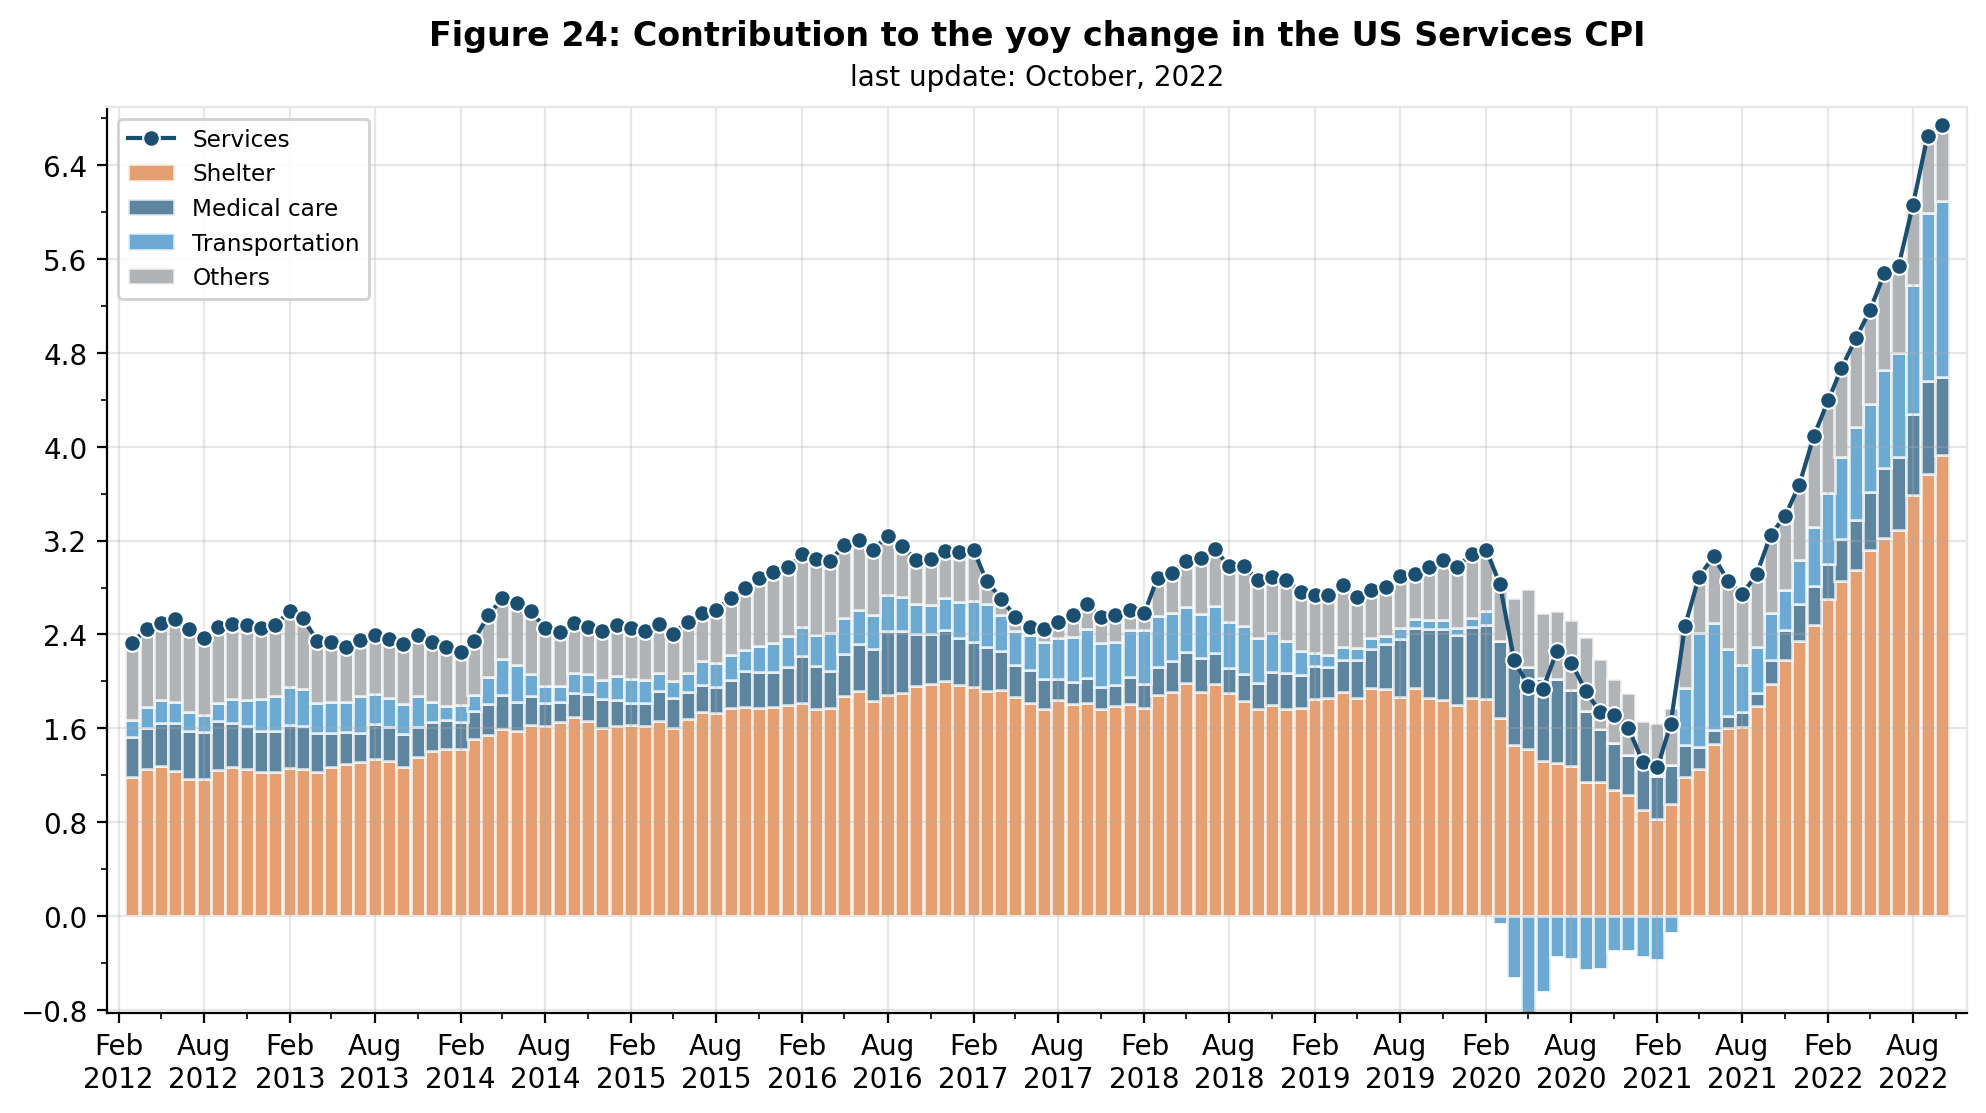

In [39]:
# chart:
plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(figsize=(12,6))

# positive values
ax.bar(services_contr_p["date"], services_contr_p["Shelter"], width = 30,
       label="Shelter", color= colors[75], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(services_contr_p["date"], services_contr_p["Medical care services"], width = 30,
       bottom = services_contr_p["Shelter"], label="Medical care", color= colors[31], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(services_contr_p["date"], services_contr_p["Transportation services"], width = 30,
       bottom = services_contr_p["Shelter"]+services_contr_p["Medical care services"],
       label="Transportation", color= colors[43], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(services_contr_p["date"], services_contr_p["Others"], width = 30,
       bottom = services_contr_p["Shelter"]+services_contr_p["Medical care services"]+
       services_contr_p["Transportation services"],
       label="Others", color= colors[102], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

# negative values
ax.bar(services_contr_n["date"], services_contr_n["Shelter"], width = 30,
       label="Shelter", color= colors[75], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(services_contr_n["date"], services_contr_n["Medical care services"], width = 30,
       bottom = services_contr_n["Shelter"], label="Medical care", color= colors[31], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(services_contr_n["date"], services_contr_n["Transportation services"], width = 30,
       bottom = services_contr_n["Shelter"]+services_contr_n["Medical care services"],
       label="Transportation", color= colors[43], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

ax.bar(services_contr_n["date"], services_contr_n["Others"], width = 30,
       bottom = services_contr_n["Shelter"]+services_contr_n["Medical care services"]+
       services_contr_n["Transportation services"],
       label="Others", color= colors[102], alpha=0.7,
       edgecolor = 'white', linewidth = 1)

# line
sns.lineplot(data=services_contr_p,
            x="date", y="services",
            color=colors[0], ax=ax, legend=False, marker="o")

ax.legend(['Services', 'Shelter','Medical care', 'Transportation','Others'], 
    loc='upper left', frameon=True, framealpha=0.9, fontsize='small')

ax.margins(x=0.01, y=0.02)

# date axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))

year_month_formatter = mdates.DateFormatter("%b\n%Y")
ax.xaxis.set_major_formatter(year_month_formatter)

# y axis
ax.yaxis.set_major_locator(MultipleLocator(0.8))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylabel(None)

ax.spines['top'].set_edgecolor(colors[107])
ax.spines['right'].set_edgecolor(colors[107])

ax.grid(axis='y', alpha=0.3)
ax.grid(axis='x', alpha=0.3)

ax.set_title('Figure 24: Contribution to the yoy change in the US Services CPI', y=1.05, loc="center",
            fontweight="bold")

# subtitle...
last = services_contr_p.loc[services_contr_p['date']==max(services_contr_p['date']),:]

ax.xaxis.set_label_position('top')
text = last["date"].dt.strftime("%B, %Y").values[0]

ax.set_xlabel(f"last update: {text}",
              labelpad = 8, loc="center")

plt.show()

OER is a metric of imputed rent, since most households own their homes, the BLS conducts a survey that asks homeowners what theoretical rent they would pay. As it is subjective, the question makes the index a function of indicators referring to the housing market, in particular, to house prices, as can be seen in Graph 25.

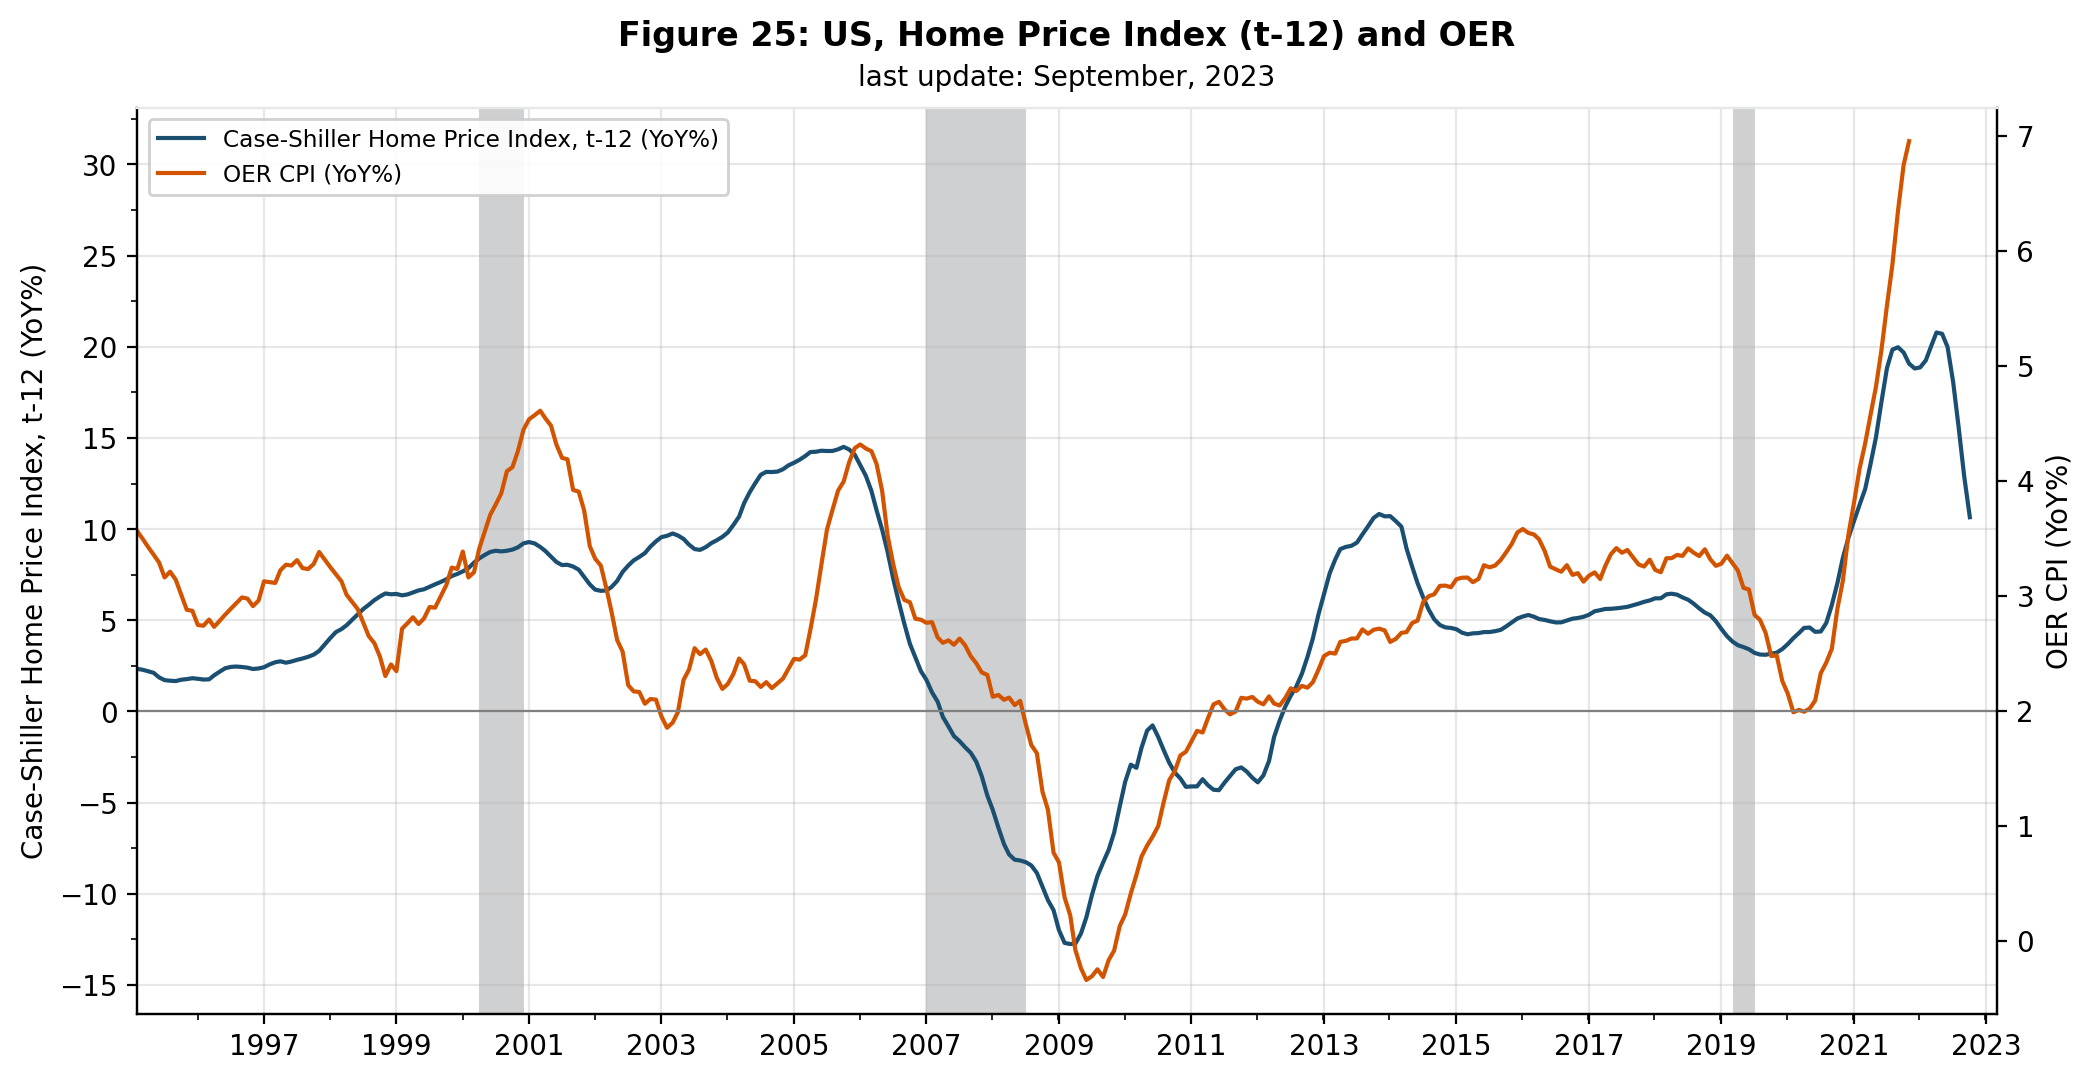

In [41]:
## OER and Home Prices:
# importing Case-Shiller Home price index:
cs = pd.read_parquet("data\\housing\\data_fred_caseshiller.parquet")

# computing YoY
cs_yoy = (compute_change(cs.loc[cs["series_id"]=="CSUSHPINSA", ["series_id","date","value"]], n = 12)
          .replace("CSUSHPINSA","Case-Shiller (yoy)"))

# using 12 months lead home prices
cs_yoy["date"] = cs_yoy["date"] + pd.DateOffset(months=12)

oer_nsa = cpi[cpi["series_id"].isin(["CUUR0000SEHC","CUUR0000SAH1","CUUR0000SASLE"])].copy()

# YoY
oer_nsa = (
    compute_change(oer_nsa, n = 12).
    replace(["CUUR0000SEHC","CUUR0000SAH1","CUUR0000SASLE"],
            ["OER (yoy)","Shelter (yoy)","Services (yoy)"])
)

# chart:
fig, ax = dual_ts_plot(df = pd.concat([cs_yoy, oer_nsa]),
                       series1 = "Case-Shiller (yoy)", series2 = "OER (yoy)",
                       start_date = "1996-01-01",
                       title = "Figure 25: US, Home Price Index (t-12) and OER",
                       ly_label = "Case-Shiller Home Price Index, t-12 (YoY%)",
                       ry_label = "OER CPI (YoY%)",
                       fig_size = (12,6), legend_loc = "upper left",
                       plot_recession = True, hline = True, hline_loc = 0,
                       xmargin = 0.01, ymargin = 0.04,
                       y_major_loc = 5, y_minor_loc = 2,
                       x_major_loc = 24, x_minor_loc = 2, x_format = "%Y", n = 150)

plt.show()

As it responds directly to the housing market, rent inflation is also directly related to changes in monetary policy, although with a considerable lag, which makes the FED's work in combating inflation more difficult, given the strong inertial nature of this component, which is the most relevant within core inflation.

In addition, the services group is also the most sensitive to salary inflation, and we saw that the labor market remains very tight, even with the withdrawal of stimulus. Graph 26 shows the ratio between the total number of job openings, measured by the JOLTS survey, and the total number of unemployed workers. In September, the ratio was still at 1.9, that is, almost two job openings for each unemployed worker.


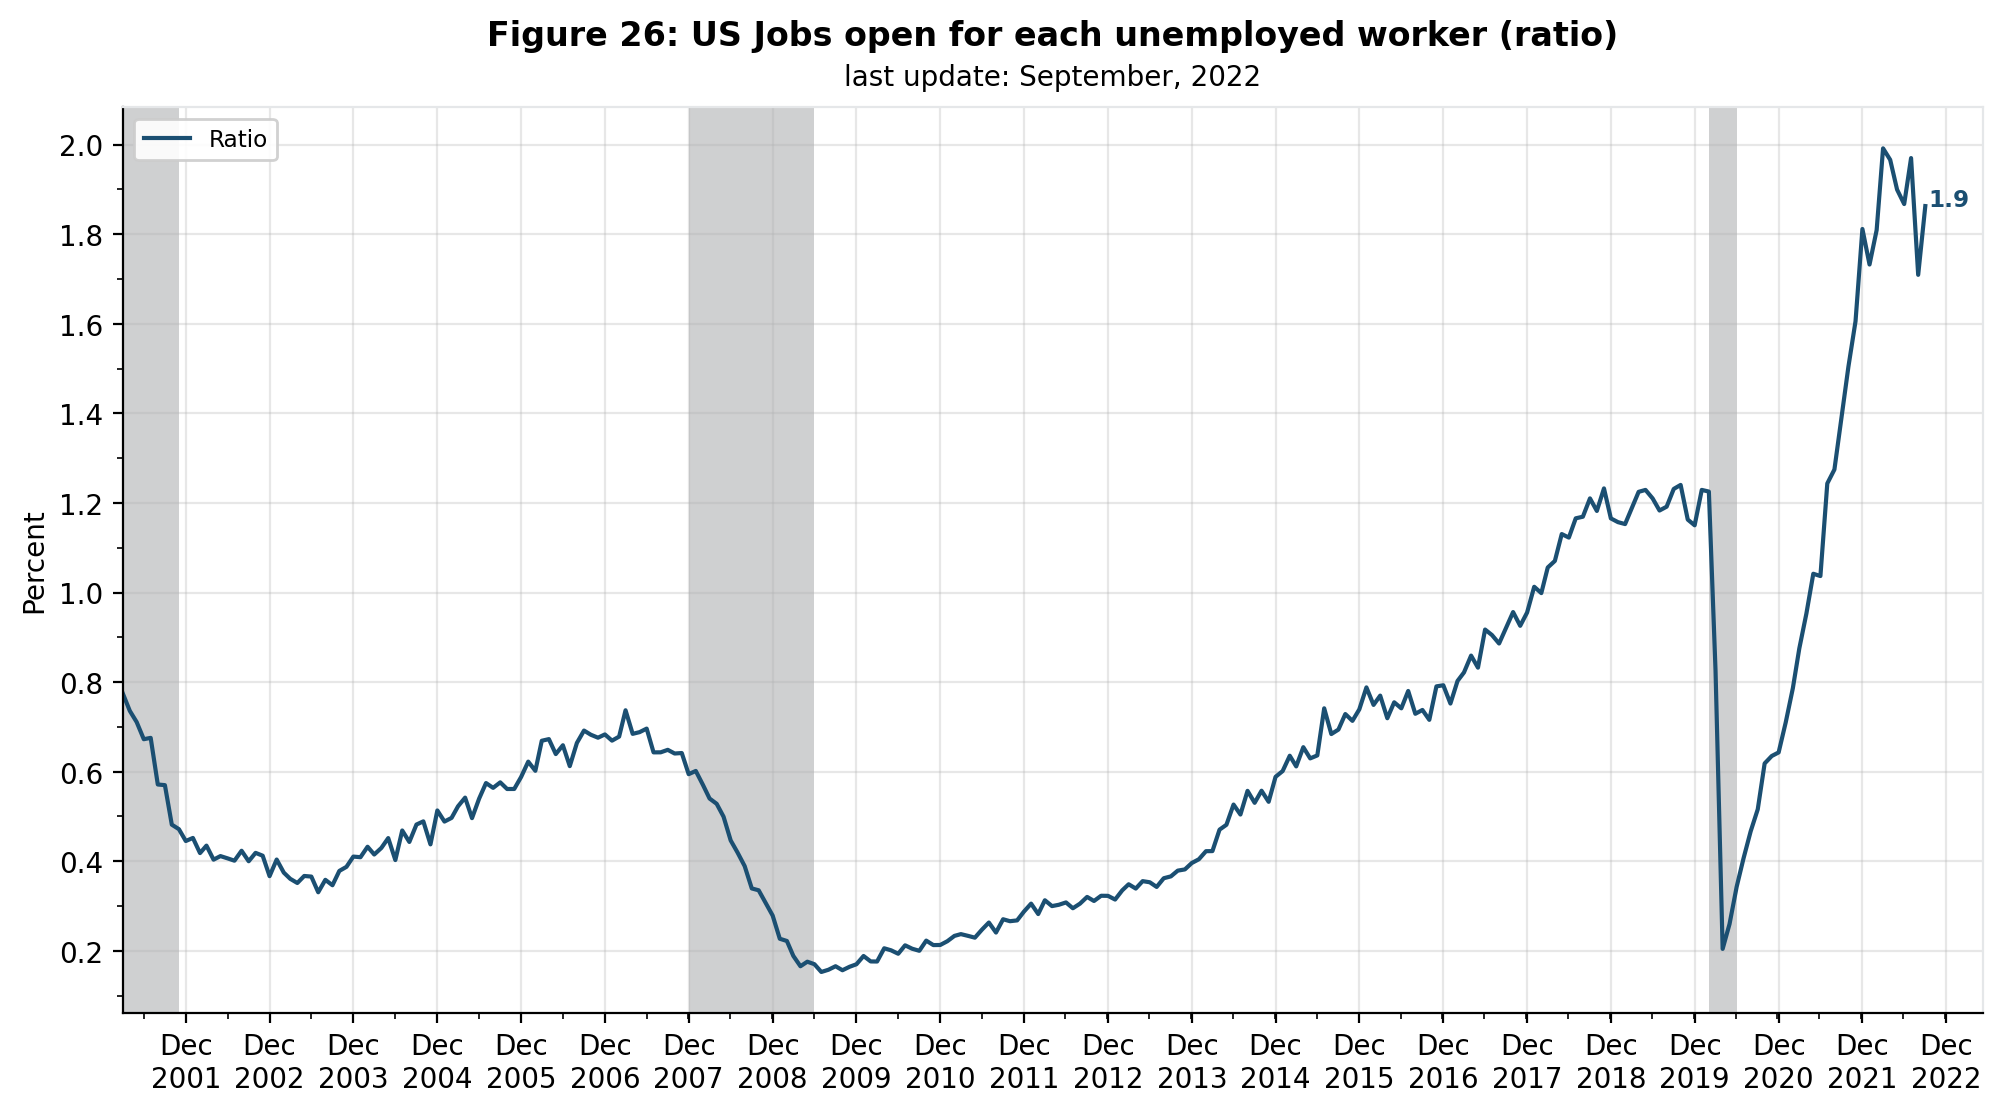

In [42]:
unemp = (
    cps[cps["series_id"]=="LNS13000000"]
    .copy()
    .rename(columns = {"value":"Unemployment"})[["date","Unemployment"]]
)

openings = (
    jolts[jolts["series_id"]=="JTS000000000000000JOL"]
    .copy()
    .rename(columns = {"value":"Job Openings"})[["date","Job Openings"]]
)

data = pd.merge(openings,unemp, how="left")
data["Ratio"] = data["Job Openings"]/data["Unemployment"]
data = data.melt(id_vars="date",var_name="series_id")[["series_id","date","value"]]

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Ratio'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2001-03-01",
                  title ='Figure 26: US Jobs open for each unemployed worker (ratio)',
                  ylab='Percent',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = False, hline_loc = 0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 0.2, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n=250)

plt.show()

The resilience of the labor market and the comfortable condition of American consumers pose difficulties for the Fed in the task of slowing down the economy to bring inflation back to the 2% target. However, the sharp tightening of financial conditions, even though it started late, has already begun to affect economic activity, as shown by the Graphs 11 and 12, and shold further impact economic activity.

## 4. Forecasting US Inflation

All the indicators presented here point to the deceleration of inflation, even if the process takes some time
The approach through data analysis can be intuitive and can even offer an indication of which direction inflation should go, it is very subjective. To offer a quantitative alternative, forecasting models can be used to validate or challenge the points made in the previous section. Thus, the final part of this work proposes to explore different models and observe whether they will also point to a deceleration in inflation in the coming months, and if so, at what pace.


### Data preparation

The `data_prep.ipynb` file select some series to use in the models. To avoid additional code, I'm just going to import the parquet file

In [43]:
# open parquet file
data = pd.read_parquet("project_data.parquet")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   date                                1007 non-null   datetime64[ns]
 1   CPI                                 909 non-null    float64       
 2   Case Shiller                        428 non-null    float64       
 3   Empire Prices Paid (current)        257 non-null    float64       
 4   Empire Prices Paid (future)         257 non-null    float64       
 5   Empire Prices Received (current)    257 non-null    float64       
 6   Empire Prices Received (future)     257 non-null    float64       
 7   Fed Funds                           822 non-null    float64       
 8   Gas                                 387 non-null    float64       
 9   ISM Manufacturing Prices            899 non-null    float64       
 10  ISM Nonmanufacturing Pri

I'm going to use the annualized monthly CPI, and I will also create an intervention dummy because of an outlier observation. 

In [44]:
# using annualized version of the monthly cpi
data["CPI"]=data["CPI"]*12
data["dummy"]=0
data.loc[data["date"]=="2008-11-01","dummy"] = 1

In [45]:
# selecting Total CPI MoM
change = data[["date","CPI"]].copy()
change["series_id"]="CPI mom"
change = change.rename(columns = {"CPI":"value"})[["series_id","date","value"]]

change.dropna().head()

series_id       date      value
96    CPI mom 1947-02-01   7.795851
97    CPI mom 1947-03-01  20.908369
98    CPI mom 1947-04-01   0.000000
99    CPI mom 1947-05-01  -2.730377
100   CPI mom 1947-06-01   7.086098

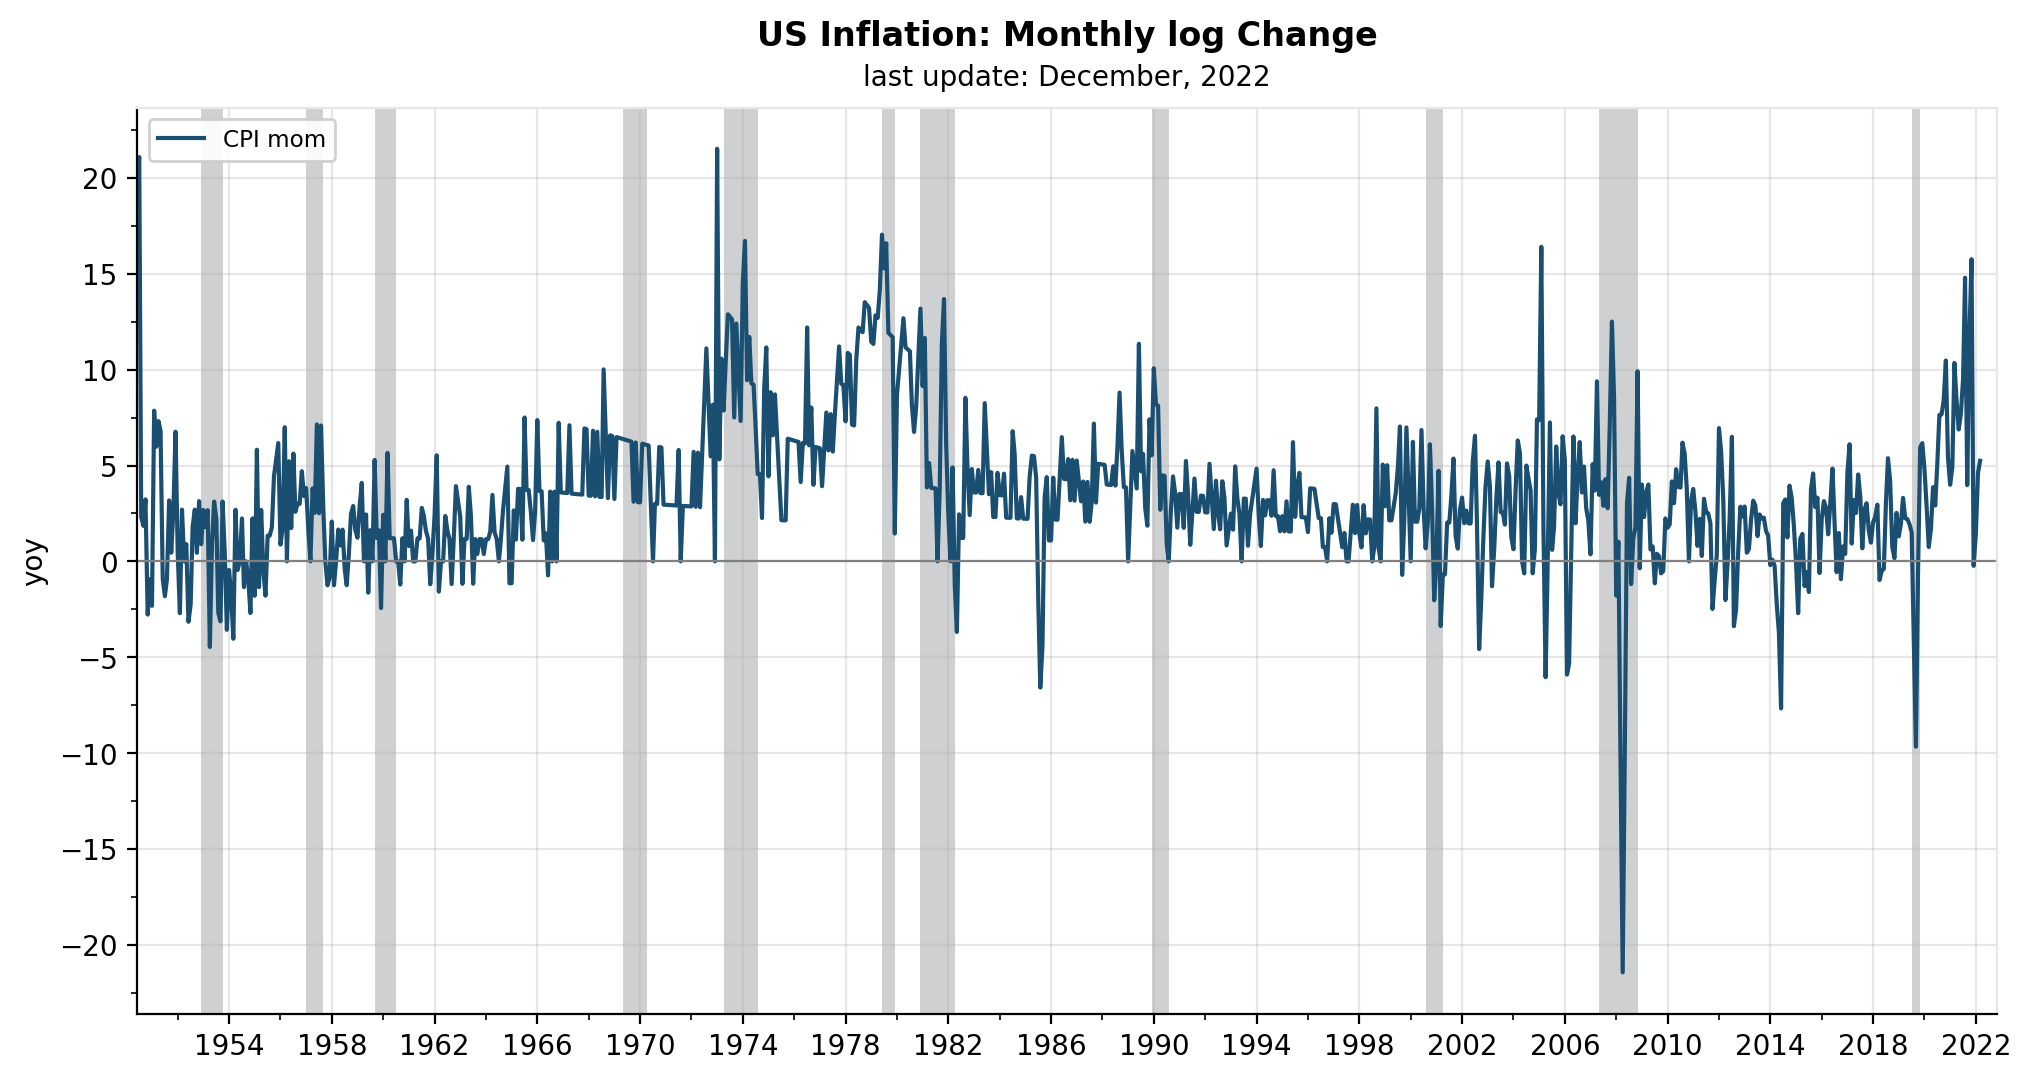

In [46]:
plt.rcParams['figure.dpi'] = 200 # high quality figure.
# chart
df_code = pd.DataFrame({
    'series_id': ["CPI mom"],
    'hue': [fn.colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = fn.ts_plot(df = change,
                  df_map = df_code,
                  start_date = "1951-01-01",
                  title ='US Inflation: Monthly log Change',
                  ylab='yoy',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, hline = True, hline_loc=0,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 5,y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n=180)

plt.show()


### Univariate Models

A traditional way to forecast time series data, is through univariate models. A general integrated autoregressive moving average model ARIMA(p,d,q) can be written as:

$$(1-\phi_1 L-\phi_2 L^2...-\phi_p L^p)(1-L)^d \pi_{t}=\gamma+(1-\theta_1 L-\theta_2 L^2...-\theta_q L^q)\varepsilon_{t}$$

where $L$ is the backshift operator: 

$$(1-L)\pi_{t} = \pi_{t-1}$$

and $\pi_{t}$ is the inflation rate at time $t$

We can start by running an augmented dickey fuller test to check if the CPI data is stationary: 

In [47]:
change = change[change["date"]>="2002"].dropna()
change = change.set_index('date').drop(columns = "series_id")

def adf_test(df):
    result = adfuller(df.values)
    if result[1] > 0.1:
        print("Constant: not stationary")
    else:
        print("Constant: stationary")
    
    result = adfuller(df.values, regression = "ct")
    if result[1] > 0.1:
        print("Constant and trend: not stationary")
    else:
        print("Constant and trend: stationary")
        
    result = adfuller(df.values, regression = "n")
    if result[1] > 0.1:
        print("none: not stationary")
    else:
        print("none: stationary")


adf_test(change["value"])

Constant: stationary
Constant and trend: stationary
none: not stationary


The fist two specifications confirmed that the series is stationary. The ACF and PACF also points out to a stationary process

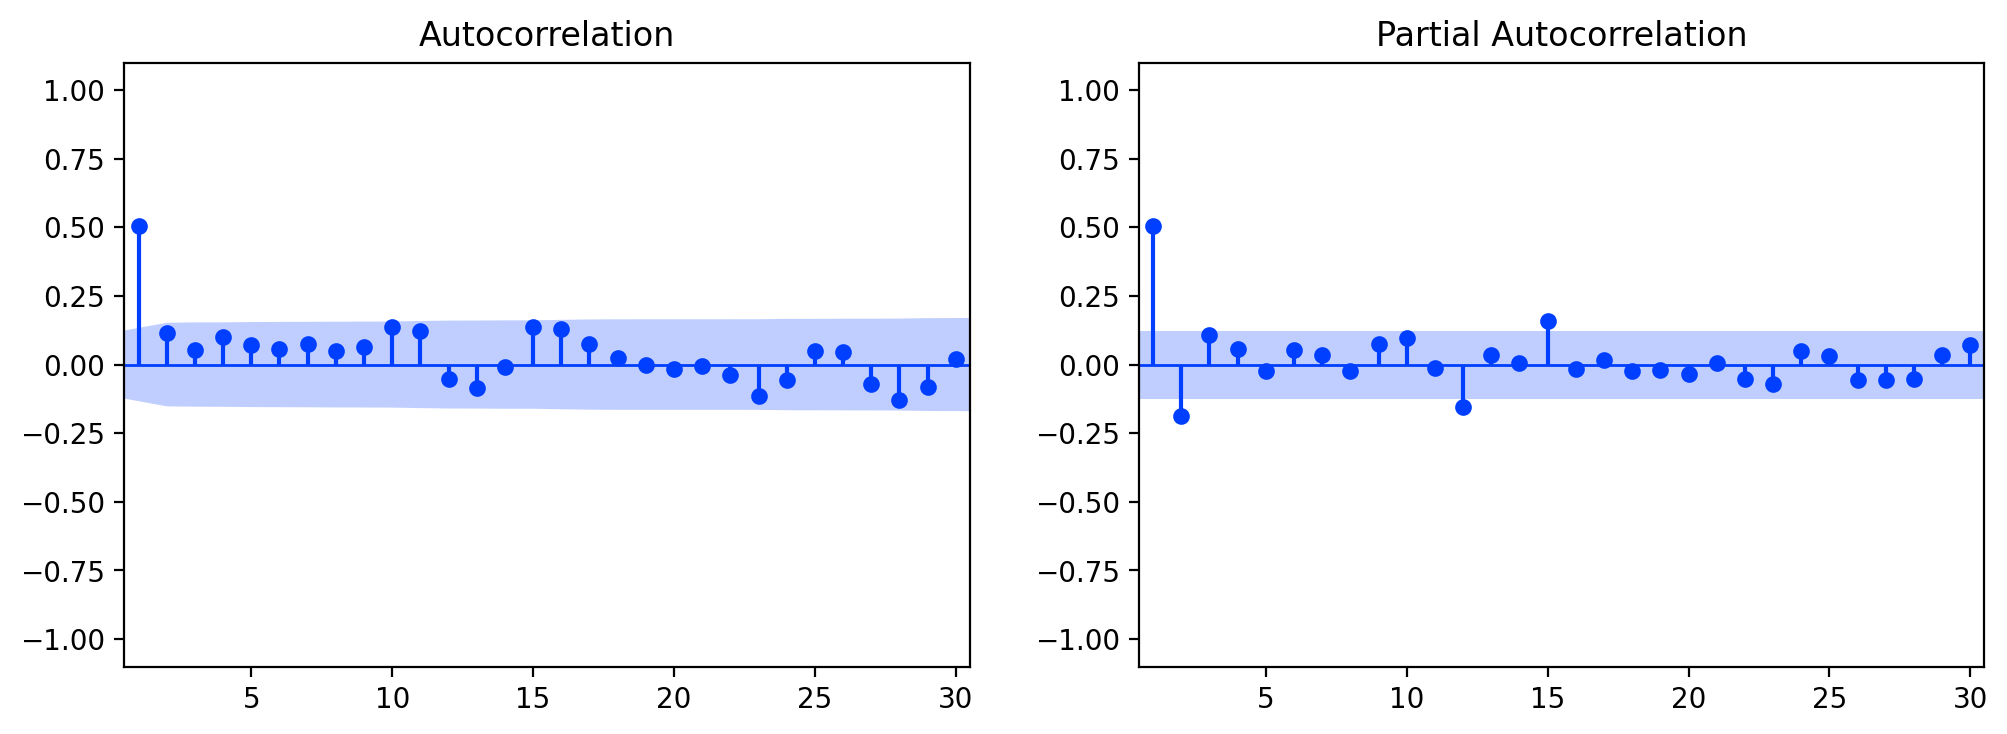

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plot_acf(change["value"], ax=axes[0], linewidth = 1, lags=30)
axes[0].set_ylim(-1.1, 1.1)
axes[0].set_xlim(0.5, 30.5)

plot_pacf(change["value"], ax=axes[1], lags=30, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
axes[1].set_xlim(0.5, 30.5)

plt.show()

Running many ARIMA models

In [49]:
change.index = pd.DatetimeIndex(change.index.values,freq=change.index.inferred_freq)

In [50]:
# def. models
ar1 = ARIMA(change, order = (1,0,0))
ar2 = ARIMA(change, order = (2,0,0))
ar4 = ARIMA(change, order = (4,0,0))
ma1 = ARIMA(change, order = (0,0,1))
arma1 = ARIMA(change, order = (1,0,1))
arma2 = ARIMA(change, order = (2,0,1))
arima1 = ARIMA(change, order = (1,1,0))
arima2 = ARIMA(change, order = (0,1,1))
arima3 = ARIMA(change, order = (1,1,1))
rw = ARIMA(change, order = (0,1,0))

# fit
ar1_fit = ar1.fit()
ar2_fit = ar2.fit()
ar4_fit = ar4.fit()
ma1_fit = ma1.fit()
arma1_fit = arma1.fit()
arma2_fit = arma2.fit()
arima1_fit = arima1.fit()
arima2_fit = arima2.fit()
arima3_fit = arima3.fit()
rw_fit = rw.fit()

In [51]:
# BIC, AIC
print("ARIMA(1,0,0): BIC ",round(ar1_fit.bic,2),": AIC ",round(ar1_fit.aic,2))
print("ARIMA(2,0,0): BIC ",round(ar2_fit.bic,2),": AIC ",round(ar2_fit.aic,2))
print("ARIMA(4,0,0): BIC ",round(ar4_fit.bic,2),": AIC ",round(ar4_fit.aic,2))
print("ARIMA(0,0,1): BIC ",round(ma1_fit.bic,2),": AIC ",round(ma1_fit.aic,2))
print("ARIMA(1,0,1): BIC ",round(arma1_fit.bic,2),": AIC ",round(arma1_fit.aic,2))
print("ARIMA(2,0,1): BIC ",round(arma2_fit.bic,2),": AIC ",round(arma2_fit.aic,2))
print("ARIMA(1,1,0): BIC ",round(arima1_fit.bic,2),": AIC ",round(arima1_fit.aic,2))
print("ARIMA(0,1,1): BIC ",round(arima2_fit.bic,2),": AIC ",round(arima2_fit.aic,2))
print("ARIMA(1,1,1): BIC ",round(arima3_fit.bic,2),": AIC ",round(arima3_fit.aic,2))
print("ARIMA(0,1,0): BIC ",round(rw_fit.bic,2),": AIC ",round(rw_fit.aic,2))

ARIMA(1,0,0): BIC  1330.57 : AIC  1320.01
ARIMA(2,0,0): BIC  1327.35 : AIC  1313.27
ARIMA(4,0,0): BIC  1334.68 : AIC  1313.55
ARIMA(0,0,1): BIC  1325.48 : AIC  1314.91
ARIMA(1,0,1): BIC  1325.87 : AIC  1311.79
ARIMA(2,0,1): BIC  1331.25 : AIC  1313.64
ARIMA(1,1,0): BIC  1388.25 : AIC  1381.21
ARIMA(0,1,1): BIC  1374.78 : AIC  1367.74
ARIMA(1,1,1): BIC  1329.58 : AIC  1319.03
ARIMA(0,1,0): BIC  1385.63 : AIC  1382.12


Computing the recursive forecast

In [52]:
f_ar1 = ar1_fit.get_forecast(steps=12, alpha = 0.05)
f_ar2 = ar2_fit.get_forecast(steps=12, alpha = 0.05)
f_ar4 = ar4_fit.get_forecast(steps=12, alpha = 0.05)
f_ma1 = ma1_fit.get_forecast(steps=12, alpha = 0.05)
f_arma1 = arma1_fit.get_forecast(steps=12, alpha = 0.05)
f_arma2 = arma2_fit.get_forecast(steps=12, alpha = 0.05)
f_arima1 = arima1_fit.get_forecast(steps=12, alpha = 0.05)
f_arima2 = arima2_fit.get_forecast(steps=12, alpha = 0.05)
f_arima3 = arima3_fit.get_forecast(steps=12, alpha = 0.05)
f_rw = rw_fit.get_forecast(steps=12, alpha = 0.05)

fct_ar1 = (
    pd.merge(
        f_ar1.predicted_mean.reset_index().rename(columns = {"index":"date","predicted_mean":"forecast"}),
        f_ar1.conf_int().reset_index().rename(columns = {"index":"date"}),
        how="left")
)

fct_ar2 = (
    pd.merge(
        f_ar2.predicted_mean.reset_index().rename(columns = {"index":"date","predicted_mean":"forecast"}),
        f_ar2.conf_int().reset_index().rename(columns = {"index":"date"}),
        how="left")
)

fct_ar4 = (
    pd.merge(
        f_ar4.predicted_mean.reset_index().rename(columns = {"index":"date","predicted_mean":"forecast"}),
        f_ar4.conf_int().reset_index().rename(columns = {"index":"date"}),
        how="left")
)

fct_ma1 = (
    pd.merge(
        f_ma1.predicted_mean.reset_index().rename(columns = {"index":"date","predicted_mean":"forecast"}),
        f_ma1.conf_int().reset_index().rename(columns = {"index":"date"}),
        how="left")
)

fct_arma1 = (
    pd.merge(
        f_arma1.predicted_mean.reset_index().rename(columns = {"index":"date","predicted_mean":"forecast"}),
        f_arma1.conf_int().reset_index().rename(columns = {"index":"date"}),
        how="left")
)

fct_arma2 = (
    pd.merge(
        f_arma2.predicted_mean.reset_index().rename(columns = {"index":"date","predicted_mean":"forecast"}),
        f_arma2.conf_int().reset_index().rename(columns = {"index":"date"}),
        how="left")
)

fct_arima1 = (
    pd.merge(
        f_arima1.predicted_mean.reset_index().rename(columns = {"index":"date","predicted_mean":"forecast"}),
        f_arima1.conf_int().reset_index().rename(columns = {"index":"date"}),
        how="left")
)

fct_arima2 = (
    pd.merge(
        f_arima2.predicted_mean.reset_index().rename(columns = {"index":"date","predicted_mean":"forecast"}),
        f_arima2.conf_int().reset_index().rename(columns = {"index":"date"}),
        how="left")
)

fct_arima3 = (
    pd.merge(
        f_arima3.predicted_mean.reset_index().rename(columns = {"index":"date","predicted_mean":"forecast"}),
        f_arima3.conf_int().reset_index().rename(columns = {"index":"date"}),
        how="left")
)


fct_rw = (
    pd.merge(
        f_rw.predicted_mean.reset_index().rename(columns = {"index":"date","predicted_mean":"forecast"}),
        f_rw.conf_int().reset_index().rename(columns = {"index":"date"}),
        how="left")
)


Plotting forecasts for Year-over-year data:

In [53]:
change = change.reset_index().rename(columns = {"index":"date"})

index_arma2 = change.copy().reset_index(drop=True).rename(columns = {"value":"forecast"})
index_arma2["lower value"] = index_arma2["forecast"]
index_arma2["upper value"] = index_arma2["forecast"]
index_arma2 = pd.concat([index_arma2,fct_arma2]).reset_index(drop=True)
index_arma2["forecast"] = (index_arma2.forecast/12).cumsum().diff(12)
index_arma2["lower value"] = (index_arma2["lower value"]/12).cumsum().diff(12)
index_arma2["upper value"] = (index_arma2["upper value"]/12).cumsum().diff(12)

index_ar4 = change.copy().reset_index(drop=True).rename(columns = {"value":"forecast"})
index_ar4["lower value"] = index_ar4["forecast"]
index_ar4["upper value"] = index_ar4["forecast"]
index_ar4 = pd.concat([index_ar4,fct_ar4]).reset_index(drop=True)
index_ar4["forecast"] = (index_ar4.forecast/12).cumsum().diff(12)
index_ar4["lower value"] = (index_ar4["lower value"]/12).cumsum().diff(12)
index_ar4["upper value"] = (index_ar4["upper value"]/12).cumsum().diff(12)

index_arima3 = change.copy().reset_index(drop=True).rename(columns = {"value":"forecast"})
index_arima3["lower value"] = index_arima3["forecast"]
index_arima3["upper value"] = index_arima3["forecast"]
index_arima3 = pd.concat([index_arima3,fct_arima3]).reset_index(drop=True)
index_arima3["forecast"] = (index_arima3.forecast/12).cumsum().diff(12)
index_arima3["lower value"] = (index_arima3["lower value"]/12).cumsum().diff(12)
index_arima3["upper value"] = (index_arima3["upper value"]/12).cumsum().diff(12)

cpi = change.copy().reset_index(drop=True)
cpi["value"] = (cpi.value/12).cumsum().diff(12)


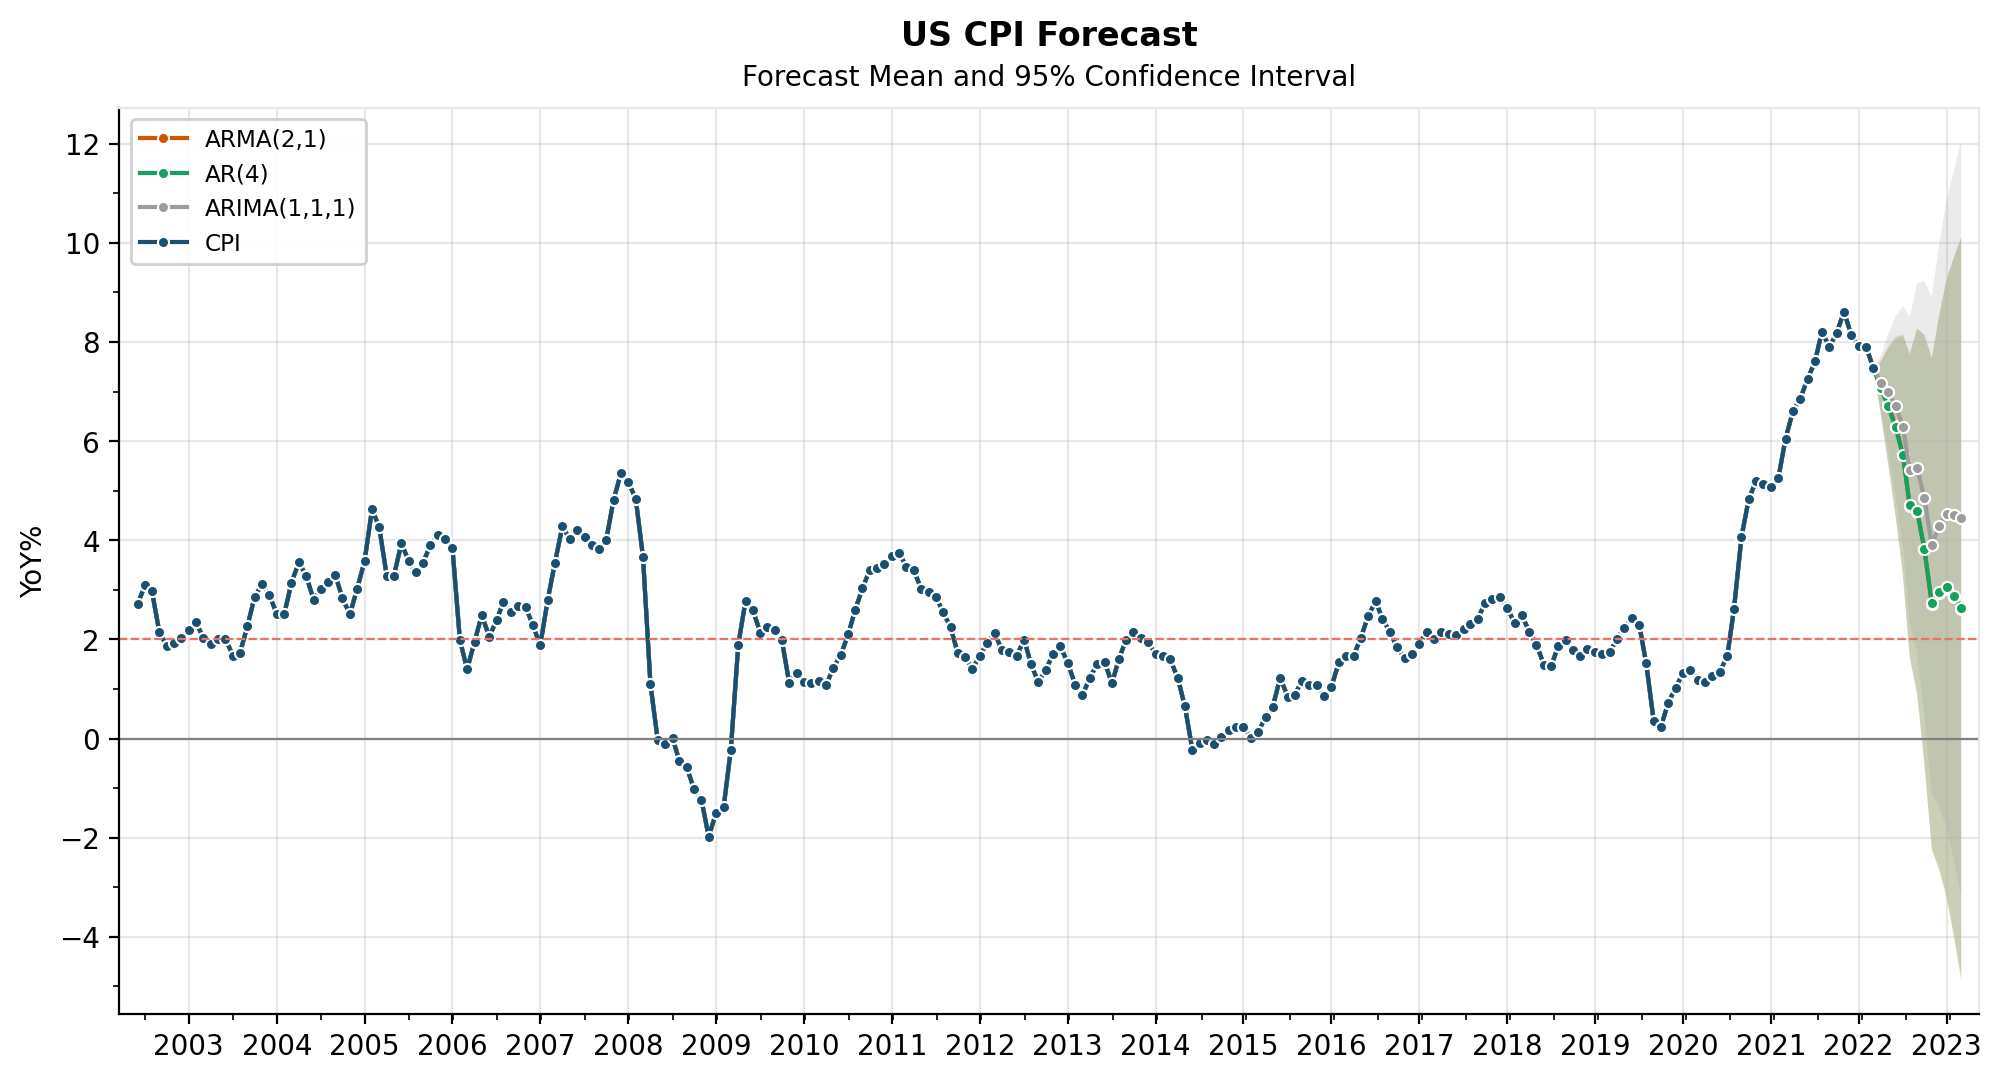

In [54]:
# Plot
fig, ax = plt.subplots(figsize=(12,6))

# ARiMA(2,0,1)
sns.lineplot(
    data=index_arma2,
    x="date",y="forecast",
    color=fn.colors[1], marker = "o", markersize=4, 
    alpha = 1, # map alpha
    ax=ax, legend=False, label = "ARMA(2,1)")

# ARIMA(0,0,1)
sns.lineplot(
    data=index_ar4,
    x="date",y="forecast",
    color=fn.colors[2], marker = "o", markersize=4, 
    alpha = 1, # map alpha
    ax=ax, legend=False, label = "AR(4)")

# RW
sns.lineplot(
    data=index_arima3,
    x="date",y="forecast",
    color=fn.colors[5], marker = "o", markersize=4, 
    alpha = 1, # map alpha
    ax=ax, legend=False, label = "ARIMA(1,1,1)")

# CPI
sns.lineplot(
    data=cpi,
    x="date", y="value",
    color=fn.colors[0], marker = "o", markersize=4,
    alpha = 1, # map alpha
    ax=ax, legend=False, label = "CPI")

ax.legend(["ARMA(2,1)","AR(4)","ARIMA(1,1,1)","CPI"],
          loc= "upper left", frameon=True, framealpha=0.9, fontsize='small')

ax.fill_between(x="date", y1="lower value",y2="upper value",
                color=fn.colors[1], alpha=0.2, data=index_arma2, edgecolor = None)

ax.fill_between(x="date", y1="lower value",y2="upper value",
                color=fn.colors[2], alpha=0.2, data=index_ar4, edgecolor = None)

ax.fill_between(x="date", y1="lower value",y2="upper value",
                color=fn.colors[5], alpha=0.2, data=index_arima3, edgecolor = None)

ax.axhline(y=0, color='gray', lw=0.8)
ax.axhline(y=2, color=fn.colors[25],ls = "--", lw=0.8)

ax.margins(x=0.01, y=0.04)
    
# y axis
ax.set_ylabel("YoY%", size='medium')
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    
# date axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 12))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    
year_month_formatter = mdates.DateFormatter("%Y")
ax.xaxis.set_major_formatter(year_month_formatter)
    
# dropping top and right spines.
ax.spines['top'].set_edgecolor(fn.colors[107])
ax.spines['right'].set_edgecolor(fn.colors[107])

# grid lines
ax.grid(axis='y', alpha=0.3)
ax.grid(axis='x', alpha=0.3)

# adding title
ax.set_title("US CPI Forecast", y=1.05, loc="center",fontweight="bold")

ax.xaxis.set_label_position('top')
ax.set_xlabel("Forecast Mean and 95% Confidence Interval",labelpad = 8, loc="center",size='medium')

plt.show()

We can see from the plot above that the forecasts from the univariate models are indicating that inflation will slow down during the next few months.

Univariate models are usually a standard point for a more robust forecast. Since I collected data for many variables, I will try to use them to forecast inflation using a Lasso model.

A general (Elastic Net) shrinkage optimization problem can be written as:


$$\tilde{\beta}=\underset{\beta}{argmin}\left\{ \sum_{n=1}^{n} (y_{i}-\beta_0-\sum_{j=1}^{p} x_{i,j}\beta_j)^2 +\lambda\sum_{j=1}^{p} ((1-\alpha)\beta^2_j+\alpha|\beta_j|)\right\}$$

where:
-   $\lambda$: Controls the size of the penalty
-   $\alpha$: Defines the type of penalty (1 for LASSO, 0 for Ridge, and (0,1) Elastic Net)

I'm going to use the lasso model because the python module LassoLarsIC, from sklearn uses Information Criteria to select the lambda variable. Usually the parameter is select by cross validation, but for time series data we might find problems while using that method, because it splits the data randomly to performe the fold validation, but because time series data have a time dependency between observations, using these random splits can affect the results.

Differently from the recursive forecast used for the univariate models, here, I will use a direct forecast approach, meaning that I will have to estimate 12 different models, one for each horizon, but avoid the need of having to estimate different paths for all regressors. The figure below compares the two forecasting approachs for three periods ahead forecasts.


<img src="images/recursive_forecast.PNG" alt="recursive_forecast.png" width = "600px" />

<img src="images/direct_forecast.PNG" alt="direct_forecast.png" width="800px" />

Finally there is a need to compare models (univariate and lasso), to do this I will use a time series cross validation or back testing, and computing the out of sample Root mean square error for each forecast horizon. The estimation process can be applied by using a expanded window approach. The other option is through a fixed (rolling) window scheme. Again, the following figure compare both approachs: 

<img src="images/expanded_window.PNG" alt="expanded_window.png" width="600px" />

<img src="images/rolling_window.PNG" alt="Drawing"  width="600px" />

Using a subset from the `project data` file, and correcting delays of data publications to simulate more how conditions really were in the moment the forecast was made

In [55]:
data = pd.read_parquet("project_data.parquet")
data["dummy"]=0
data.loc[data["date"]=="2008-11-01","dummy"] = 1

data_prep = data.copy()
# calendar adjust
data_prep["Case Shiller"] = data_prep["Case Shiller"].shift(2) # use lag2
data_prep["Job Stayer"] = data_prep["Job Stayer"].shift(1) # use lag1
data_prep["Job Switcher"] = data_prep["Job Switcher"].shift(1) # use lag1
data_prep["Unweighted Overall"] = data_prep["Unweighted Overall"].shift(1)
data_prep["Michigan Automobiles"] = data_prep["Michigan Automobiles"].shift(1) # use lag1
data_prep["Michigan House Durable Goods"] = data_prep["Michigan House Durable Goods"].shift(1) # use lag1
data_prep["Michigan Inflation Expectation 12m"] = data_prep["Michigan Inflation Expectation 12m"].shift(1)
data_prep["Michigan Inflation Expectation 5y"] = data_prep["Michigan Inflation Expectation 5y"].shift(1)
data_prep["Real Income"] = data_prep["Real Income"].shift(1)

# adding CPI lag
data_prep["lag_cpi"] = data_prep["CPI"].shift(1)

# filtering
data_prep = data_prep[(data_prep["date"]>="2003") & (data_prep["date"]<"2022-12-01")]
data_prep = data_prep.drop(columns = ["Real PCE",
                                      "Michigan Automobiles",
                                      "Michigan House Durable Goods",
                                      "Empire Prices Paid (future)","Empire Prices Received (future)",
                                      "Empire Prices Paid (current)","Empire Prices Received (current)",
                                      "Philly Prices Paid (future)","Philly Prices Received (future)",
                                      "Richmond Prices Paid (future)","Richmond Prices Received (future)",
                                      "NFIB Inflation Problem"])
data_prep.reset_index(drop=True).head()

date       CPI  Case Shiller  Fed Funds        Gas  \
0 2003-01-01  0.439079      0.740882   1.255714   5.044505   
1 2003-02-01  0.546151      0.749538   1.260000  10.137316   
2 2003-03-01  0.163265      0.655259   1.250476   4.840630   
3 2003-04-01 -0.381368      0.694294   1.262727  -6.339722   
4 2003-05-01 -0.163890      0.610397   1.268571  -5.947480   

   ISM Manufacturing Prices  ISM Nonmanufacturing Prices  Job Stayer  \
0                      57.5                         58.0         3.7   
1                      65.5                         60.5         3.7   
2                      70.0                         59.4         3.9   
3                      63.5                         55.7         3.7   
4                      51.5                         50.0         3.4   

   Job Switcher   Manheim  ...   Payroll  Philly Prices Paid (current)  \
0           3.5 -1.131021  ...  0.082742                          12.4   
1           3.8 -1.335898  ... -0.104205                          16.9   
2           4.0 -1.548918  ... -0.162654                          21.5   
3           3.8 -0.097609  ... -0.042241                          20.3   
4           3.7  0.389864  ...  0.014594                           7.1   

   Philly Prices Received (current)  Real Income  \
0                               6.1     0.239108   
1                               0.7    -0.147095   
2                              -5.5    -0.356400   
3                               7.3     0.236262   
4                              -1.4     0.590126   

   Richmond Prices Paid (current)  Richmond Prices Received (current)  \
0                            0.81                                0.31   
1                            0.74                                0.09   
2                            0.99                               -0.20   
3                            0.77                                0.31   
4                            0.74                               -0.07   

   Unemployment Rate  Unweighted Overall  dummy   lag_cpi  
0                5.8                 3.6      0  0.165153  
1                5.9                 3.7      0  0.439079  
2                5.9                 3.9      0  0.546151  
3                6.0                 3.7      0  0.163265  
4                6.1                 3.5      0 -0.381368  

[5 rows x 24 columns]

In [56]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 767 to 1005
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   date                                239 non-null    datetime64[ns]
 1   CPI                                 238 non-null    float64       
 2   Case Shiller                        239 non-null    float64       
 3   Fed Funds                           239 non-null    float64       
 4   Gas                                 239 non-null    float64       
 5   ISM Manufacturing Prices            239 non-null    float64       
 6   ISM Nonmanufacturing Prices         239 non-null    float64       
 7   Job Stayer                          239 non-null    float64       
 8   Job Switcher                        239 non-null    float64       
 9   Manheim                             239 non-null    float64       
 10  Michigan Inflation Expe

In [57]:
dfcst = data_prep.reset_index(drop=True).copy()

In [58]:
# function to run the back test for the lasso direct forecast
def direct_ts_cv_ICLasso(data, start_date, h, ic="bic", fixed = False):
    """
    Create the time series cross validation (back-test) direct forecast
    for the information criteria lasso.
    ---
    
    Paramns:
        data: pandas dataframe with all data. Target variable (y) has to be named "CPI",
            and date column has to be called "date".
        start_date [str]: date of initial forecast
        h [int]: forecasting horizon
        ic [str]: Information criteria. Default is "bic".
            "aic" and "aicc" also available.
        fixed [bool]: Fixed window, default is False (expanded window)
    ---
    
    Returns:
        forecast: pandas data frame with the following columns:
            date [pd.date_time]: date when forecast was made
            reference date [pd.date_time]: Forecast date
            h [str]: Forecasting horizon in months.
                h = ([reference date] - [date]) + 1
                h = 1 is the forecast for t CPI with X variable from t.
                h = 2 is the forecast for t+1 CPI with X variable from t.
                ...
            forecast [float]: CPI Point Forecast
    
    """
    # data prep acording to forecasting horizon 
    ts_cv = data.reset_index(drop=True).copy()
    ts_cv["CPI"] = ts_cv["CPI"].shift(1-h)
    
    # df to save forecasts
    forecasts = pd.DataFrame(columns = ["reference date", "forecast", "date", "horizon"])
    forecasts["reference date"] = pd.to_datetime(forecasts["reference date"])
    forecasts["date"] = pd.to_datetime(forecasts["date"])
    forecasts["horizon"] = pd.to_numeric(forecasts["horizon"])
    forecasts["forecast"] = pd.to_numeric(forecasts["forecast"])
    
    # building the idx for time series cross-validation/ back-testing
    # Get start day index
    start_idx = ts_cv[ts_cv["date"] == start_date].index[0]
    
    # Get last date index
    last_idx = ts_cv[ts_cv["date"] == ts_cv["date"].max()].index[0]
    
    # building list with iteration index samples
    indx = list()
    
    for i, idx in enumerate(range(start_idx -h +1,last_idx +1)):
        
        if fixed == False:
            indx.append(list(range(0, idx +1)))
        else:
            indx.append(list(range(i, idx +1)))
      
    
    # now, building the loop that select the sample, run the lasso, and store results
    for i in range(len(indx)):
        
        df = ts_cv.copy().loc[indx[i]]
        y = df["CPI"]
        x = df.drop(columns = ["date","CPI"])
        
        scaler = StandardScaler()
        x = pd.DataFrame(data = scaler.fit_transform(x),
                         columns = scaler.feature_names_in_)
        
        y_train = y.iloc[:-h]
        x_train = x.iloc[:-h]
        
        x_test = x.iloc[[-1],:]
        
        lasso_ic = LassoLarsIC(criterion="bic", normalize=False)
        fit = lasso_ic.fit(x_train, y_train)
        
        fcst = pd.DataFrame(fit.predict(x_test), columns = ["forecast"],
                            index = [df.date.max()+ pd.DateOffset(months = h-1)])
        
        fcst = fcst.reset_index().rename(columns = {"index":"reference date"})
        fcst["date"] = df.date.max()
        fcst["horizon"] = h
        
        forecasts = pd.concat([forecasts,fcst])
    
    return forecasts[["date","reference date","horizon","forecast"]].reset_index(drop=True)


In [59]:
h1 = direct_ts_cv_ICLasso(data = dfcst,
                         start_date = "2016-01-01",
                         h=1, ic="bic",fixed = False)
h1

date reference date  horizon  forecast
0  2016-01-01     2016-01-01        1 -0.092217
1  2016-02-01     2016-02-01        1 -0.311190
2  2016-03-01     2016-03-01        1  0.430714
3  2016-04-01     2016-04-01        1  0.348844
4  2016-05-01     2016-05-01        1  0.378584
..        ...            ...      ...       ...
78 2022-07-01     2022-07-01        1  0.257976
79 2022-08-01     2022-08-01        1 -0.037075
80 2022-09-01     2022-09-01        1  0.143299
81 2022-10-01     2022-10-01        1  0.563983
82 2022-11-01     2022-11-01        1  0.341592

[83 rows x 4 columns]

In [60]:
result_lasso = h1.copy()

for i in range(2,13):
    print(f"iteration: {i}/12")
    result_lasso = pd.concat([result_lasso,
                             direct_ts_cv_ICLasso(data = dfcst,
                                                  start_date = "2016-01-01",
                                                  h=i,ic="bic",fixed = False)])
result_lasso.info()

iteration: 2/12
iteration: 3/12
iteration: 4/12
iteration: 5/12
iteration: 6/12
iteration: 7/12
iteration: 8/12
iteration: 9/12
iteration: 10/12
iteration: 11/12
iteration: 12/12
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1062 entries, 0 to 93
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1062 non-null   datetime64[ns]
 1   reference date  1062 non-null   datetime64[ns]
 2   horizon         1062 non-null   int64         
 3   forecast        1062 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 41.5 KB


In [61]:
#Computing RMSE
lasso_rmse = dfcst[["date","CPI"]].rename(columns = {"date":"reference date"})
lasso_rmse = pd.merge(result_lasso,lasso_rmse, how="left")
lasso_rmse = lasso_rmse.dropna()
lasso_rmse["rmse"] = (lasso_rmse["CPI"]-lasso_rmse["forecast"])**2
lasso_rmse = lasso_rmse[["horizon","rmse"]]
lasso_rmse = lasso_rmse.groupby("horizon")["rmse"].mean().reset_index()
lasso_rmse["rmse"] = np.sqrt(lasso_rmse["rmse"])
lasso_rmse = lasso_rmse.rename(columns = {"rmse":"lasso"})
lasso_rmse

horizon     lasso
0         1  0.141091
1         2  0.288602
2         3  0.300184
3         4  0.313243
4         5  0.333162
5         6  0.358553
6         7  0.339636
7         8  0.327309
8         9  0.328183
9        10  0.328822
10       11  0.328804
11       12  0.330819

The tabel below display the lasso forecast for the next twelve months for the monthly inflation rate. Like the Univariate models, the lasso result is also point for a drop in inflation over the next twelve months

In [62]:
result_lasso[result_lasso["date"]>="2022-11-01"]

date reference date  horizon  forecast
82 2022-11-01     2022-11-01        1  0.341592
83 2022-11-01     2022-12-01        2  0.292659
84 2022-11-01     2023-01-01        3  0.411587
85 2022-11-01     2023-02-01        4  0.257811
86 2022-11-01     2023-03-01        5  0.194122
87 2022-11-01     2023-04-01        6  0.174945
88 2022-11-01     2023-05-01        7  0.259562
89 2022-11-01     2023-06-01        8  0.163246
90 2022-11-01     2023-07-01        9  0.252142
91 2022-11-01     2023-08-01       10  0.208037
92 2022-11-01     2023-09-01       11  0.209424
93 2022-11-01     2023-10-01       12  0.173575

Now, doing the same for recursive univariate models

In [63]:
def ts_cv_arima(df,p,d,q,start_date,h=12,t='n', fixed = False):
    """
    Time series cross-validation using arima models and recursive forecasts.
    ---
    
    Paramns:
        df: pandas dataframe with date columns "date" and CPI data "CPI".
        p [int]: AR order.
        d [int]: Integration order.
        q [int]: MA order.
        start_date [str]: date of initial forecast.
        h [int]: forecasting horizon.
        t [str]: Trend in arima model.
            "n" none, "c" constant, "t" linear trend, "ct" both.
        fixed [bool]: Fixed window, default is False (expanded window)
    ---
    
    Returns:
        forecast: pandas data frame with the following columns:
            date [pd.date_time]: date when forecast was made
            reference date [pd.date_time]: Forecast date
            h [str]: Forecasting horizon in months.
            forecast [float]: CPI Point Forecast
    """
    
    df = df.reset_index(drop=True)
    
    # creating empty df to save forecasts
    forecasts = pd.DataFrame(columns = ["date", "reference date", "horizon", "forecast"])
    forecasts["reference date"] = pd.to_datetime(forecasts["reference date"])
    forecasts["date"] = pd.to_datetime(forecasts["date"])
    forecasts["horizon"] = pd.to_numeric(forecasts["horizon"])
    forecasts["forecast"] = pd.to_numeric(forecasts["forecast"])
    
    # creating ts cross validation index
    # first forecast index
    start_idx = df[df["date"] == start_date].index[0]
    
    # Get last date index
    last_idx = df[df["date"] == df["date"].max()].index[0]
    
    # building list with training index
    indx = list()
            
    for i, idx in enumerate(range(start_idx -h +1,last_idx +1)):
        
        if fixed == False:
            indx.append(list(range(0, idx)))
        else:
            indx.append(list(range(i, idx)))
    
    
    # inside loop
    for i in range(len(indx)):
        
        arima_df = df.loc[indx[i]]
        
        # prepering for the ARIMA model
        arima_df = arima_df.set_index('date')
        arima_df.index = pd.DatetimeIndex(arima_df.index.values,freq=arima_df.index.inferred_freq)
        
        # Running model
        arima = ARIMA(arima_df, order = (p,d,q),trend=t,
                      enforce_stationarity=False,enforce_invertibility=False)
        arima_fit = arima.fit()
        f_arima = arima_fit.get_forecast(steps=h)
        
        fcst = (
            f_arima
            .predicted_mean
            .reset_index()
            .rename(columns = {"index":"reference date","predicted_mean":"forecast"}))
        fcst["date"] = fcst["reference date"].min()
        
        fcst = fcst.reset_index().rename(columns = {"index":"horizon"})
        fcst["horizon"] = fcst["horizon"]+1 
        
        fcst = fcst[["date","reference date","horizon", "forecast"]]
        
        forecasts = pd.concat([forecasts,fcst])
    
    return forecasts[forecasts["reference date"]>=start_date].reset_index(drop=True)


In [64]:
# selecting Total CPI MoM
cpi = data_prep[["date","CPI"]].copy()
# parameters for function
cpi = cpi[cpi["date"]>="2003"].dropna()

rw = ts_cv_arima(df = cpi,
                 p = 0,d = 1,q = 0,
                 start_date = "2016-01-01",
                 h = 12, t = 'n')


In [65]:
def rmse(y, y_hat, model):
    
    df = y.copy()[["date","CPI"]].rename(columns = {"date":"reference date"})
    df = pd.merge(y_hat,df, how="left")
    df = df.dropna()
    df["rmse"] = (df["CPI"]-df["forecast"])**2
    df = df[["horizon","rmse"]]
    df = df.groupby("horizon")["rmse"].mean().reset_index()
    df["rmse"] = np.sqrt(df["rmse"])
    
    return df.rename(columns = {"rmse":model})


In [66]:
rw_rmse = rmse(y=cpi,y_hat=rw,model = "RW")
rw_rmse

horizon        RW
0         1  0.291389
1         2  0.372600
2         3  0.363106
3         4  0.372231
4         5  0.353111
5         6  0.357977
6         7  0.339019
7         8  0.328473
8         9  0.341336
9        10  0.343481
10       11  0.356390
11       12  0.377797

In [67]:
arima1 = ts_cv_arima(df = cpi,
                     p = 1,d = 1,q = 1,
                     start_date = "2016-01-01",
                     h = 12, t = 'n', fixed = False)

#Computing RMSE
arima1_rmse = rmse(y=cpi,y_hat=arima1,model = "ARIMA(1,1,1)")
arima1_rmse

C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


horizon  ARIMA(1,1,1)
0         1      0.266723
1         2      0.310426
2         3      0.309449
3         4      0.320887
4         5      0.323381
5         6      0.325259
6         7      0.325831
7         8      0.327686
8         9      0.328430
9        10      0.329006
10       11      0.329728
11       12      0.329871

In [186]:
ar4 = ts_cv_arima(df = cpi,
                  p = 4,d = 0,q = 0,
                  start_date = "2016-01-01",
                  h = 12, t = 'c')

ar4_rmse = rmse(y=cpi,y_hat=ar4,model = "AR(4)")
ar4_rmse

horizon     AR(4)
0         1  0.268251
1         2  0.319130
2         3  0.322506
3         4  0.320500
4         5  0.320900
5         6  0.324138
6         7  0.325987
7         8  0.327441
8         9  0.327778
9        10  0.327963
10       11  0.328356
11       12  0.328685

In [187]:
arma = ts_cv_arima(df = cpi,
                  p = 2,d = 0,q = 1,
                  start_date = "2016-01-01",
                  h = 12, t = 'c')

arma_rmse = rmse(y=cpi,y_hat=arma,model = "ARMA(2,1)")
arma_rmse

horizon  ARMA(2,1)
0         1   0.270277
1         2   0.329141
2         3   0.334400
3         4   0.331144
4         5   0.327659
5         6   0.326664
6         7   0.327315
7         8   0.328396
8         9   0.329155
9        10   0.329516
10       11   0.329849
11       12   0.330099

Comparing the results we can see that lasso model is more accurate for short run horizons when compared to the univariate models. For longer horizons, the accuracy is almost the same.